In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, linregress, skew
from Data_scrapping import get_market_data_about_option_chain_for_computing_implied_volatility, get_data_about_crypto_options, get_funding_rate
from Computing_IV import get_Implied_volatility, black_delta_formula
from Graphs import plot_discount_curve, lines_3D, lines_3D_SVI_raw, lines_2D_SVI_raw, lines_3D_data_options, error_graph_3D, lines_2D_SVI, lines_2D_total_varience
from SVI_curves import computing_SVI_IV
from check_static_arbitrage import get_g_function_for_butterfly_arbitrage, check_butterflies_arbitrage_with_formula, check_calendar_arbitrage, check_limit_price, check_static_arbitrage
from Computing_option_prices import get_data_about_option
from Functions_for_extrapolation import get_jump_wing_param, get_curvature, get_skew, get_SVI_extrapolation, lines_2D_SVI_example
from SVI_calibrator import SVI
from mpl_toolkits.mplot3d import Axes3D

In [20]:
# scrapping market data about option chain for specified tickers
tickers_set = ['^SPX','AAPL','MSFT','NVDA','AVGO','ORCL', 'CSCO', 'CRM','TXN','ADBE','QCOM','INTC','IBM','AMZN','TSLA', 'HD','MCD','NKE','LOW', 'GOOG', 'META','TMUS','DIS','NFLX','VZ', 'CMCSA','T', 'XOM', 'CVX', 'COP', 'BRK-B', 'V', 'JPM', 'MA', 'BAC','WFC','SCHW','MS','UNH', 'JNJ', 'PFE', 'ABBV', 'MRK', 'TMO', 'ABT', 'BMY', 'CVS', 'WMT', 'PG', 'KO', 'PEP', 'COST', 'PM', 'UPS', 'RTX', 'HON', 'NEE']

# get_market_data_about_option_chain_for_computing_implied_volatility(tickers_set)

In [22]:
len(tickers_set)

57

Download data about option chains from Yahoo Finance and discount curve as 3 - month SOFR Forward from Chatham Finance. Data about SOFR Forward curve for 1 and 3 month is available to this link: https://www.chathamfinancial.com/technology/us-forward-curves

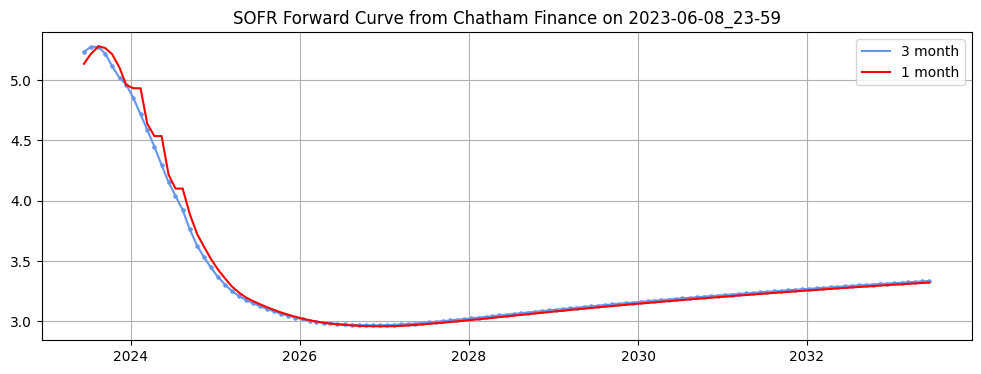

In [2]:
ticker = 'AAPL'
data_date = "2023-06-08_23-59"
filename_for_option_chain = "DATA\\Option_chain\\" + data_date + "\\" + ticker + ".csv"
filename_for_discount_curve = "DATA\\Discount_curve\\" + data_date + "\\Forward_SOFR_curve.xlsx"
options_data = pd.read_csv(filename_for_option_chain)
options_data = options_data.loc[pd.to_datetime(options_data['lastTradeDate']) > '2023-06-08 00:00:00'] # keep trades only in last date
discount_curve = pd.read_excel(filename_for_discount_curve)
plot_discount_curve(discount_curve, data_date)

In [3]:
expiry_date_list= options_data["expiryDate"].unique()
for expiry_date in expiry_date_list:
    options_at_given_expiry = options_data.loc[options_data["expiryDate"]==expiry_date]
    print("Number contracts expiring on", expiry_date, ":", len(options_at_given_expiry))

Number contracts expiring on 2023-06-09 : 33
Number contracts expiring on 2023-06-16 : 58
Number contracts expiring on 2023-06-23 : 34
Number contracts expiring on 2023-06-30 : 33
Number contracts expiring on 2023-07-07 : 33
Number contracts expiring on 2023-07-14 : 28
Number contracts expiring on 2023-07-21 : 45
Number contracts expiring on 2023-08-18 : 46
Number contracts expiring on 2023-09-15 : 43
Number contracts expiring on 2023-10-20 : 43
Number contracts expiring on 2023-11-17 : 38
Number contracts expiring on 2023-12-15 : 51
Number contracts expiring on 2024-01-19 : 70
Number contracts expiring on 2024-03-15 : 51
Number contracts expiring on 2024-06-21 : 52
Number contracts expiring on 2024-09-20 : 38
Number contracts expiring on 2024-12-20 : 35
Number contracts expiring on 2025-01-17 : 59
Number contracts expiring on 2025-06-20 : 36
Number contracts expiring on 2025-12-19 : 55


Computing implied volatility by inverse solving Black-76 model respect to sigma, for given market option data.

In [4]:
Implied_Volatility = get_Implied_volatility(options_data, discount_curve)

In [81]:
def lines_2D_SVI(ticker, data_dict, expiry_date):
    fig = plt.figure(figsize=(13, 6))
    ax1 = fig.add_subplot(121)
#     ax2 = fig.add_subplot(122)

    k = data_dict["implied_volatility_surface"][expiry_date]
    grid = np.array(k['strikes'])/k['reference_forward']
    ax1.scatter(grid, k['mid_implied_volatilities'], s = 5, color='y')
    ax1.plot(grid, k['mid_implied_volatilities'], label= 'mid IV from BM', color='y', linewidth=0.7)
    
    ax1.scatter(grid, k['bid_implied_volatilities'], s = 5, color='g')
    ax1.plot(grid, k['bid_implied_volatilities'], label= 'bid IV from BM', color='g', linewidth=0.7)
    
    ax1.scatter(grid, k['ask_implied_volatilities'], s = 5, color='r')
    ax1.plot(grid, k['ask_implied_volatilities'], label= 'ask IV from BM', color='r', linewidth=0.7)

    ax1.set_title(ticker + ' '+ k['expiry_date'])
    ax1.set_xlabel(r'strike (fwd moneyness)')
    ax1.set_ylabel(r'Implied Volatility')
    ax1.legend()
    ax1.grid()
    plt.show()

KeyError: 'SVI_implied_volatilities'

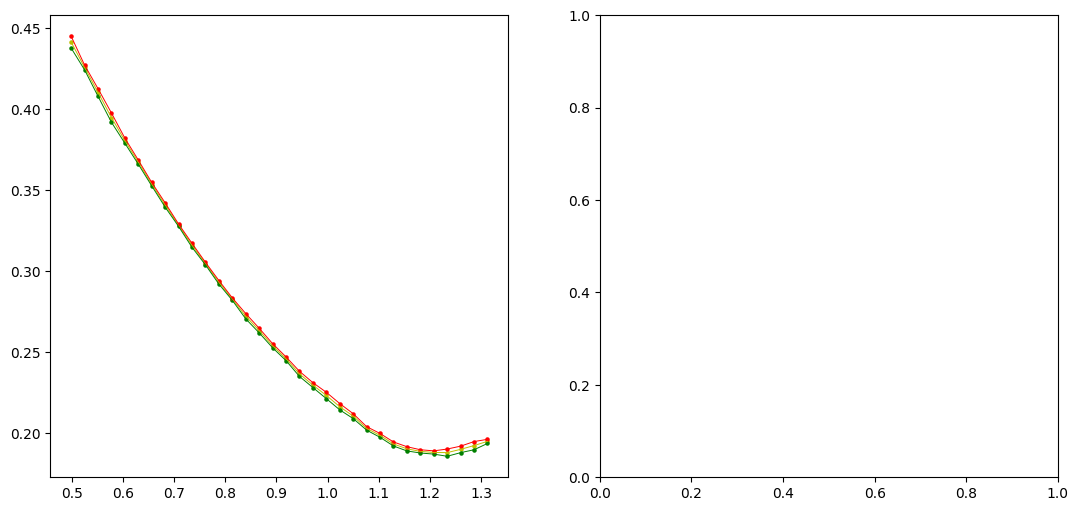

In [6]:
lines_2D_SVI(ticker, Implied_Volatility, 9)

In [83]:
# %timeit get_Implied_volatility(options_data, discount_curve)

Each lines on the graph is expiration date, points are the contracts on last trade date.

X-line is forward moneyness - Strike / reference forward. 
Y-line - maturity in year fraction. 
Z-line - implied volatility

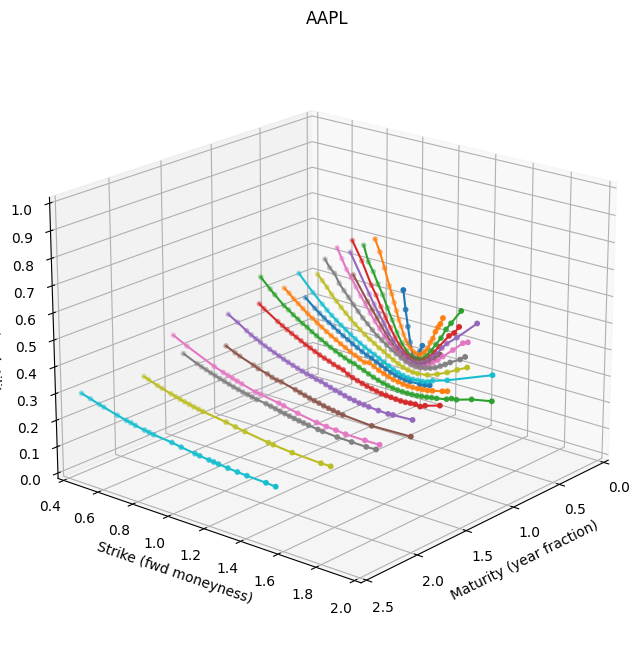

In [169]:
lines_3D(ticker, Implied_Volatility)

SVI Model (Stochastic volatility inspired) is some function that used to approximate the implied volatility curve. $x = ln(K/F_0)$ and $\omega = T\sigma^2$ - full implied variance
$$\omega(x) = a + b \left(\rho(x - m) + \sqrt{(x-m)^2 + \sigma^2}\right)$$
$a, b, \rho, m, \sigma$ - parameters, where $(a \in \mathbb{R}, b \geqslant 0, |\rho| < 1, m \in \mathbb{R}, \sigma > 0)$


In [5]:
Implied_Volatility_without_extrapolation = computing_SVI_IV(Implied_Volatility, ticker, low_limit = 0.1, high_limit = 2.5, N = 1000, extrapolation=False)

In [ ]:
# %timeit computing_SVI_IV(Implied_Volatility, ticker, low_limit = 0.1, high_limit = 2.5, N = 1000, extrapolation=False)

Parameter calibration is based on the algorithm implemented by Zhitlukhin M.V. Initial parameters for SVI calibration are calibrated SVI parameters from previous day. If the previous calibration is absence for specific expiration, use initial parameters from article "Robust Calibration For SVI Model Arbitrage Free" by Tahar Ferhati: $a = \frac{1}{2} min[w(x)], b = 0.1, rho -0.5, m = 0.1, sigma = 0.1$

In [48]:
Initial_parametres = pd.read_csv('DATA\\Initial_parametres_for_SVI_calibrator\\List_initial_parameters_for_SVI.csv', index_col='expiry_date')
Initial_parametres.loc[Initial_parametres['date'] == '2023-6-8']

date  2023-05-12  2023-05-19  2023-05-26  2023-06-02   
expiry_date                                                             
a            2023-6-8         NaN         NaN         NaN         NaN  \
b            2023-6-8         NaN         NaN         NaN         NaN   
rho          2023-6-8         NaN         NaN         NaN         NaN   
m            2023-6-8         NaN         NaN         NaN         NaN   
sigma        2023-6-8         NaN         NaN         NaN         NaN   

             2023-06-09  2023-06-16  2023-06-23  2023-07-21  2023-08-18  ...   
expiry_date                                                              ...   
a                   NaN   -0.018130   -0.015460   -0.160731   -0.136644  ...  \
b                   NaN    0.073097    0.070470    0.230875    0.226499  ...   
rho                 NaN   -0.017907    0.052486    0.282576    0.293325  ...   
m                   NaN    0.010686    0.033081    0.268136    0.297185  ...   
sigma               NaN    0.259995    0.238969    0.742187    0.664207  ...   

             2024-03-15  2024-06-21  2024-09-20  2024-12-20  2025-01-17   
expiry_date                                                               
a             -0.061047   -0.117399   -0.025790   -0.144471   -0.061919  \
b              0.224098    0.206812    0.190812    0.221714    0.181312   
rho            0.321224    0.023932    0.156899   -0.067141   -0.104651   
m              0.417645    0.412930    0.458276    0.463945    0.457320   
sigma          0.420799    0.759804    0.406331    0.939279    0.710998   

             2025-06-20  2025-12-19  2023-06-30  2023-07-07  2023-07-14  
expiry_date                                                              
a             -0.893200   -0.362472   -0.018483   -0.024053   -0.043385  
b              0.371363    0.260076    0.077651    0.088052    0.122530  
rho           -0.145446   -0.264203   -0.027736   -0.048165    0.211396  
m              0.465667    0.435760    0.015339    0.010913    0.125204  
sigma          2.644299    1.858209    0.263286    0.301873    0.387817  

[5 rows x 25 columns]

Follow graphs show comparing implied volatility from SVI model and implied volatility given from Black-76 model for different expirations

In [18]:
def lines_2D_SVI(ticker, data_dict, expiry_date):
    fig = plt.figure(figsize=(13, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    k = data_dict["implied_volatility_surface"][expiry_date]
    grid = np.array(k['strikes'])/k['reference_forward']
    ax1.scatter(grid, k['mid_implied_volatilities'], s = 5, color='y')
    ax1.plot(grid, k['mid_implied_volatilities'], label= 'mid IV from BM', color='y', linewidth=0.7)
    
    ax1.scatter(grid, k['bid_implied_volatilities'], s = 5, color='g')
    ax1.plot(grid, k['bid_implied_volatilities'], label= 'bid IV from BM', color='g', linewidth=0.7)
    
    ax1.scatter(grid, k['ask_implied_volatilities'], s = 5, color='r')
    ax1.plot(grid, k['ask_implied_volatilities'], label= 'ask IV from BM', color='r', linewidth=0.7)
    
    ax1.scatter(grid, k['SVI_implied_volatilities'], s = 5, color='b')
    ax1.plot(grid, k['SVI_implied_volatilities'], label= 'mid IV from SVI', color='b', linewidth=1.5)
    
    ax2.plot(grid, k['max_relative_error'], label= 'error', color='grey', linewidth=3, linestyle='--')

    ax1.set_title(ticker + ' '+ k['expiry_date'])
    ax1.set_xlabel(r'strike (fwd moneyness)')
    ax1.set_ylabel(r'Implied Volatility')
    ax1.legend()
    ax1.grid()
    ax2.set_title(ticker + ' '+ k['expiry_date'] +' error graph')
    ax2.set_xlabel(r'strike (fwd moneyness)')
    ax2.set_ylabel(r'Implied Volatility')
    ax2.legend()
    ax2.grid()
    plt.show()
#     plt.savefig("example.pdf")

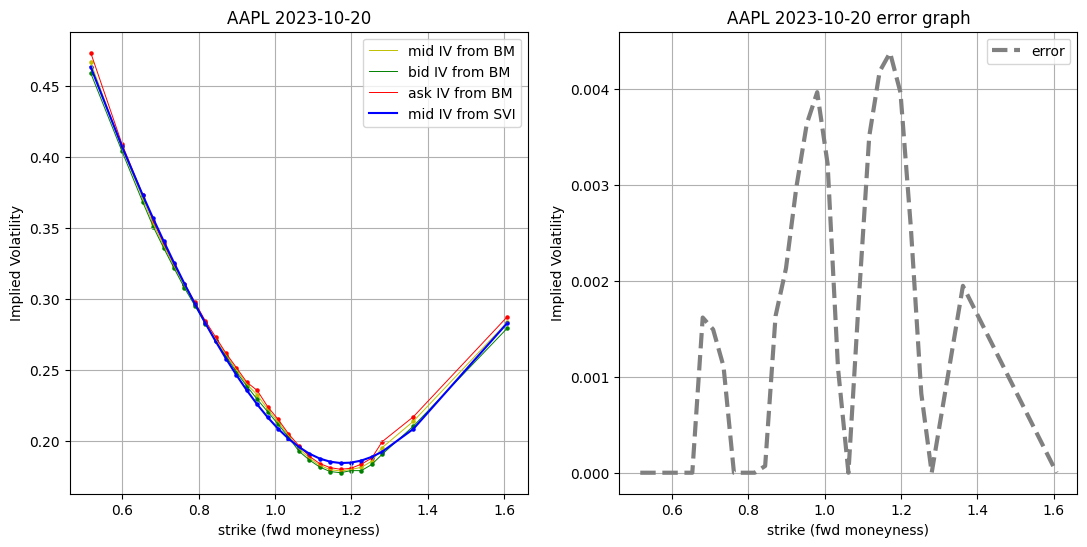

In [20]:
lines_2D_SVI(ticker, Implied_Volatility_without_extrapolation, 9)

<Figure size 640x480 with 0 Axes>

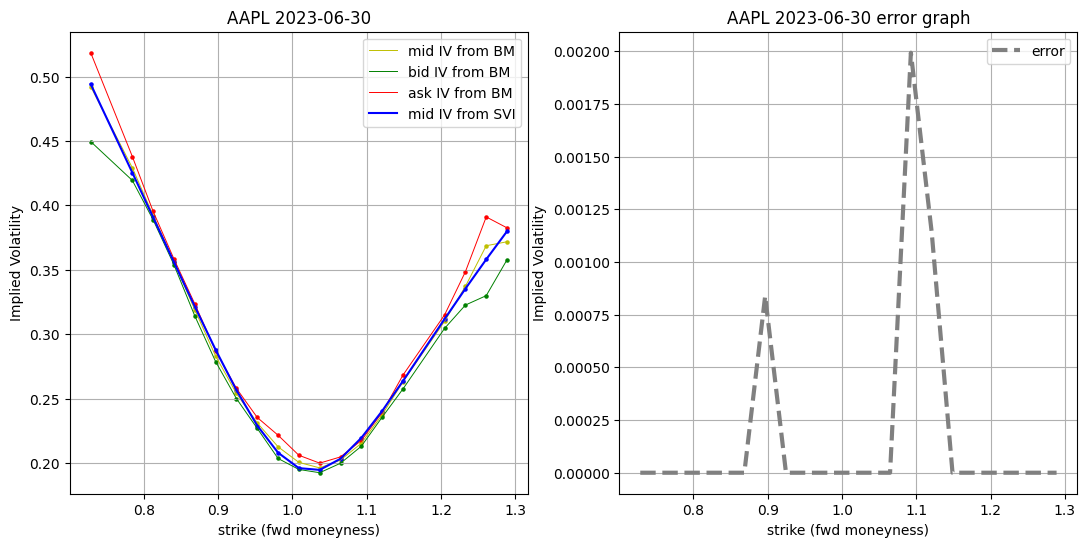

In [50]:
lines_2D_SVI(ticker, Implied_Volatility_without_extrapolation,3)

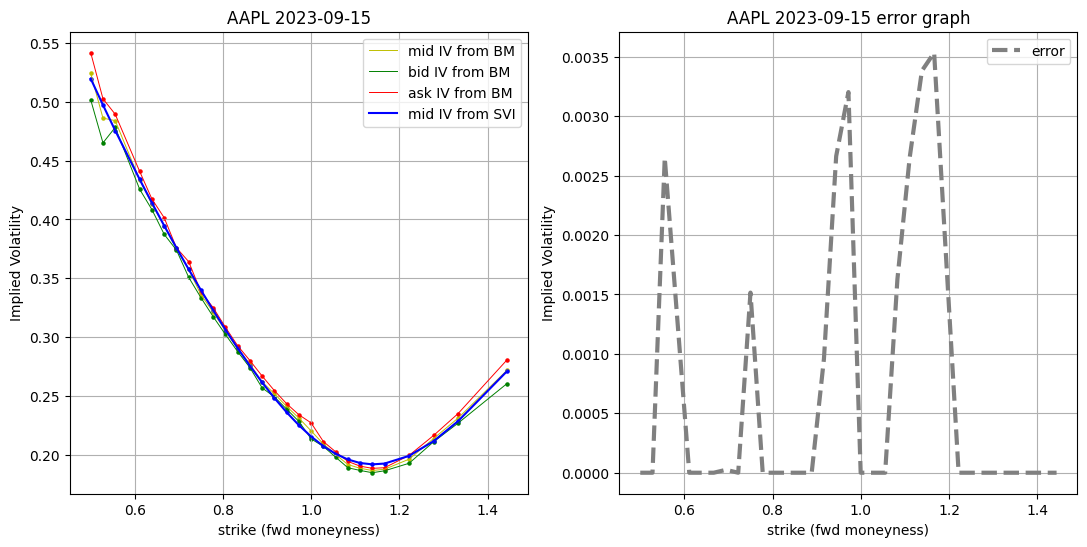

In [51]:
lines_2D_SVI(ticker, Implied_Volatility_without_extrapolation,8)

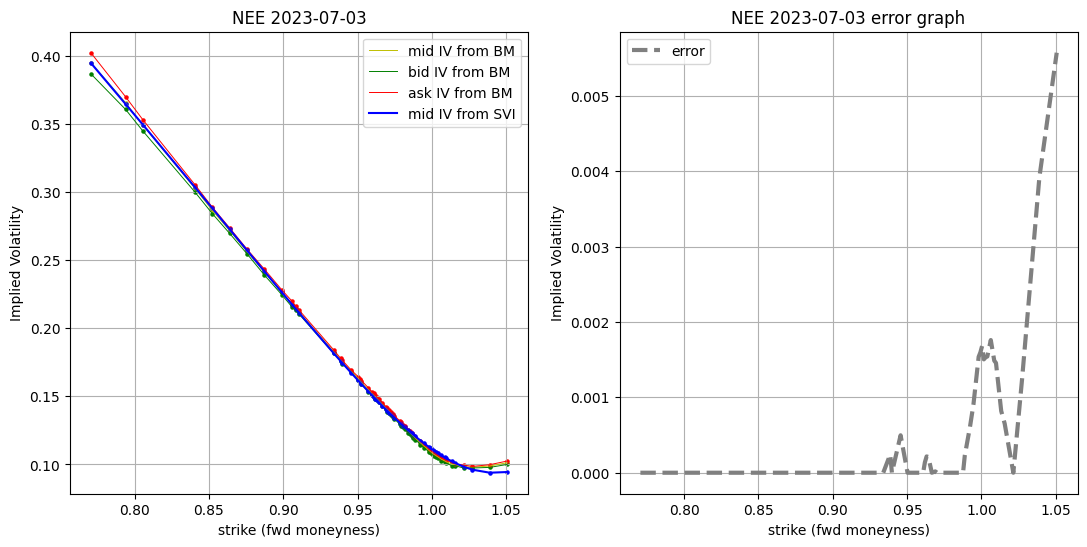

In [67]:
lines_2D_SVI(ticker, Implied_Volatility_without_extrapolation,15)

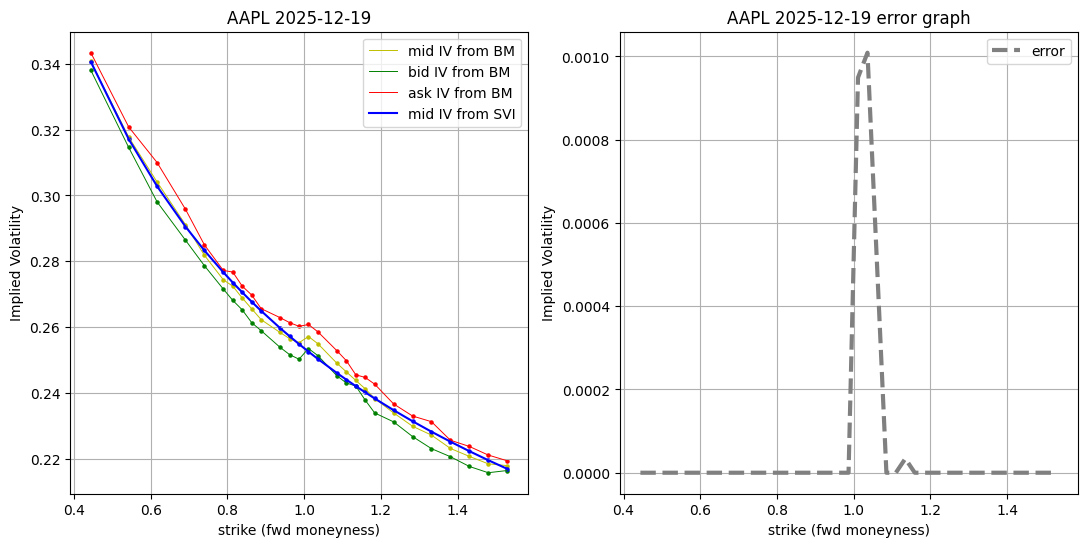

In [75]:
lines_2D_SVI(ticker, Implied_Volatility_without_extrapolation,17)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


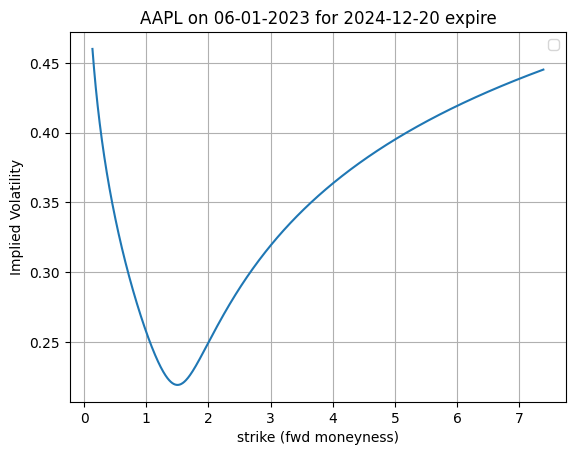

In [54]:
x = np.linspace(-2,2,1000)
w = np.linspace(0,0,len(x))
set_param_raw = Implied_Volatility_without_extrapolation['implied_volatility_surface'][18]['set_param_raw']
t = Implied_Volatility_without_extrapolation['implied_volatility_surface'][18]['expiry_date_in_act365_year_fraction']
for ind, i in enumerate(x):
    w[ind]= set_param_raw.a + set_param_raw.b*(set_param_raw.rho*(i-set_param_raw.m) + np.sqrt((i-set_param_raw.m)**2 + set_param_raw.sigma**2))
w = np.sqrt(w / t)
plt.plot(np.exp(x), w)
plt.title(ticker + ' on 06-01-2023 for 2024-12-20 expire')
plt.xlabel(r'strike (fwd moneyness)')
plt.ylabel(r'Implied Volatility')
plt.legend()
plt.grid()
plt.show()

####  Calendar arbitrage
$C(T_1,K) > C(T_2,K),\:for\:some\ T_1 < T_2\:and\:K > 0$
Then we can get arbitrage by selling the option call $(T1;K)$ and buying the option call $(T2;K)$

Calendar arbitrage is absence if and only if $\partial_t W(x,t) \geqslant 0$, where $W(x,t) -$ total implied varience, $x \in \mathbb{R}$ 

It means that no one total variance curves aren't cross. Follow graph show this crosdering

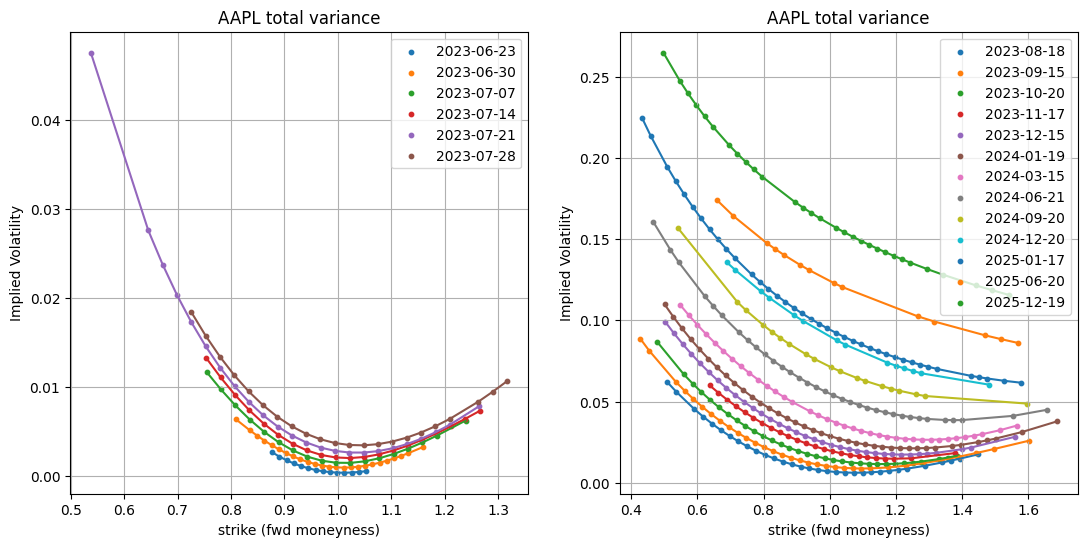

In [58]:
lines_2D_total_varience(ticker, Implied_Volatility_without_extrapolation, 13)

#### butterflies arbitrage:
$C(T,K_1) + C(T,K_3) < 2C(T,K_2)$ ,some $ K_1 < K_2 < K_3 $ and $ T > 0$

We can buy one call option $(T,K_1)$ and one $(T,K_3)$ and sell two call option $(T,K_2)$ Butterflies arbitrage is absence if and only if g-function from "Arbitrage-free SVI volatility surfaces" by Jim Gatheral and Antoine Jacquiery is positive

g-function:  $g(x) := \left(1 - \frac{xw'(x)}{2w(x)}\right)^2 - \frac{w'(x)^2}{4} \left(\frac{1}{w(x)} + \frac{1}{4}\right) + \frac{w''(x)}{2}$

In [22]:
def get_g_function_for_butterfly_arbitrage(data_dict, expiry_date, graph=None, N=1000, right_limit = 3):
    set_param = data_dict['implied_volatility_surface'][expiry_date]['set_param_raw'] # calibrated parameters
    expiry_date = data_dict['implied_volatility_surface'][expiry_date]['expiry_date'] # expiration date
    k = np.log(np.linspace(0.1, right_limit,N)) # log - moneyness
    w_k = np.linspace(0,0,N) # total varience
    for ind,i in enumerate(k):
        w_k[ind] = set_param.a + set_param.b * (set_param.rho * (i - set_param.m) + np.sqrt((i - set_param.m) ** 2 + set_param.sigma ** 2))
    w_k_first = np.linspace(0,0,len(w_k)) # first derivatives by the strike 
    w_k_second = np.linspace(0,0,len(w_k))# second derivatives by the strike 
    g_k = np.linspace(0,0,len(w_k))
    # compute necessary data
    for i in range(0, len(w_k) - 2):
        w_k_first[i+1] = (w_k[i+2] - w_k[i]) / (k[i+2] - k[i])
        w_k_second[i+1] = (w_k[i+2] - 2 * w_k[i+1] + w_k[i]) / (k[i+2] - k[i]) ** 2
    w_k_first[0] = (w_k[1] - w_k[0]) / (k[1] - k[0])
    w_k_second[0] = (w_k[1] - w_k[0]) / (k[1] - k[0])
    w_k_first[len(w_k)-1] = (w_k[len(w_k)-1] - w_k[len(w_k)-2]) / (k[len(w_k)-1] - k[len(w_k)-2])
    w_k_second[len(w_k)-1] = (w_k[len(w_k)-1] - w_k[len(w_k)-2]) / (k[len(w_k)-1] - k[len(w_k)-2])
    
    # compute g-function
    for i in range(0, len(w_k)):
        g_k[i] = (1 - k[i] * w_k_first[i] / 2 / w_k[i]) ** 2 - w_k_first[i] ** 2 / 4 * (1 / w_k[i] + 1 / 4) + w_k_second[i] / 2
        g_k[0] = g_k[1]
        g_k[-1] = g_k[-2]
    
    if graph:
        fig = plt.figure(figsize=(13, 6))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.plot(k,w_k)
        ax2.plot(k,g_k)

        ax1.set_title(expiry_date + ' Total implied variance from SVI')
        ax1.set_xlabel(r'log moneyness)')
        ax1.set_ylabel(r'Total implied variance')
        ax1.grid()
        ax2.set_title(expiry_date + ' g-function from SVI')
        ax2.set_xlabel(r'log moneyness')
        ax2.set_ylabel(r'function g')
        ax2.grid()
        plt.show()
    return g_k

In [9]:
def get_g_function_for_butterfly_arbitrage(data_dict, expiry_date, graph=None, N=1000, right_limit = 3):
    set_param = data_dict['implied_volatility_surface'][expiry_date]['set_param_raw'] # calibrated parameters
    expiry_date = data_dict['implied_volatility_surface'][expiry_date]['expiry_date'] # expiration date
    k = np.log(np.linspace(0.1, right_limit,N)) # log - moneyness
    w_k = np.linspace(0,0,N) # total varience
    for ind,i in enumerate(k):
        w_k[ind] = set_param.a + set_param.b * (set_param.rho * (i - set_param.m) + np.sqrt((i - set_param.m) ** 2 + set_param.sigma ** 2))
    w_k_first = np.linspace(0,0,len(w_k)) # first derivatives by the strike 
    w_k_second = np.linspace(0,0,len(w_k))# second derivatives by the strike 
    g_k = np.linspace(0,0,len(w_k))
    # compute necessary data
    for i in range(0, len(w_k) - 2):
        w_k_first[i+1] = (w_k[i+2] - w_k[i]) / (k[i+2] - k[i])
        w_k_second[i+1] = (w_k[i+2] - 2 * w_k[i+1] + w_k[i]) / (k[i+2] - k[i]) ** 2
    w_k_first[0] = (w_k[1] - w_k[0]) / (k[1] - k[0])
    w_k_second[0] = (w_k[1] - w_k[0]) / (k[1] - k[0])
    w_k_first[len(w_k)-1] = (w_k[len(w_k)-1] - w_k[len(w_k)-2]) / (k[len(w_k)-1] - k[len(w_k)-2])
    w_k_second[len(w_k)-1] = (w_k[len(w_k)-1] - w_k[len(w_k)-2]) / (k[len(w_k)-1] - k[len(w_k)-2])
    
    # compute g-function
    for i in range(0, len(w_k)):
        g_k[i] = (1 - k[i] * w_k_first[i] / 2 / w_k[i]) ** 2 - w_k_first[i] ** 2 / 4 * (1 / w_k[i] + 1 / 4) + w_k_second[i] / 2
        g_k[0] = g_k[1]
        g_k[-1] = g_k[-2]
    
    if graph:
        fig = plt.figure(figsize=(13, 6))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.plot(k,w_k)
        ax2.plot(k,g_k)

        ax1.set_title(expiry_date + ' total implied variance from SVI')
        ax1.set_xlabel(r'log moneyness)')
        ax1.set_ylabel(r'Total implied variance')
        ax1.grid()
        ax2.set_title(expiry_date + ' g-function from SVI')
        ax2.set_xlabel(r'log moneyness')
        ax2.set_ylabel(r'function g')
        ax2.grid()
        plt.show()
    return g_k

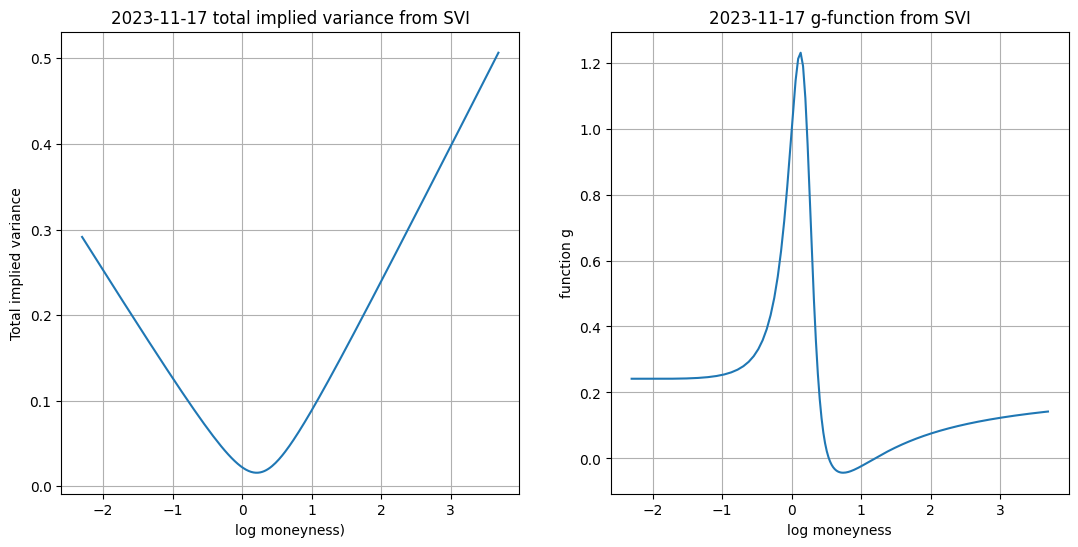

In [21]:
g_k = get_g_function_for_butterfly_arbitrage(Implied_Volatility_without_extrapolation, 10, graph=True, N=1000, right_limit = 40)

In [39]:
from dataclasses import dataclass
from math import *
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
@dataclass
class SVI:
    a: float
    b: float
    rho: float
    m: float
    sigma: float


    


In [52]:
def get_SVI_raw_bla(self, x):
    return self.a + self.b*(self.rho*(x-self.m) +np.sqrt((x-self.m)**2 + self.sigma**2))

def durrleman_function(self, x):
        w = get_SVI_raw_bla(self, x)
        wp = self.b*(self.rho + (x-self.m) / np.sqrt(
            (x-self.m)**2 + self.sigma**2))
        wpp = self.b*(1/np.sqrt((x-self.m)**2 + self.sigma**2) -
                      (x-self.m)**2/((x-self.m)**2 + self.sigma**2)**1.5)
        return (1-0.5*x*wp/w)**2 - 0.25*wp**2*(1/w+0.25) + 0.5*wpp
    
def get_but_free_arb_curve(S, X):    
    def f(y, x):
        w, w_first = y
        return [w_first, 2*max(durrleman_function(S, x), 0) + 0.5*(w_first)**2*(1/w+0.25) - 2*(1-0.5*x*w_first/w)**2]
    y0 = [get_SVI_raw_bla(S,X[0]), (get_SVI_raw_bla(S,X[1])-get_SVI_raw_bla(S,X[0]))/(X[1]-X[0])]
    sol = odeint(f, y0, X)
    return sol[:,0]

In [33]:
S = Implied_Volatility_without_extrapolation['implied_volatility_surface'][10]['set_param_raw']
X_first = Implied_Volatility_without_extrapolation['implied_volatility_surface'][10]['strikes'][0] / Implied_Volatility_without_extrapolation['implied_volatility_surface'][10]['reference_forward']
X_last = Implied_Volatility_without_extrapolation['implied_volatility_surface'][10]['strikes'][-1] / Implied_Volatility_without_extrapolation['implied_volatility_surface'][10]['reference_forward']
X = np.linspace(np.log(X_first), np.log(X_last), 10000)

In [53]:
w_old = []
for i in X:

In [54]:
New_w = get_but_free_arb_curve(S, X)

In [58]:
New_w

array([0.06935883, 0.06935017, 0.0693415 , ..., 0.01634058, 0.01634198,
       0.01634338])

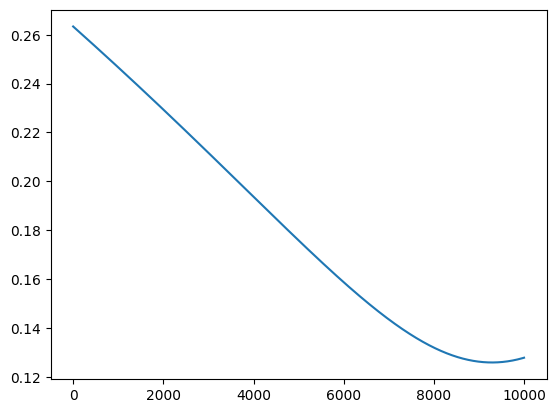

In [57]:
plt.plot(np.sqrt(New_w))

In [11]:
for k in Implied_Volatility_without_extrapolation['implied_volatility_surface']:        
    set_param = k['set_param_raw']
    print(k['expiry_date'])
    print(set_param.b * (1 + set_param.rho))
    

2023-06-23
0.059317173659111135
2023-06-30
0.05351903150293824
2023-07-07
0.06269819570550424
2023-07-14
0.07167616208661122
2023-07-21
0.3145552813015816
2023-07-28
0.17348310229589078
2023-08-18
0.14226194787551072
2023-09-15
0.12322473723751091
2023-10-20
0.23648240256701963
2023-11-17
0.23915503740915112
2023-12-15
0.3251165408330646
2024-01-19
0.3869858403816062
2024-03-15
0.23193296239954225
2024-06-21
0.32385629254241927
2024-09-20
0.25073505407334884
2024-12-20
0.08959936588335098
2025-01-17
0.18115088223114
2025-06-20
1.354194760110033e-16
2025-12-19
0.0


Follow have shown computing option prices via implied volatility from SVI model and comparing them with initial bid ask spread. Error graph shows that option prices within bid ask spread, grey is inside bid ask spread, above means higher, below means lower. 

In [ ]:
value_options = get_data_about_option(Implied_Volatility_without_extrapolation, options_data, optionTypes=None) # Only for those strikes for which contracts were traded on the last trade day

In [ ]:
# %timeit get_data_about_option(Implied_Volatility_without_extrapolation, filename_for_option_chain, optionTypes=None, amount_options=None)

In [ ]:
print('number options for all curves inside of bid ask spread =', len(value_options.loc[value_options['correct_price'] == 'inside']) / len(value_options) * 100, '%')
print('number options for all curves strikes above of bid ask spread =', len(value_options.loc[value_options['correct_price'] == 'above']) / len(value_options) * 100, '%')
print('number options for all curves strikes below of bid ask spread =', len(value_options.loc[value_options['correct_price'] == 'below']) / len(value_options) * 100, '%')

In [ ]:
error_graph_3D(value_options, ticker, data_date, type_option=None)

In [ ]:
error_graph_3D(value_options, ticker, data_date, type_option='OTM')

In [ ]:
error_graph_3D(value_options, ticker, data_date, type_option='ITM')

Checking the static arbitrage for given curves

In [33]:
check_static_arbitrage(value_options, Implied_Volatility_without_extrapolation)


calandar arbitrage exists
butterfly arbitrage exists


In [34]:
calendar_arbitrage = check_calendar_arbitrage(value_options)
if calendar_arbitrage.empty:
    print('calendar arbitrage is absence')
else:
    print('calendar arbitrage exists')

calendar arbitrage exists


In [36]:
# only OTM options
for expiry_date in value_options['expiry_date'].unique():
    value_options_check  = value_options.loc[(value_options['expiry_date'] == expiry_date)]
    value_options_check = value_options_check.loc[((value_options_check["x_grid"] >= 1) & (value_options_check["optionType"] == "calls")) | ((value_options_check["x_grid"] < 1) & (value_options_check["optionType"] == 'puts'))]
    print('number options within bid ask spread for only OTM options on', expiry_date, ' =', len(value_options_check.loc[(value_options_check['correct_price'] == 'inside')]) / len(value_options_check) * 100, '%')

number options within bid ask spread for only OTM options on 2023-06-09  = 82.78688524590164 %
number options within bid ask spread for only OTM options on 2023-06-12  = 88.07339449541286 %
number options within bid ask spread for only OTM options on 2023-06-13  = 82.72727272727273 %
number options within bid ask spread for only OTM options on 2023-06-14  = 95.28301886792453 %
number options within bid ask spread for only OTM options on 2023-06-15  = 100.0 %
number options within bid ask spread for only OTM options on 2023-06-16  = 88.46153846153845 %
number options within bid ask spread for only OTM options on 2023-06-20  = 99.01960784313727 %
number options within bid ask spread for only OTM options on 2023-06-21  = 98.13084112149532 %
number options within bid ask spread for only OTM options on 2023-06-22  = 97.87234042553192 %
number options within bid ask spread for only OTM options on 2023-06-23  = 82.16560509554141 %
number options within bid ask spread for only OTM options on 2

In [37]:
for i, expiry_date in enumerate(value_options['expiry_date'].unique()):
    k = value_options.loc[value_options['expiry_date'] == expiry_date]
    print('nubmer contracts within bid ask on', expiry_date, '=', len(k.loc[k['correct_price'] == 'inside']) / len(k) * 100, '%')
    print('nubmer contracts on', expiry_date, '=', len(k))
    print('reference_forward = ', Implied_Volatility['implied_volatility_surface'][i]['reference_forward'])
    print('Time = ', Implied_Volatility['implied_volatility_surface'][i]['expiry_date_in_act365_year_fraction'])
    print('discount factor =', Implied_Volatility['implied_volatility_surface'][i]['reference_discount_factor'])
    below = k.loc[k['correct_price'] == 'below']
    above = k.loc[k['correct_price'] == 'above']
    print('mean relative error for options below bid ask spread on', expiry_date,'=', ((below.bid - below.value_option) / below.bid).mean() * 100, '%')
    print('mean relative error for options above bid ask spread on', expiry_date,'=', ((above.value_option - above.ask) / above.ask).mean() * 100, '%')
    print()

nubmer contracts within bid ask on 2023-06-09 = 83.85826771653542 %
nubmer contracts on 2023-06-09 = 254
reference_forward =  4271.600586996065
Time =  0.0027397260273972603
discount factor = 1.0001431697721148
mean relative error for options below bid ask spread on 2023-06-09 = 3.203253947391898 %
mean relative error for options above bid ask spread on 2023-06-09 = 13.281133493414934 %

nubmer contracts within bid ask on 2023-06-12 = 92.82296650717703 %
nubmer contracts on 2023-06-12 = 209
reference_forward =  4272.302752027923
Time =  0.010958904109589041
discount factor = 1.0005733391506648
mean relative error for options below bid ask spread on 2023-06-12 = 2.4597477945144197 %
mean relative error for options above bid ask spread on 2023-06-12 = 11.405369478939352 %

nubmer contracts within bid ask on 2023-06-13 = 89.28571428571429 %
nubmer contracts on 2023-06-13 = 196
reference_forward =  4272.725161313548
Time =  0.0136986301369863
discount factor = 1.0007169491023464
mean relat

In [26]:
def get_SVI_extrapolation(data_dict, expire_time, start_v, start_v_tilda, end_psi, start_c, start_p, number_droped_maturities_in_begin=0, number_droped_maturities_in_end=0, type_reggresion='linear', plot_graph = False):
            
    a_new, b_new, rho_new, m_new, sigma_new = get_param_for_extrapolate(data_dict, expire_time, start_v, start_v_tilda, end_psi, start_c, start_p, number_droped_maturities_in_begin, number_droped_maturities_in_end, type_reggresion,plot_graph)
    
#     print('a=', a_new)
#     print('b=', b_new)
#     print('rho=', rho_new)
#     print('m=', m_new)
#     print('sigma=', sigma_new)
    k = data_dict['implied_volatility_surface'][-1]
    x = np.log(k['strikes'] / k['reference_forward'])
    w_volatility = np.linspace(0,0,len(x))
    for ind, i in enumerate(x):
        w_volatility[ind] = get_w_SVI_raw(a_new, b_new, rho_new, m_new, sigma_new, i)
    w_volatility = np.sqrt(w_volatility / k['expiry_date_in_act365_year_fraction'])
    return a_new, b_new, rho_new, m_new, sigma_new, w_volatility

def get_param_for_extrapolate(data_dict, expire_time, start_v, start_v_tilda, end_psi, start_c, start_p, number_droped_maturities_in_begin=0, number_droped_maturities_in_end=0, type_reggresion='linear', plot_graph=False):
    w, v, psi, p, c, v_tilda = get_jump_wing_param(data_dict, number_droped_maturities_in_begin, number_droped_maturities_in_end)
    time_fraction = []
    for i in range(number_droped_maturities_in_begin, len(data_dict['implied_volatility_surface']) - number_droped_maturities_in_end):
        time_fraction.append(data_dict['implied_volatility_surface'][i]['expiry_date_in_act365_year_fraction'])
    time_fraction = np.array(time_fraction)
    
    if type_reggresion == 'polynomial':
    
        #compute v
        v1 = []
        time = []
        for i in range(start_v, len(v)):
            v1.append(v[i])
            time.append(time_fraction[i])
        time = np.array(time)
        model_coef = np.poly1d(np.polyfit(np.log(time), v1, 2))
        v_new = model_coef(np.log(expire_time))

        #compute v_tilda
        v_tilda[len(v_tilda)-1] = v_tilda[len(v_tilda) -2]
        dif = v[len(v_tilda)-5] - v_tilda[len(v_tilda)-5]
        v_tilda[len(v_tilda)-4] = v[len(v_tilda)-4] - dif
        v_tilda[len(v_tilda)-3] = v[len(v_tilda)-3] - dif
        v_tilda[len(v_tilda)-2] = v[len(v_tilda)-2] - dif
        v_tilda[len(v_tilda)-1] = v[len(v_tilda)-1] - dif
        
        v1 = []
        time = []
        for i in range(start_v_tilda, len(v_tilda)):
            v1.append(v_tilda[i])
            time.append(time_fraction[i])
        time = np.array(time)
        model_coef = np.poly1d(np.polyfit(np.log(time), v1, 2))
        v_tilda_new = model_coef(np.log(expire_time))

        #compute psi
        psi1 = []
        time = []
        for i in range(len(psi)-end_psi, len(psi)):
            psi1.append(psi[i])
            time.append(time_fraction[i])
        time = np.array(time)
        model_coef = np.poly1d(np.polyfit(np.log(time), psi1, 1))
        psi_new = model_coef(np.log(expire_time))

        #compute c
        c1 = []
        time = []

        for i in range(start_c, len(c)):
            c1.append(c[i])
            time.append(time_fraction[i])
        time = np.array(time)

        model_coef = np.poly1d(np.polyfit(np.log(time), c1, 1))
        c_new = model_coef(np.log(expire_time))

        #compute p
        p1 = []
        time = []

        for i in range(start_p, len(p)):
            p1.append(p[i])
            time.append(time_fraction[i])
        time = np.array(time)

        model_coef = np.poly1d(np.polyfit(np.log(time), p1, 1))
        p_new = model_coef(np.log(expire_time))
        if plot_graph:
            graph_for_polynomial_regression(data_dict, v, v_tilda, psi, c,p, time_fraction, expire_time, start_v, start_v_tilda, end_psi, start_c, start_p)
    
#     print(v_new, v_tilda_new, psi_new, c_new, p_new)
    w = v_new * expire_time
#     print(w)
    b = 0.5 * np.sqrt(w)*(c_new+p_new)
#     print('b =', b)
    rho = 1 - 2*p_new/(c_new+p_new)
    beta = rho - 2*psi_new*np.sqrt(w)/b
#     print('beta =', beta)
    
    if np.abs(beta) > 1:
        return "error"
    elif beta == 0:
        m = 0
        sigma = (v_new-v_tilda_new)*expire_time / (b*(1-np.sqrt(1-rho**2)))
    else:
        alpha = np.sign(beta) * np.sqrt(1/beta**2 - 1)
        
        m = (v_new-v_tilda_new)*expire_time / (b*(-rho+np.sign(alpha)*np.sqrt(1+alpha**2) -
                                    alpha*np.sqrt(1-rho**2)))
        sigma = alpha*m

    a = v_tilda_new*expire_time - b*sigma*np.sqrt(1-rho**2)   
    return a, b, rho, m, sigma

def get_w_SVI_raw(a_new, b_new, rho_new, m_new, sigma_new, x):
    return a_new + b_new *(rho_new *(x-m_new) + np.sqrt((x-m_new)**2 + sigma_new**2))


In [31]:
def graph_for_polynomial_regression(data_dict, v, v_tilda, psi, c,p, time_fraction, expire_time, start_v, start_v_tilda, end_psi, start_c, start_p):
    
    ticker = data_dict['underlying_ticker']
    data_date = str(data_dict['data_date'].date())
    fig = plt.figure(figsize=(10,8))
    
    #compute v
    v1 = []
    time = []
    for i in range(start_v, len(v)):
        v1.append(v[i])
        time.append(time_fraction[i])
    time = np.array(time)
    model_coef = np.poly1d(np.polyfit(np.log(time), v1, 2))
    plt.scatter(time, v1, s=50)
    plt.plot(np.append(time, expire_time), model_coef(np.log(np.append(time, expire_time))), 'r')
    plt.title('ATM volatility from Jump Wing  (v)')
    plt.xlabel(r'maturity')
    plt.ylabel(r'value')
    plt.grid()
    plt.show()

    fig = plt.figure(figsize=(10,8))
    #compute v_tilda
    v1 = []
    time = []
    for i in range(start_v_tilda, len(v_tilda)):
        v1.append(v_tilda[i])
        time.append(time_fraction[i])
    time = np.array(time)
    model_coef = np.poly1d(np.polyfit(np.log(time), v1, 2))
    plt.scatter(time, v1, s=50)
    plt.plot(np.append(time, expire_time), model_coef(np.log(np.append(time, expire_time))), 'r')
    plt.title('minimum implied volatility from Jump Wing (v_tilda)')
    plt.xlabel(r'maturity')
    plt.ylabel(r'value')
    plt.grid()
    plt.show()
    

    fig = plt.figure(figsize=(10,8))
    #compute psi
    psi1 = []
    time = []
    for i in range(len(psi)-end_psi, len(psi)):
        psi1.append(psi[i])
        time.append(time_fraction[i])
    time = np.array(time)
    model_coef = np.poly1d(np.polyfit(np.log(time), psi1, 1))
    plt.scatter(time,psi1, s=50)
    plt.plot(np.append(time, expire_time), model_coef(np.log(np.append(time, expire_time))), 'r')
    plt.title('ATM skew from Jump Wing (psi) for)')
    plt.xlabel(r'maturity')
    plt.ylabel(r'value')
    plt.grid()
    plt.show()
    
    fig = plt.figure(figsize=(10,8))
    #compute c
    c1 = []
    time = []
    for i in range(start_c, len(c)):
        c1.append(c[i])
        time.append(time_fraction[i])
    time = np.array(time)
    model_coef = np.poly1d(np.polyfit(np.log(time), c1, 1))
    plt.scatter(time,c1, s=50)
    plt.plot(np.append(time, expire_time), model_coef(np.log(np.append(time, expire_time))), 'r')
    plt.title('Slope right wing from Jump Wing (c)')
    plt.xlabel(r'maturity')
    plt.ylabel(r'value')
    plt.grid()
    plt.show()
    
    fig = plt.figure(figsize=(10,8))
    #compute p
    p1 = []
    time = []
    for i in range(start_p, len(p)):
        p1.append(p[i])
        time.append(time_fraction[i])
    time = np.array(time)
    model_coef = np.poly1d(np.polyfit(np.log(time), p1, 1))
    plt.scatter(time,p1, s=50)
    plt.plot(np.append(time, expire_time), model_coef(np.log(np.append(time, expire_time))), 'r')
    plt.title('Slope left wing from Jump Wing (p)')
    plt.xlabel(r'maturity')
    plt.ylabel(r'value')
    plt.grid()
    plt.show()



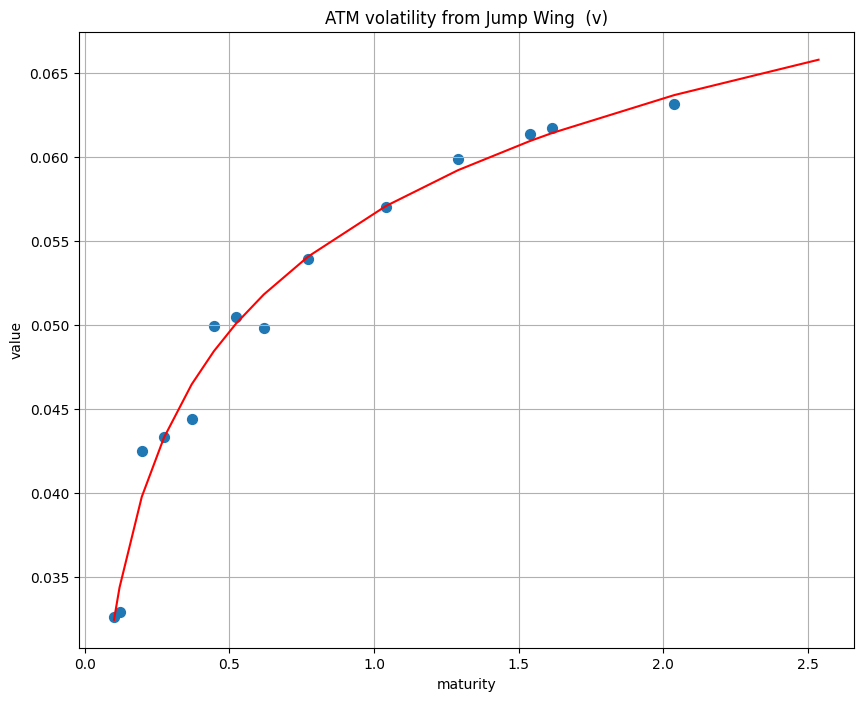

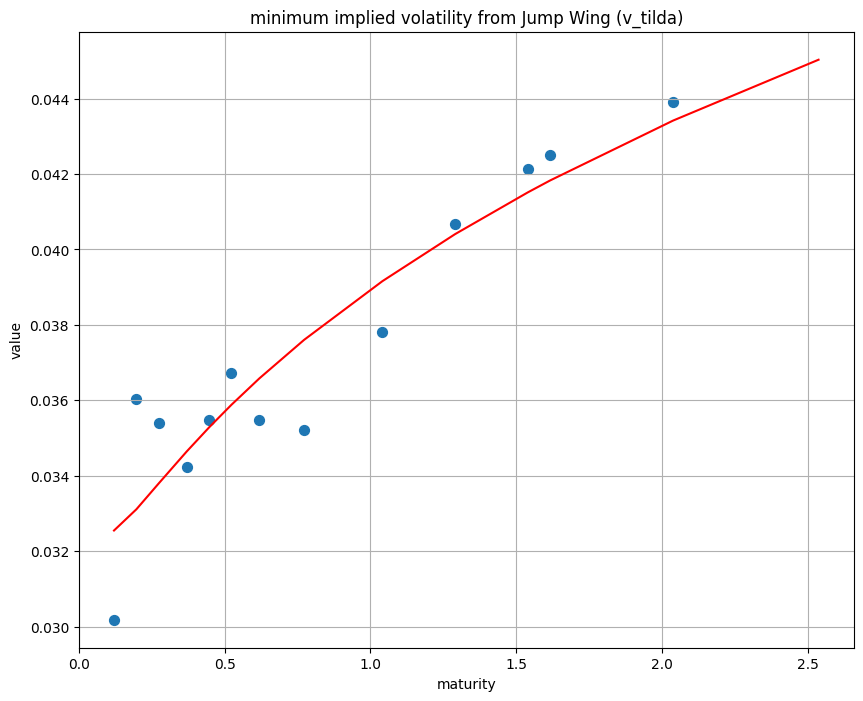

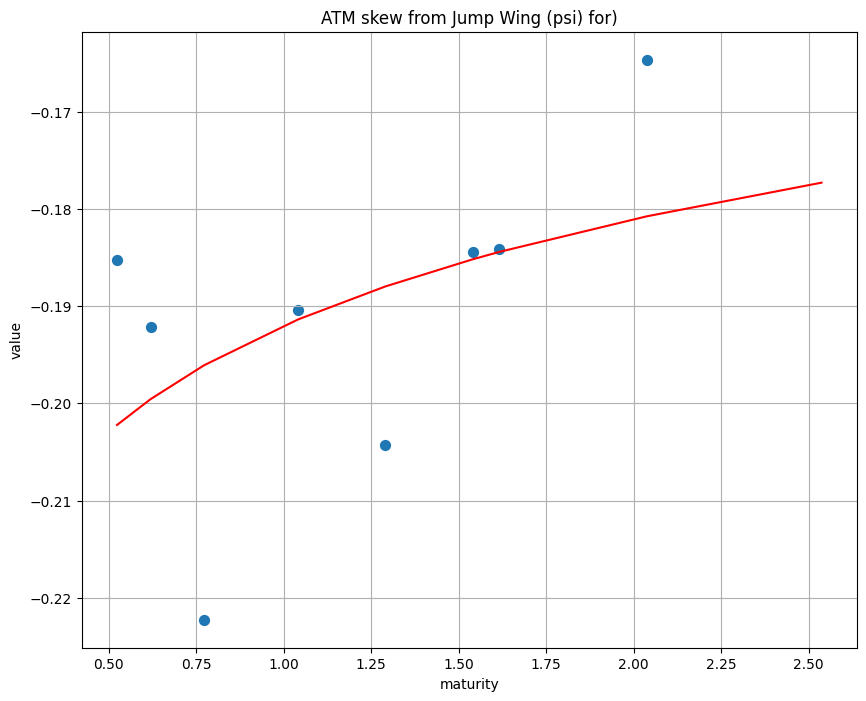

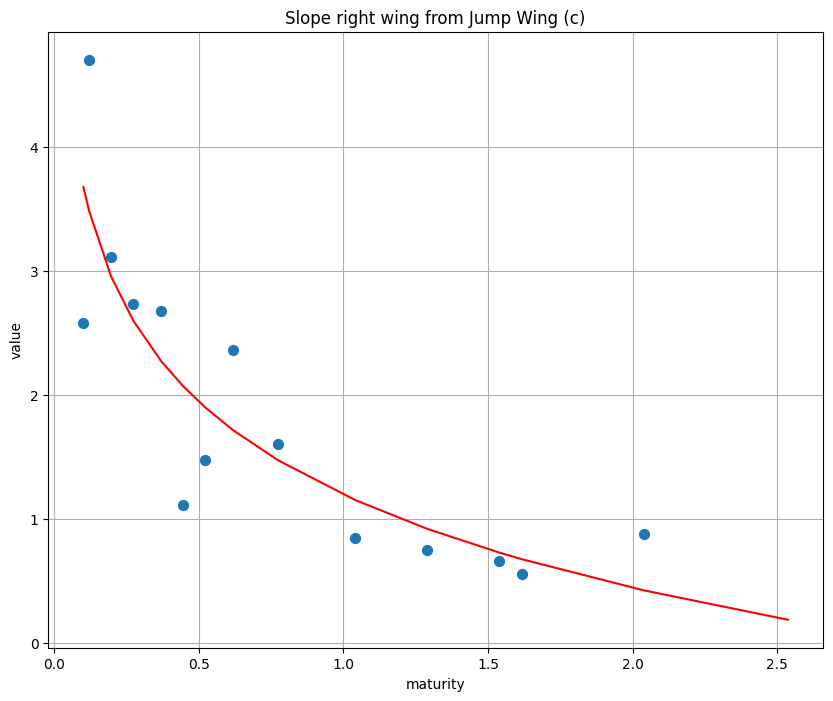

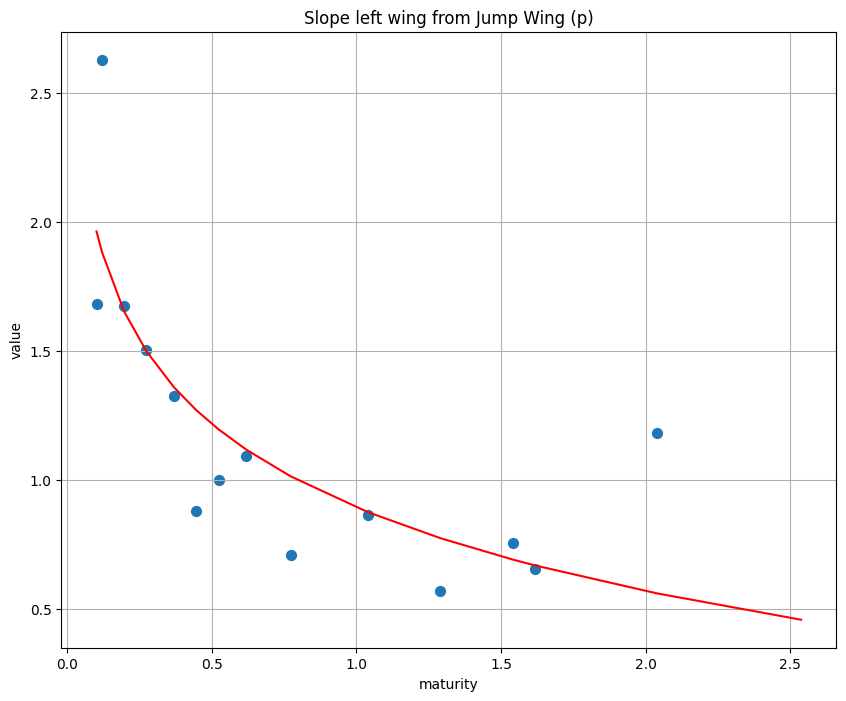

In [32]:
start_v = 5
start_v_tilda = 6
end_psi = 8
start_c = 5
start_p =5
timeteable = 19
expire_time = Implied_Volatility_without_extrapolation['implied_volatility_surface'][timeteable]['expiry_date_in_act365_year_fraction']
w_volatility = get_SVI_extrapolation(Implied_Volatility_without_extrapolation, expire_time, start_v, start_v_tilda, end_psi, start_c, start_p,0, 1, type_reggresion = 'polynomial', plot_graph = True)
# graph_for_polynomial_regression(Implied_Volatility_without_extrapolation, v, v_tilda, psi, c,p, expire_time, start_v, start_v_tilda, end_psi, start_c, start_p)

In [15]:
w, v, psi, p, c, v_tilda = get_jump_wing_param(Implied_Volatility_without_extrapolation)
curvature_put, curvature_call = get_curvature(Implied_Volatility_without_extrapolation)
vol_min, vol, skew_without_div, skew_with_div = get_skew(Implied_Volatility_without_extrapolation)

In [79]:
w1, v1, psi1, p1, c1, v_tilda1 = get_jump_wing_param(Implied_Volatility_without_extrapolation)
# curvature_put, curvature_call = get_curvature(Implied_Volatility_without_extrapolation)
# vol_min, vol, skew_without_div, skew_with_div = get_skew(Implied_Volatility_without_extrapolation)

In [99]:
w2, v2, psi2, p2, c2, v_tilda2 = get_jump_wing_param(Implied_Volatility_without_extrapolation)

In [106]:
w3, v3, psi3, p3, c3, v_tilda3 = get_jump_wing_param(Implied_Volatility_without_extrapolation)

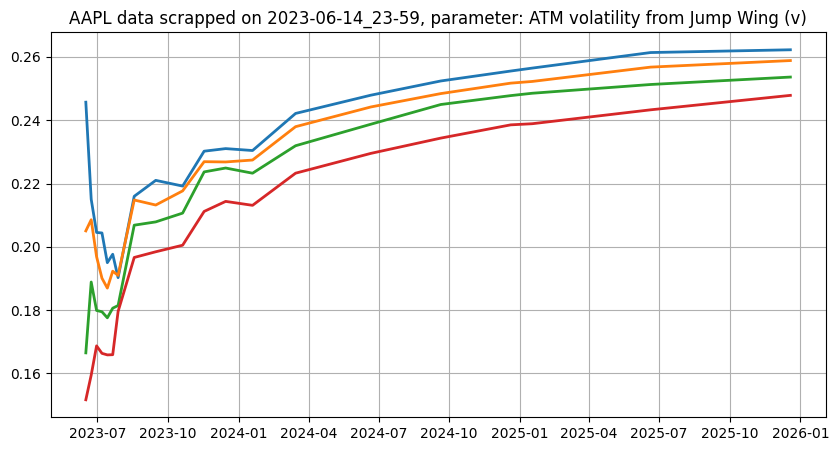

In [153]:
expiry_date_list= np.delete(options_data["expiryDate"].unique(), 0).astype('datetime64')
expiry_date_list= np.delete(expiry_date_list, 0).astype('datetime64')
expiry_date_list= options_data["expiryDate"].unique().astype('datetime64')
plt.figure(figsize = (10,5))
plt.plot(expiry_date_list, np.sqrt(v1), linewidth=2, label = '2023-06-05')
plt.plot(expiry_date_list, np.sqrt(v2), linewidth=2, label = '2023-06-07')
plt.plot(expiry_date_list, np.sqrt(v), linewidth=2, label = '2023-06-08')
plt.plot(expiry_date_list, np.sqrt(v3), linewidth=2, label = '2023-06-14')
plt.title(ticker + ' data scrapped on ' + data_date + ', parameter: ATM volatility from Jump Wing (v)')
plt.grid()

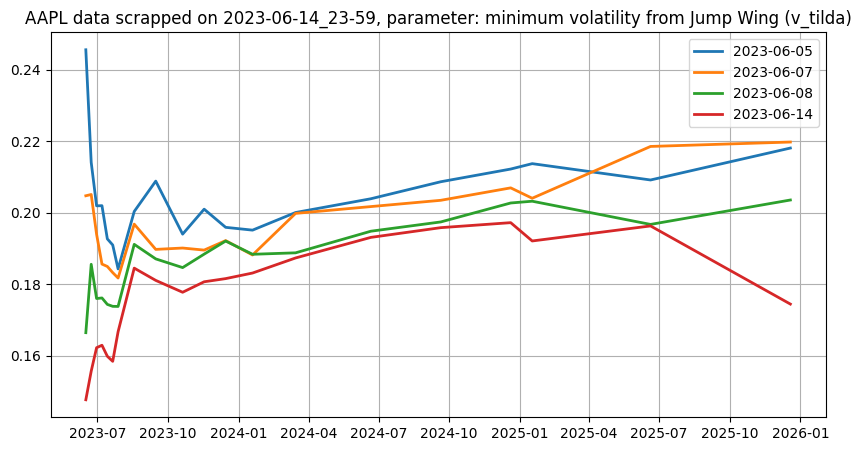

In [155]:
expiry_date_list= np.delete(options_data["expiryDate"].unique(), 0).astype('datetime64')
expiry_date_list= np.delete(expiry_date_list, 0).astype('datetime64')
expiry_date_list= options_data["expiryDate"].unique().astype('datetime64')
plt.figure(figsize = (10,5))
plt.plot(expiry_date_list, np.sqrt(v_tilda1), linewidth=2, label = '2023-06-05')
plt.plot(expiry_date_list, np.sqrt(v_tilda2), linewidth=2, label = '2023-06-07')
plt.plot(expiry_date_list, np.sqrt(v_tilda), linewidth=2, label = '2023-06-08')
plt.plot(expiry_date_list, np.sqrt(v_tilda3), linewidth=2, label = '2023-06-14')
plt.title(ticker + ' data scrapped on ' + data_date + ', parameter: minimum volatility from Jump Wing (v_tilda)')
plt.legend()
plt.grid()

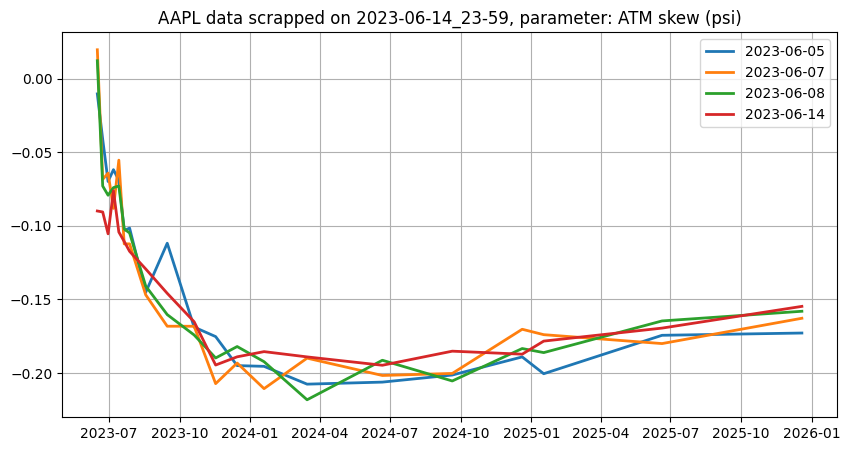

In [156]:
expiry_date_list= np.delete(options_data["expiryDate"].unique(), 0).astype('datetime64')
expiry_date_list= np.delete(expiry_date_list, 0).astype('datetime64')
expiry_date_list= options_data["expiryDate"].unique().astype('datetime64')
plt.figure(figsize = (10,5))
plt.plot(expiry_date_list, psi1, linewidth=2, label = '2023-06-05')
plt.plot(expiry_date_list, psi2, linewidth=2, label = '2023-06-07')
plt.plot(expiry_date_list, psi, linewidth=2, label = '2023-06-08')
plt.plot(expiry_date_list, psi3, linewidth=2, label = '2023-06-14')
plt.title(ticker + ' data scrapped on ' + data_date + ', parameter: ATM skew (psi)')
plt.legend()
plt.grid()

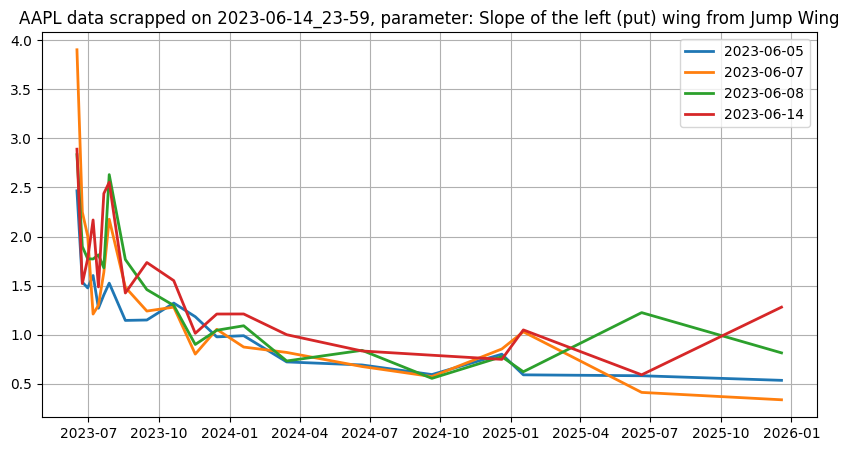

In [157]:
expiry_date_list= np.delete(options_data["expiryDate"].unique(), 0).astype('datetime64')
expiry_date_list= np.delete(expiry_date_list, 0).astype('datetime64')
expiry_date_list= options_data["expiryDate"].unique().astype('datetime64')
plt.figure(figsize = (10,5))
plt.plot(expiry_date_list, p1, linewidth=2, label = '2023-06-05')
plt.plot(expiry_date_list, p2, linewidth=2, label = '2023-06-07')
plt.plot(expiry_date_list, p, linewidth=2, label = '2023-06-08')
plt.plot(expiry_date_list, p3, linewidth=2, label = '2023-06-14')
plt.title(ticker + ' data scrapped on ' + data_date + ', parameter: Slope of the left (put) wing from Jump Wing')
plt.legend()
plt.grid()

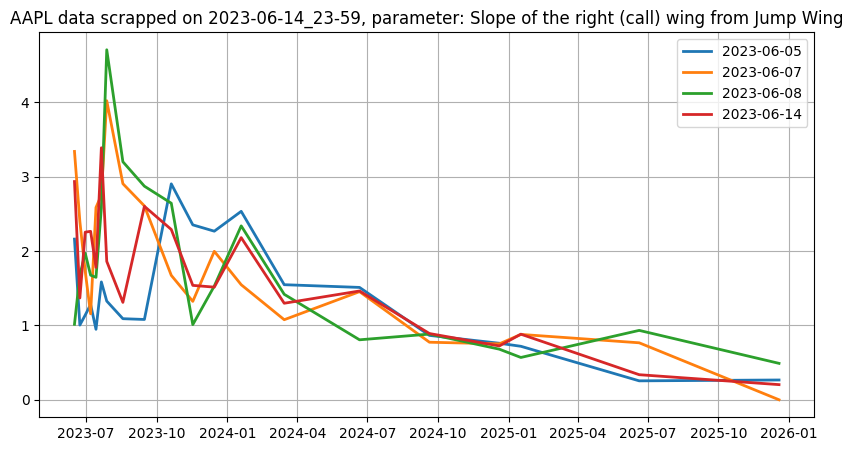

In [158]:
expiry_date_list= np.delete(options_data["expiryDate"].unique(), 0).astype('datetime64')
expiry_date_list= np.delete(expiry_date_list, 0).astype('datetime64')
expiry_date_list= options_data["expiryDate"].unique().astype('datetime64')
plt.figure(figsize = (10,5))
plt.plot(expiry_date_list, c1, linewidth=2, label = '2023-06-05')
plt.plot(expiry_date_list, c2, linewidth=2, label = '2023-06-07')
plt.plot(expiry_date_list, c, linewidth=2, label = '2023-06-08')
plt.plot(expiry_date_list, c3, linewidth=2, label = '2023-06-14')
plt.title(ticker + ' data scrapped on ' + data_date + ', parameter: Slope of the right (call) wing from Jump Wing')
plt.legend()
plt.grid()

In [34]:
a = []
b = []
rho = []
m = []
sigma = []
for k in Implied_Volatility_without_extrapolation['implied_volatility_surface']:
    set_par = k['set_param_raw']
    a.append(set_par.a)
    b.append(set_par.b)
    rho.append(set_par.rho)
    m.append(set_par.m)
    sigma.append(set_par.sigma)
    
    

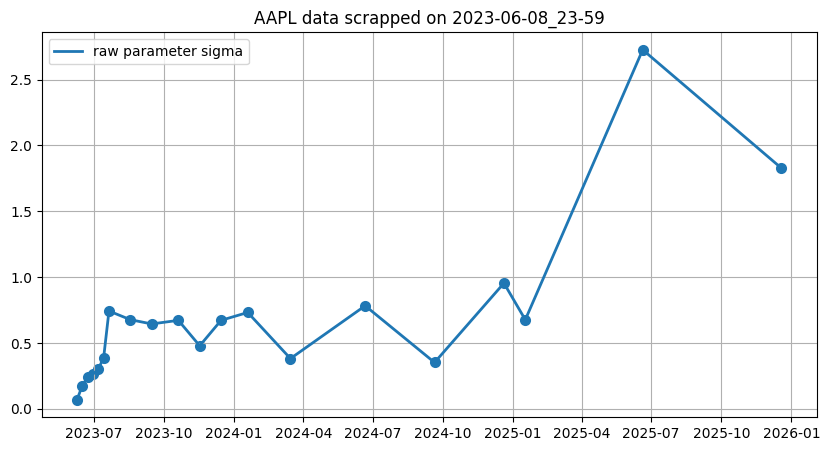

In [69]:
expiry_date_list= np.delete(options_data["expiryDate"].unique(), 0).astype('datetime64')
expiry_date_list= np.delete(expiry_date_list, 0).astype('datetime64')
expiry_date_list= options_data["expiryDate"].unique().astype('datetime64')
plt.figure(figsize = (10,5))
# plt.plot(expiry_date_list, m, linewidth=2, label =' raw parameter m')
# plt.plot(expiry_date_list, b, linewidth=2, label ='raw parameter b')
# plt.plot(expiry_date_list, rho, linewidth=2 , label ='raw parameter rho')
# plt.plot(expiry_date_list, a, linewidth=2 , label ='raw parameter a')
plt.plot(expiry_date_list, sigma, linewidth=2 , label ='raw parameter sigma')
# plt.plot(expiry_date_list, m, linewidth=2)
# plt.plot(expiry_date_list, sigma, linewidth=2)
# plt.plot(expiry_date_list, vol_min, label = 'minimum implied volatility ', linestyle='--', linewidth=2, color='g')
# plt.plot(expiry_date_list, vol, label = 'ATM volatility', linestyle='--', linewidth=2, color='b')
# plt.scatter(expiry_date_list, a, linewidth=2)
# plt.scatter(expiry_date_list, m, linewidth=2)
# plt.scatter(expiry_date_list, b, linewidth=2)
# plt.scatter(expiry_date_list, rho, linewidth=2)
# plt.scatter(expiry_date_list, a, linewidth=2)
plt.scatter(expiry_date_list, sigma, linewidth=2)
plt.title(ticker + ' data scrapped on ' + data_date)
plt.legend()
plt.grid()
plt.show()

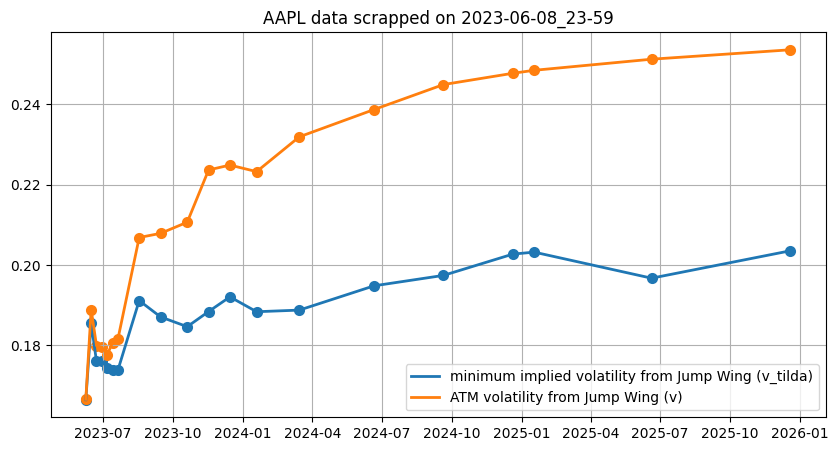

In [70]:
expiry_date_list= np.delete(options_data["expiryDate"].unique(), 0).astype('datetime64')
expiry_date_list= np.delete(expiry_date_list, 0).astype('datetime64')
expiry_date_list= options_data["expiryDate"].unique().astype('datetime64')
plt.figure(figsize = (10,5))
plt.plot(expiry_date_list, np.sqrt(v_tilda), label = 'minimum implied volatility from Jump Wing (v_tilda)', linewidth=2)
plt.plot(expiry_date_list, np.sqrt(v), label = 'ATM volatility from Jump Wing (v)', linewidth=2)
# plt.plot(expiry_date_list, vol_min, label = 'minimum implied volatility ', linestyle='--', linewidth=2, color='g')
# plt.plot(expiry_date_list, vol, label = 'ATM volatility', linestyle='--', linewidth=2, color='b')
plt.scatter(expiry_date_list, np.sqrt(v_tilda), linewidth=2)
plt.scatter(expiry_date_list, np.sqrt(v), linewidth=2)
plt.title(ticker + ' data scrapped on ' + data_date)
plt.legend()
plt.grid()
plt.show()

Mixon, Scott, What Does Implied Volatility Skew Measure? (May 1, 2010). The Journal of Derivatives Summer 2011, 18 (4) 9-25, https://doi.org/10.3905/jod.2011.18.4.009, Available at SSRN: https://ssrn.com/abstract=1618602 or http://dx.doi.org/10.2139/ssrn.1618602

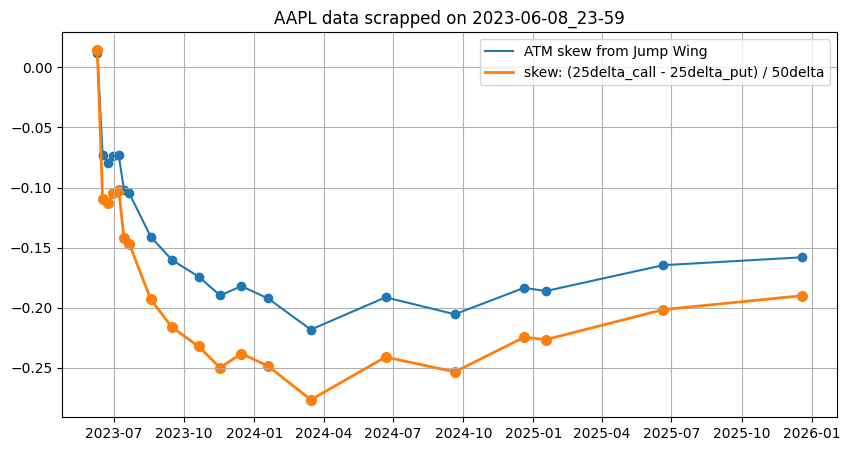

In [71]:
plt.figure(figsize = (10,5))
plt.plot(expiry_date_list, psi, label = 'ATM skew from Jump Wing')
plt.scatter(expiry_date_list, psi)
plt.plot(expiry_date_list, skew_with_div, label = 'skew: (25delta_call - 25delta_put) / 50delta', linewidth=2)
plt.scatter(expiry_date_list, skew_with_div, linewidth=2)
plt.title(ticker + ' data scrapped on ' + data_date)
plt.legend()
plt.grid()
plt.show()

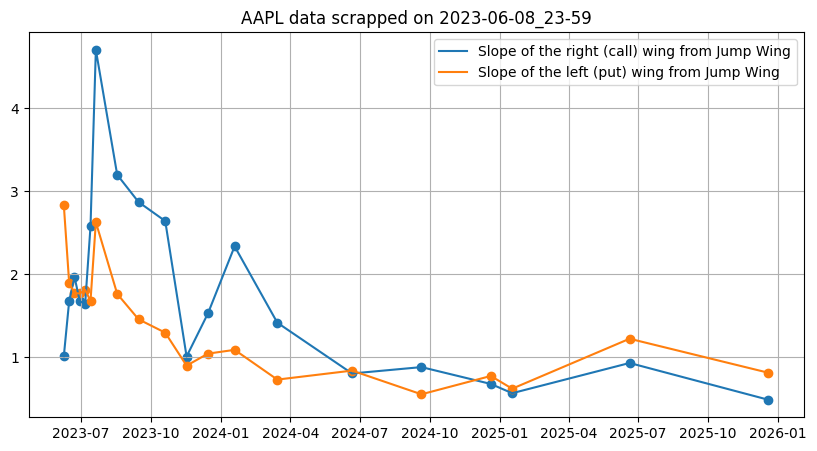

In [73]:
plt.figure(figsize = (10,5))
plt.plot(expiry_date_list, c, label = 'Slope of the right (call) wing from Jump Wing' )
plt.plot(expiry_date_list, p, label = 'Slope of the left (put) wing from Jump Wing')
plt.scatter(expiry_date_list, c)
plt.scatter(expiry_date_list, p)
plt.title(ticker + ' data scrapped on ' + data_date)
plt.legend()
plt.grid()
plt.show()

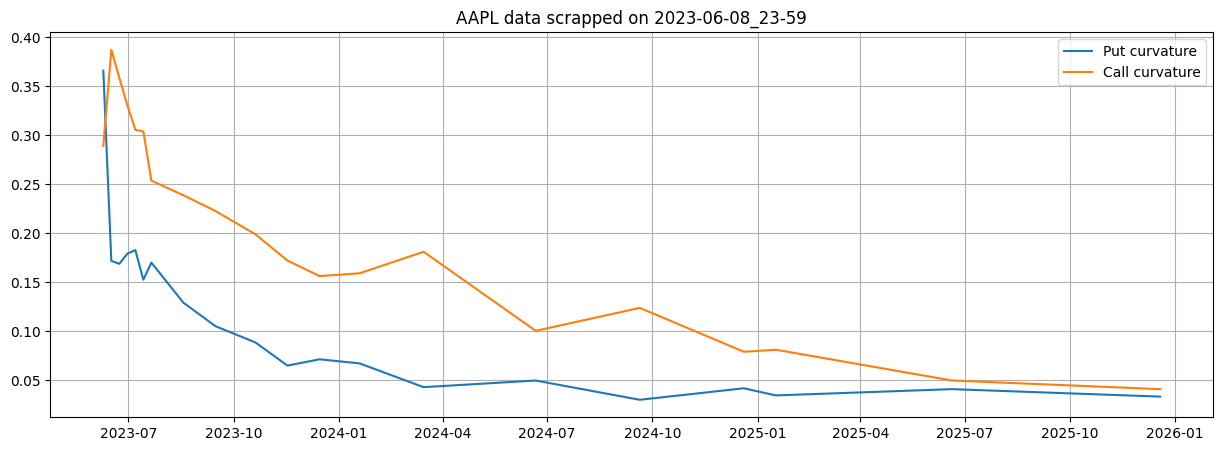

In [14]:
plt.figure(figsize = (15,5))
plt.plot(expiry_date_list, curvature_put, label='Put curvature')
plt.plot(expiry_date_list, curvature_call, label='Call curvature')
plt.title(ticker + ' data scrapped on ' + data_date)
plt.legend()
plt.grid()
plt.show()

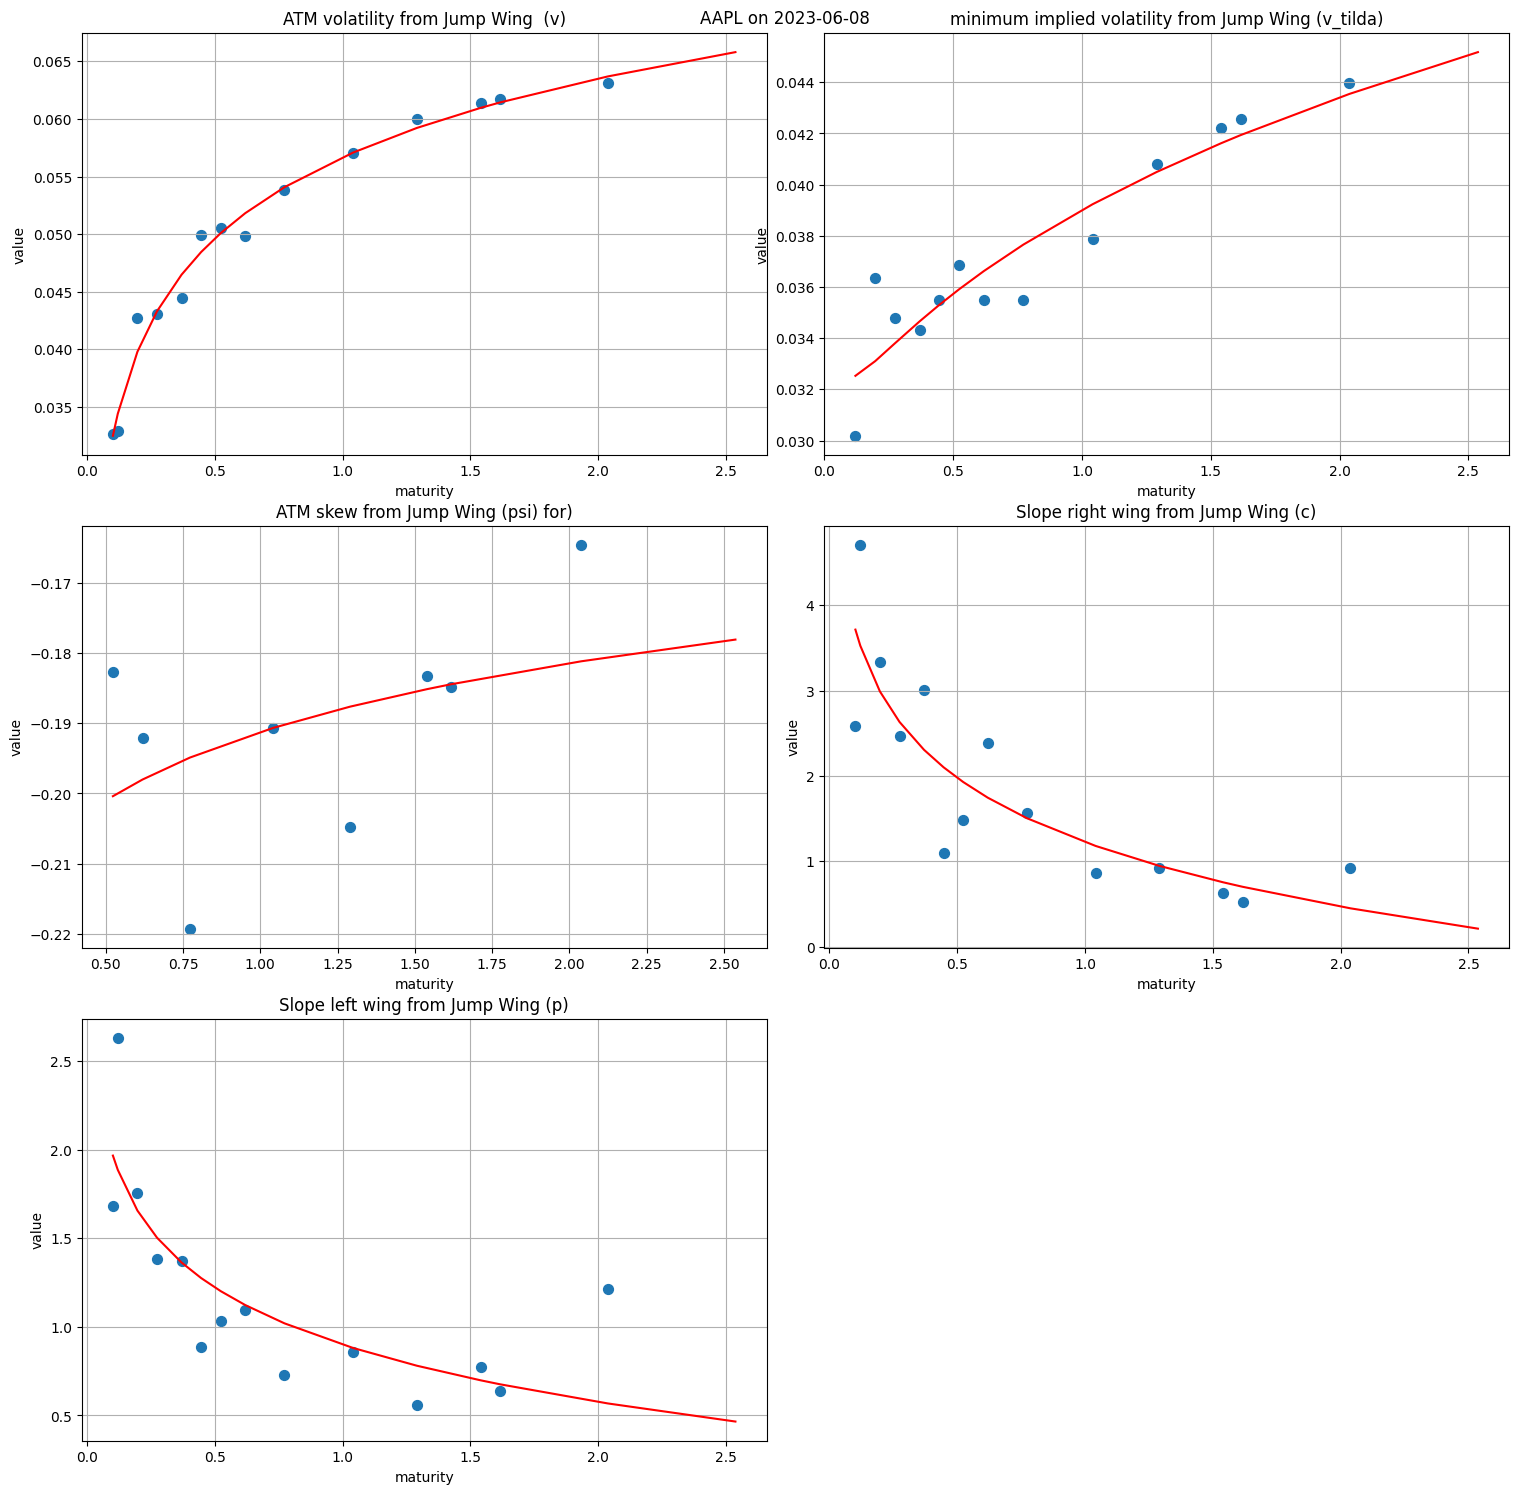

0.06579738966315704 0.045177727126925665 -0.17807546146878817 0.21118336250561276 0.46581382168178
0.16692707624132444
b = 0.1382993885561757
beta = 0.6760314479717275
a= 0.05211902812098556
b= 0.1382993885561757
rho= -0.37611745679829234
m= 0.4474339121175937
sigma= 0.48770196692303175


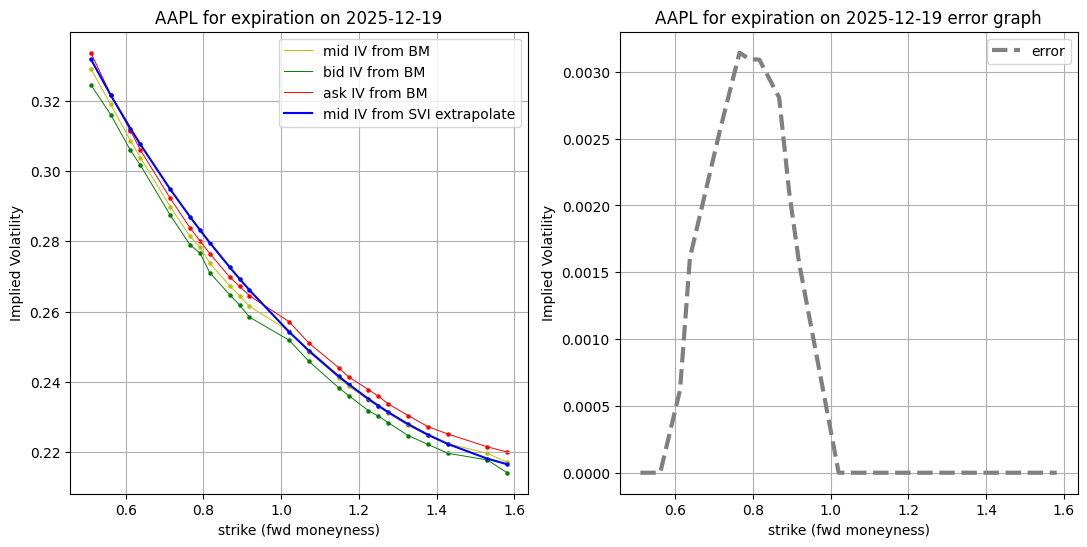

In [165]:
start_v = 5
start_v_tilda = 6
end_psi = 8
start_c = 5
start_p =5
timeteable = 19
expire_time = Implied_Volatility_without_extrapolation['implied_volatility_surface'][timeteable]['expiry_date_in_act365_year_fraction']
w_volatility = get_SVI_extrapolation(Implied_Volatility_without_extrapolation, expire_time, start_v, start_v_tilda, end_psi, start_c, start_p,0, 1, type_reggresion = 'polynomial')
lines_2D_SVI_example(ticker, Implied_Volatility_without_extrapolation, timeteable, w_volatility)

In [2]:
Result = pd.read_csv('Results_for_different_companies.csv')

In [6]:
Result

Unnamed: 0 ticker  expiryDate  ATM volatility (v)  min IV (v_tilde)   
0             0   AAPL  2023-06-16            0.047175          0.045451  \
1             1   AAPL  2023-06-23            0.036975          0.035373   
2             2   AAPL  2023-06-30            0.035277          0.033964   
3             3   AAPL  2023-07-07            0.033780          0.032548   
4             4   AAPL  2023-07-14            0.034479          0.031915   
..          ...    ...         ...                 ...               ...   
609         609    NEE  2023-11-17            0.050749          0.022368   
610         610    NEE  2023-12-15            0.052132          0.003387   
611         611    NEE  2024-01-19            0.052340          0.034199   
612         612    NEE  2024-06-21            0.056223          0.028114   
613         613    NEE  2025-01-17            0.058256          0.029085   

     ATM skew (psi)  Slope left wing (p)  Slope right wing (c)     inside   
0         -0.071654             2.473477              2.386271  71.604938  \
1         -0.079201             1.772907              1.969418  74.418605   
2         -0.074020             1.771486              1.675805  75.000000   
3         -0.072885             1.813226              1.646390  67.500000   
4         -0.102103             1.680594              2.581141  58.064516   
..              ...                  ...                   ...        ...   
609       -0.132572             1.528892              0.000000  44.444444   
610       -0.168772             1.224536              0.000000  77.777778   
611       -0.190770             1.804365              1.552233  64.285714   
612       -0.131854             0.976738              0.000000  27.500000   
613       -0.118693             1.348031              0.000000  31.578947   

         above  ...  raw param: a  raw param: b  raw param: rho  raw param: m   
0     7.407407  ...     -0.018125      0.073088       -0.017944      0.010676  \
1     4.651163  ...     -0.015458      0.070467        0.052510      0.033087   
2     6.250000  ...     -0.018484      0.077653       -0.027755      0.015332   
3    10.000000  ...     -0.024056      0.088056       -0.048224      0.010889   
4    16.129032  ...     -0.043387      0.122524        0.211310      0.125173   
..         ...  ...           ...           ...             ...           ...   
609  17.777778  ...      0.009866      0.114374       -1.000000     -0.206117   
610   3.703704  ...      0.001754      0.100596       -1.000000     -0.204213   
611   5.357143  ...     -0.402994      0.300791       -0.075115      0.217710   
612  22.500000  ...      0.029115      0.117843       -1.000000     -0.210449   
613  29.824561  ...      0.046855      0.206483       -1.000000     -0.418618   

     raw param: sigma  start_v  start_v_tilda  end_psi  start_c  start_p  
0            0.259956        6              4        8        6        6  
1            0.238945        6              4        8        6        6  
2            0.263301        6              4        8        6        6  
3            0.301899        6              4        8        6        6  
4            0.387842        6              4        8        6        6  
..                ...      ...            ...      ...      ...      ...  
609          0.238958        1              1        5        0        0  
610          0.406736        1              1        5        0        0  
611          1.413546        1              1        5        0        0  
612          0.406197        1              1        5        0        0  
613          0.492287        1              1        5        0        0  

[614 rows x 21 columns]

In [5]:
len(Result['ticker'].unique())

47

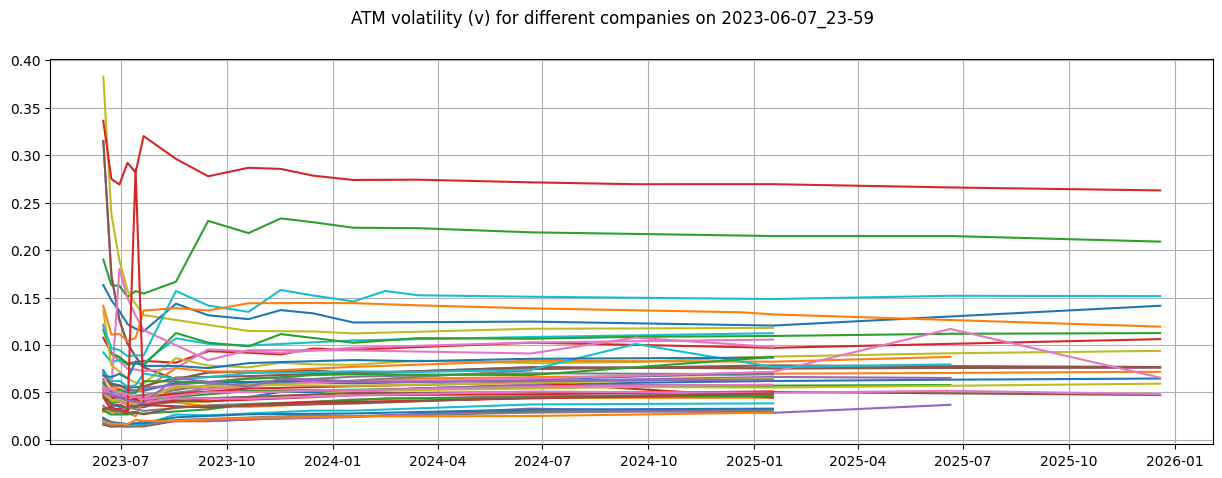

In [55]:
fig = plt.figure(figsize=(15,5))
fig.suptitle('ATM volatility (v) for different companies on ' + data_date)
for ticker in Result['ticker'].unique():
    df = Result.loc[Result['ticker'] == ticker]
    plt.plot(df['expiryDate'].astype('datetime64[ns]'),df['ATM volatility (v)'])
plt.grid()
plt.show()

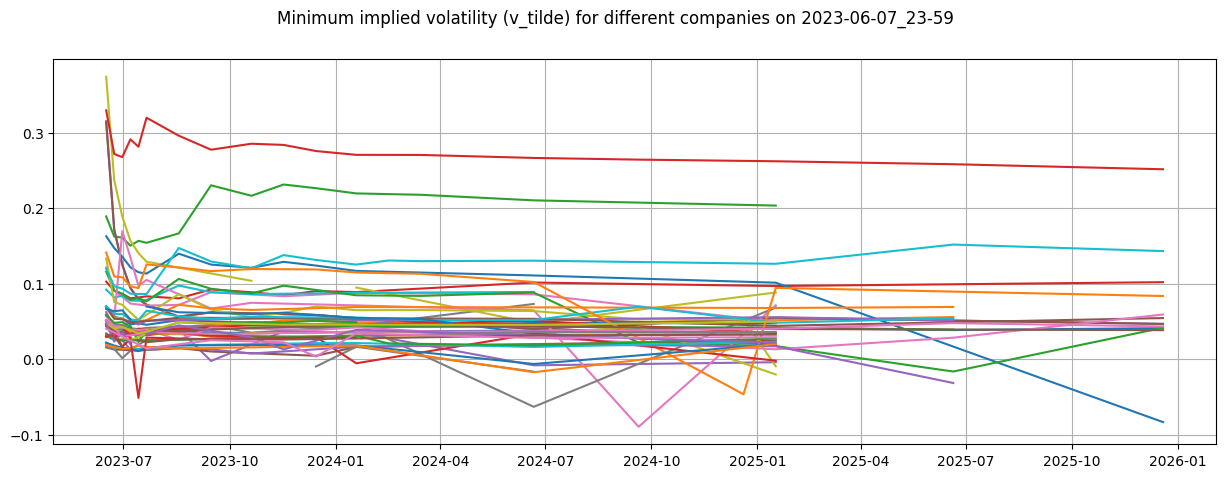

In [56]:
fig = plt.figure(figsize=(15,5))
fig.suptitle('Minimum implied volatility (v_tilde) for different companies on ' + data_date)
for ticker in Result['ticker'].unique():
    df = Result.loc[Result['ticker'] == ticker]
    plt.plot(df['expiryDate'].astype('datetime64[ns]'),df['min IV (v_tilde)'])
plt.grid()
plt.show()

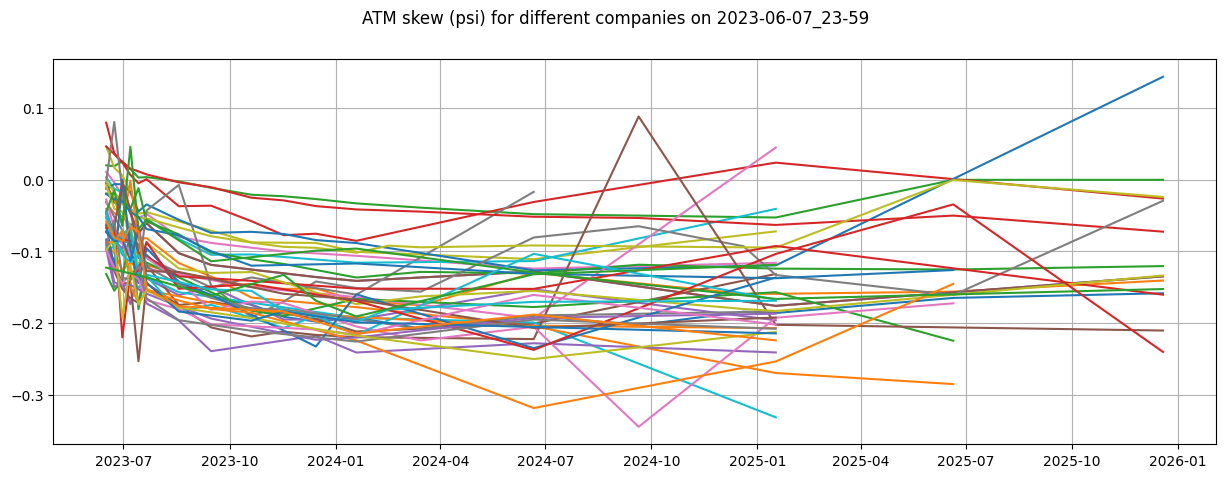

In [57]:
Result1 = Result.drop(Result.loc[Result['ticker'] == 'PM'].index)
Result1 = Result1.drop(Result1.loc[Result1['ticker'] == 'NKE'].index)
Result1 = Result1.drop(Result1.loc[Result1['ticker'] == 'CVX'].index)
Result1 = Result1.drop(Result1.loc[Result1['ticker'] == 'CMCSA'].index)
fig = plt.figure(figsize=(15,5))
fig.suptitle('ATM skew (psi) for different companies on ' + data_date)
for ticker in Result1['ticker'].unique():
    df = Result1.loc[Result1['ticker'] == ticker]
    plt.plot(df['expiryDate'].astype('datetime64[ns]'),df['ATM skew (psi)'])
plt.grid()
plt.show()

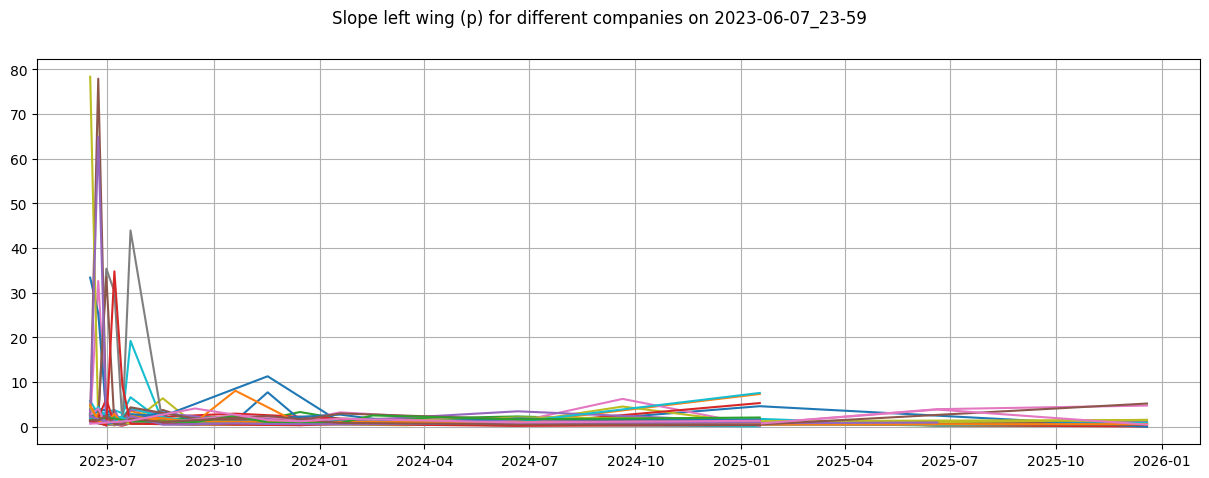

In [58]:
fig = plt.figure(figsize=(15,5))
fig.suptitle('Slope left wing (p) for different companies on ' + data_date)
for ticker in Result['ticker'].unique():
    df = Result.loc[Result['ticker'] == ticker]
    plt.plot(df['expiryDate'].astype('datetime64[ns]'),df['Slope left wing (p)'])
plt.grid()
plt.show()

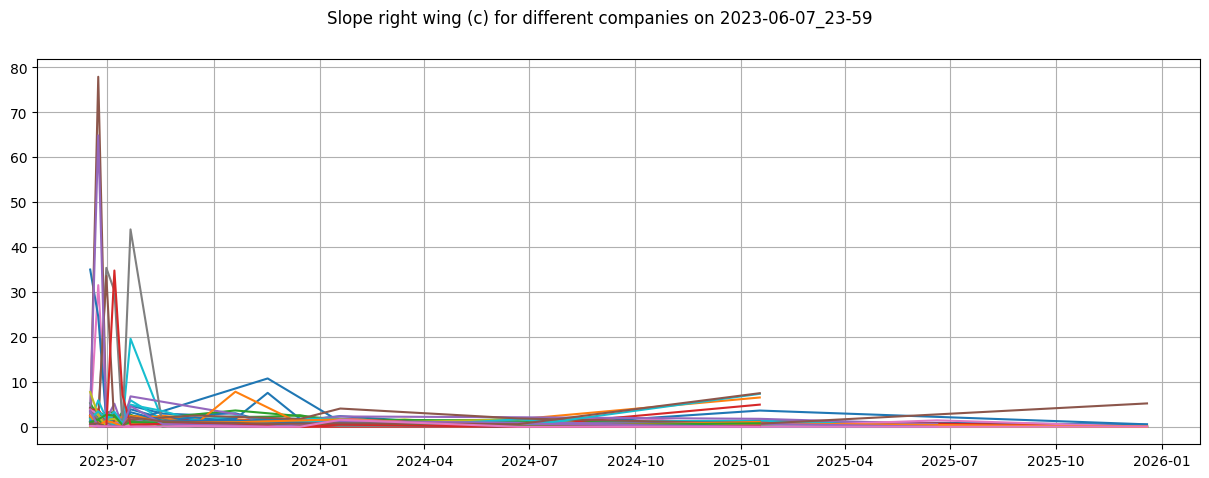

In [59]:
fig = plt.figure(figsize=(15,5))
fig.suptitle('Slope right wing (c) for different companies on ' + data_date)
for ticker in Result['ticker'].unique():
    df = Result.loc[Result['ticker'] == ticker]
    plt.plot(df['expiryDate'].astype('datetime64[ns]'),df['Slope right wing (c)'])
plt.grid()
plt.show()

In [60]:
print('mean value for options on different companies, which inside the bid ask spread', Result['inside'].mean(), '%')
print('mean value for options on different companies, which above the bid ask spread', Result['above'].mean(), '%')
print('mean value for options on different companies, which below the bid ask spread', Result['below'].mean(), '%')

mean value for options on different companies, which inside the bid ask spread 72.1021792904801 %
mean value for options on different companies, which above the bid ask spread 7.195723231225723 %
mean value for options on different companies, which below the bid ask spread 20.70209747829418 %


In [62]:
start_v = []
start_v_tilda = []
end_psi = []
start_c = []
start_p = []
for ticker in Result['ticker'].unique():
    df = Result.loc[Result['ticker'] == ticker]
    start_v.append(df['start_v'].unique()[0] / len(df))
    start_v_tilda.append(df['start_v_tilda'].unique()[0] / len(df))
    end_psi.append(df['end_psi'].unique()[0] / len(df))
    start_c.append(df['start_c'].unique()[0] / len(df))
    start_p.append(df['start_p'].unique()[0] / len(df))
start_v = np.array(start_v).mean()
start_v_tilda = np.array(start_v_tilda).mean()
end_psi = np.array(end_psi).mean()
start_c = np.array(start_c).mean()
start_p = np.array(start_p).mean()
print('average start number for value in sample for ATM volatility (v) =', start_v * 100, '%')
print('average start number for value in sample for minimum implied volatility (v_tilde) =', start_v_tilda * 100, '%')
print('average amount of value in sample for ATM skew (psi) =', end_psi * 100, '%')
print('average start number for value in sample for Slope right wing (c) =', start_c * 100, '%')
print('average start number for value in sample for Slope left wing (p) =', start_p * 100, '%')

average start number for value in sample for ATM volatility (v) = 28.576175707128883 %
average start number for value in sample for minimum implied volatility (v_tilde) = 33.387309422237955 %
average amount of value in sample for ATM skew (psi) = 55.29054067012699 %
average start number for value in sample for Slope right wing (c) = 19.624382599812417 %
average start number for value in sample for Slope left wing (p) = 19.994717313075792 %


In [6]:
for k in Implied_Volatility_without_extrapolation['implied_volatility_surface']:
    print(k['expiry_date_in_act365_year_fraction'])

0.005479452054794521
0.024657534246575342
0.043835616438356165
0.06301369863013699
0.0821917808219178
0.10136986301369863
0.12054794520547946
0.19726027397260273
0.273972602739726
0.3698630136986301
0.4465753424657534
0.5232876712328767
0.6191780821917808
0.7726027397260274
1.0410958904109588
1.2904109589041095
1.5397260273972602
1.6164383561643836
2.0383561643835617
2.536986301369863


In [ ]:
print()

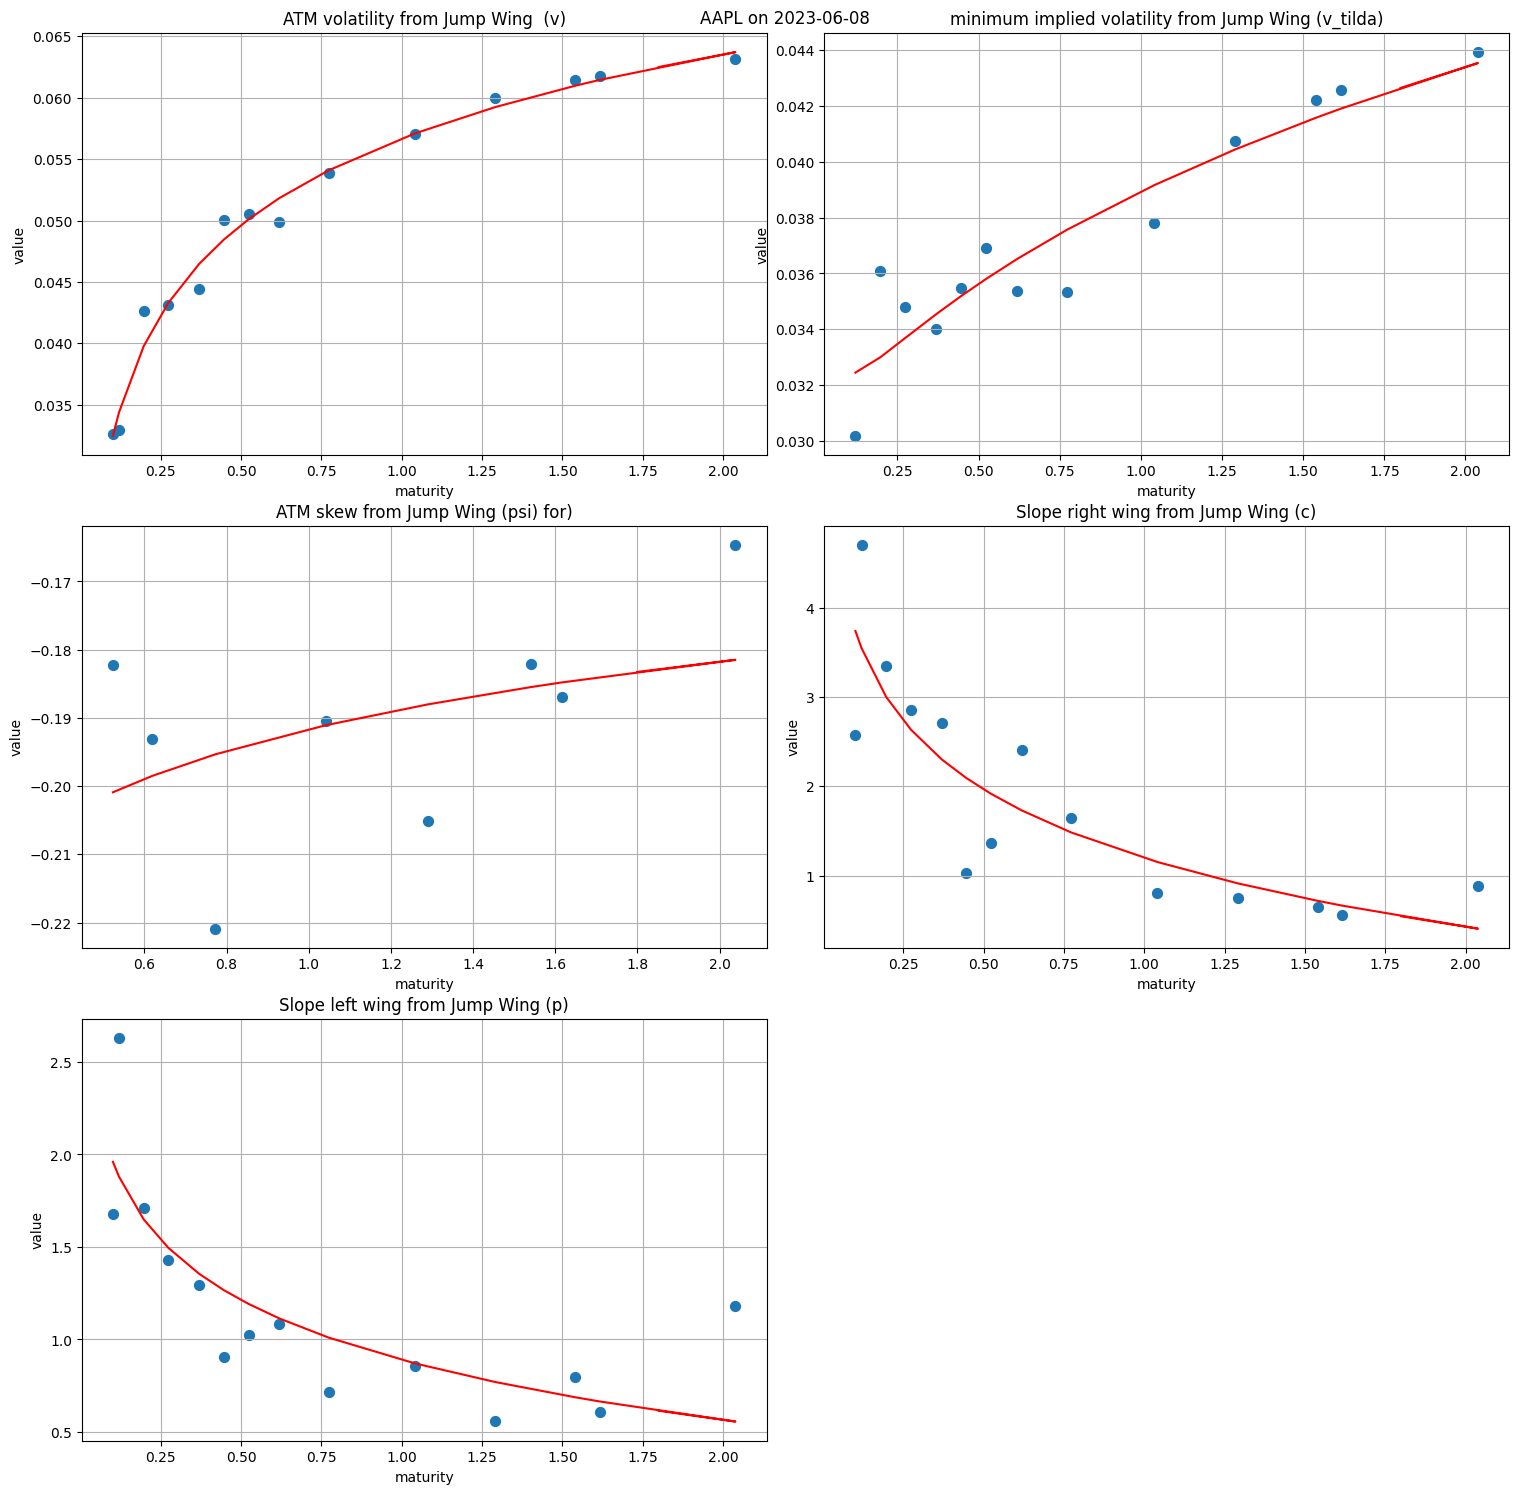

0.06250235515573463 0.042648747228421165 -0.183253216836229 0.5426614743985066 0.6146781946565651
0.11250423928032234
b = 0.19409541987599788
beta = 0.5711340972409061
a= -0.058605779155050025
b= 0.19409541987599788
rho= -0.06222608814304076
m= 0.48621862957527245
sigma= 0.6988128664105759


In [8]:

timeteable = 19
expire_time = 0.9
expire_time = 1.2
expire_time = 1.4
expire_time = 1.7
expire_time = 1.8
a, b, rho, m, sigma = get_SVI_extrapolation(Implied_Volatility_without_extrapolation, expire_time, start_v, start_v_tilda, end_psi, start_c, start_p,0, 1, type_reggresion = 'polynomial')
# plt.plot(w_volatility)
# lines_2D_SVI_example(ticker, Implied_Volatility_without_extrapolation, timeteable, w_volatility)

In [13]:

SVI(1, 1, 1, 1, 1)

SVI(a=1, b=1, rho=1, m=1, sigma=1)

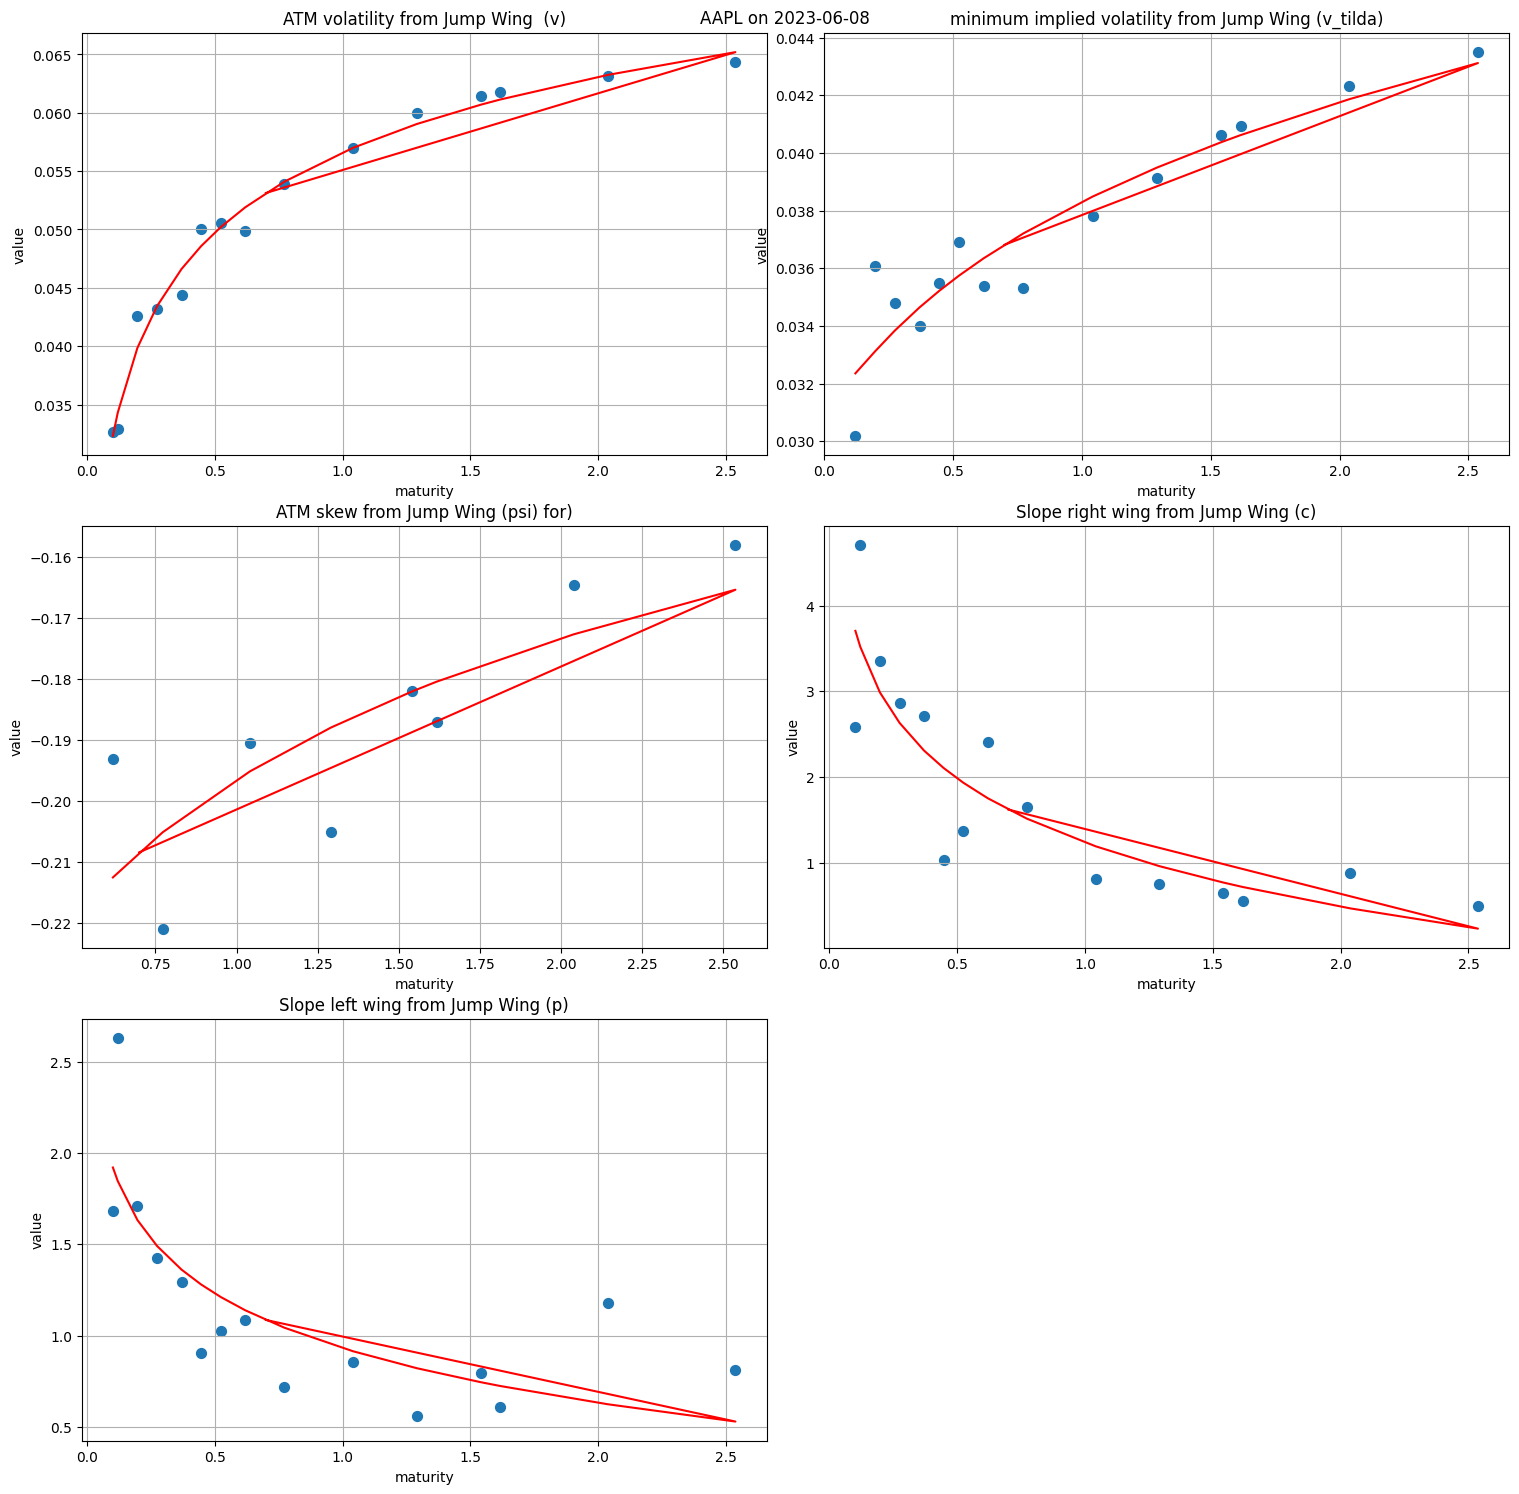

0.05312683409913453 0.036816059520716746 -0.20839471282581898 1.6203581432802097 1.0856045892841144
0.03718878386939417
b = 0.2609142527712199
beta = 0.5056730415509684
a= -0.1518661278638745
b= 0.2609142527712199
rho= 0.19762044301671977
m= 0.40708426683813037
sigma= 0.6945235907178425
SVI(a=-0.1518661278638745, b=0.2609142527712199, rho=0.19762044301671977, m=0.40708426683813037, sigma=0.6945235907178425)


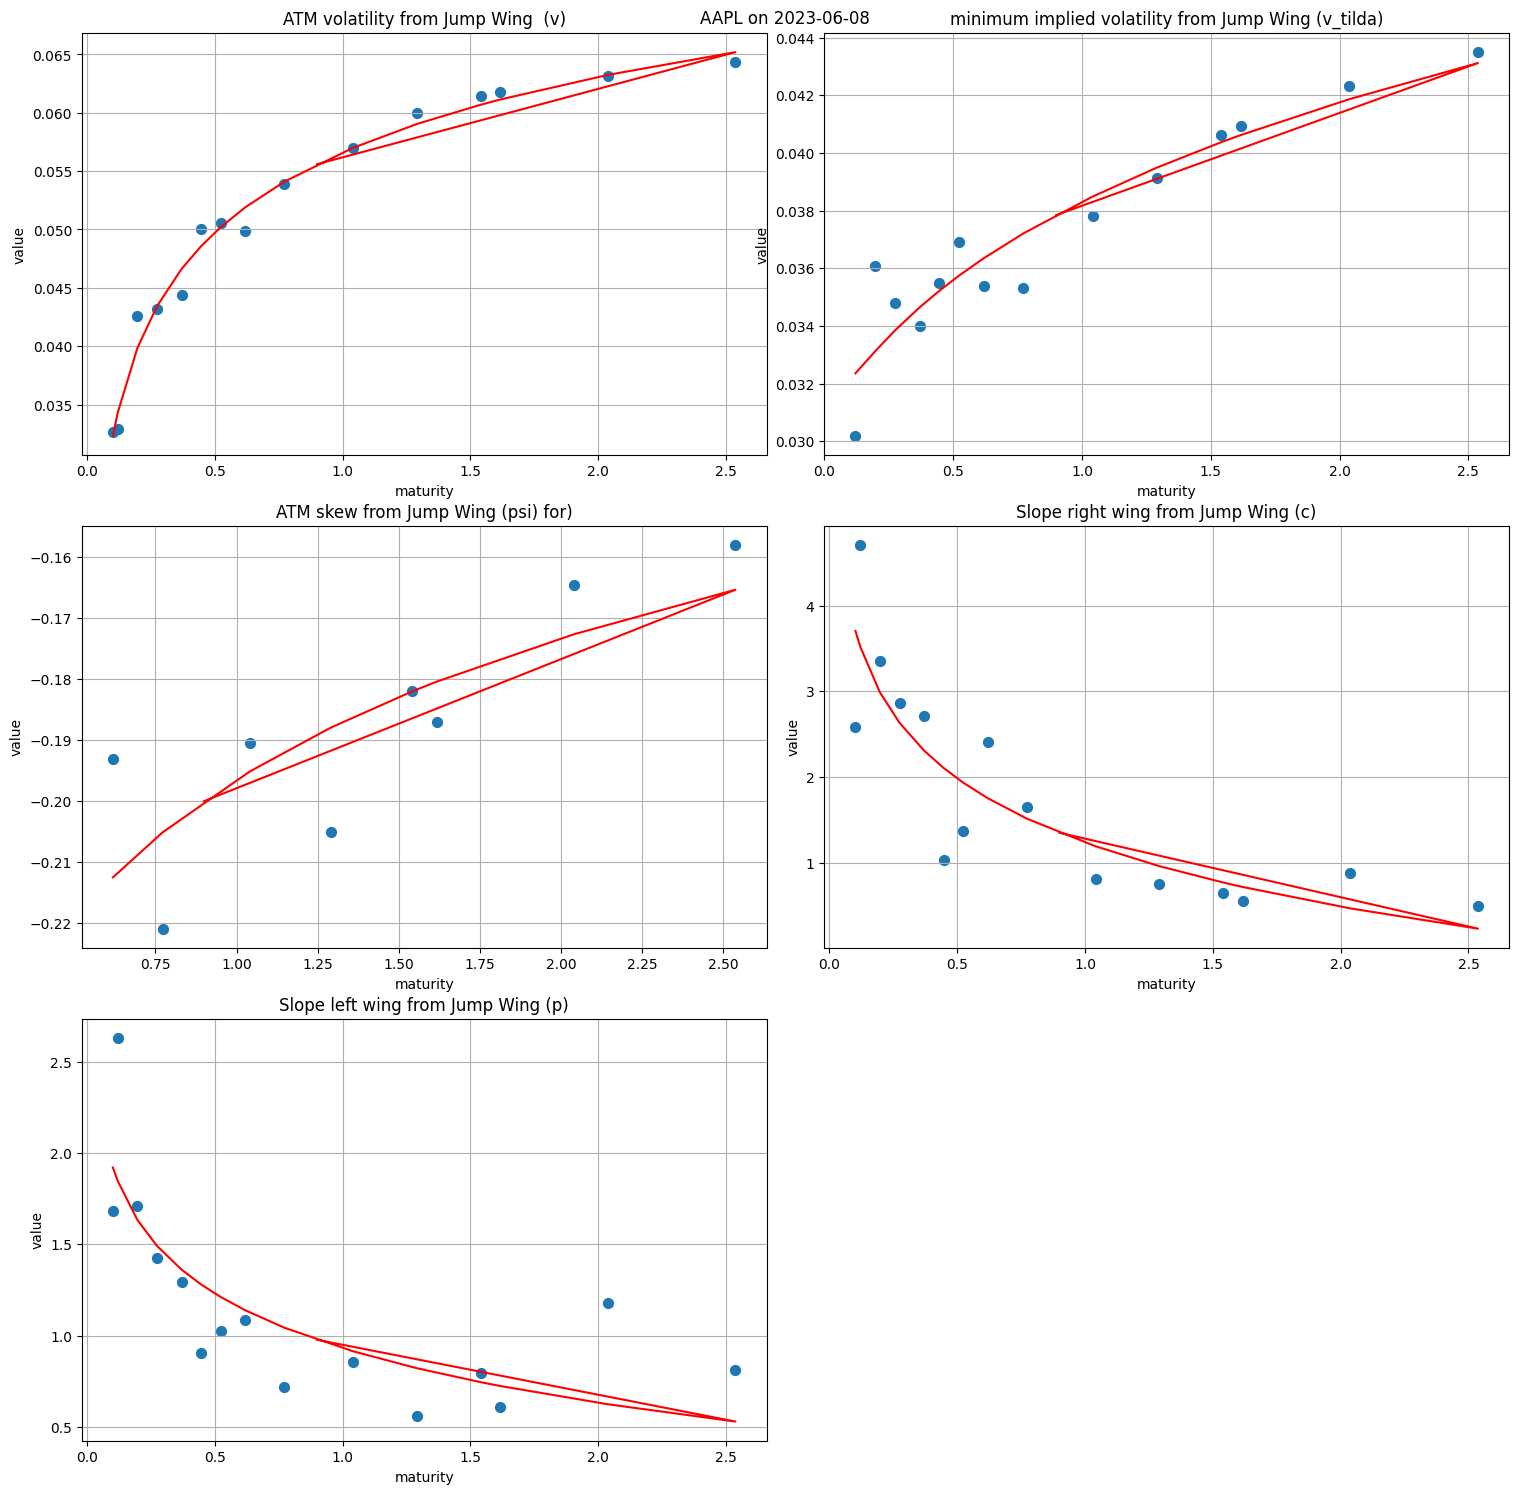

0.05559575378354955 0.03784493938346765 -0.20000403696626795 1.3492620776855315 0.9770257669411265
0.050036178405194594
b = 0.2601809660640247
beta = 0.5039154811891344
a= -0.17002348778994347
b= 0.2601809660640247
rho= 0.16001300595891854
m= 0.46358965101246435
sigma= 0.7946311463548925
SVI(a=-0.17002348778994347, b=0.2601809660640247, rho=0.16001300595891854, m=0.46358965101246435, sigma=0.7946311463548925)


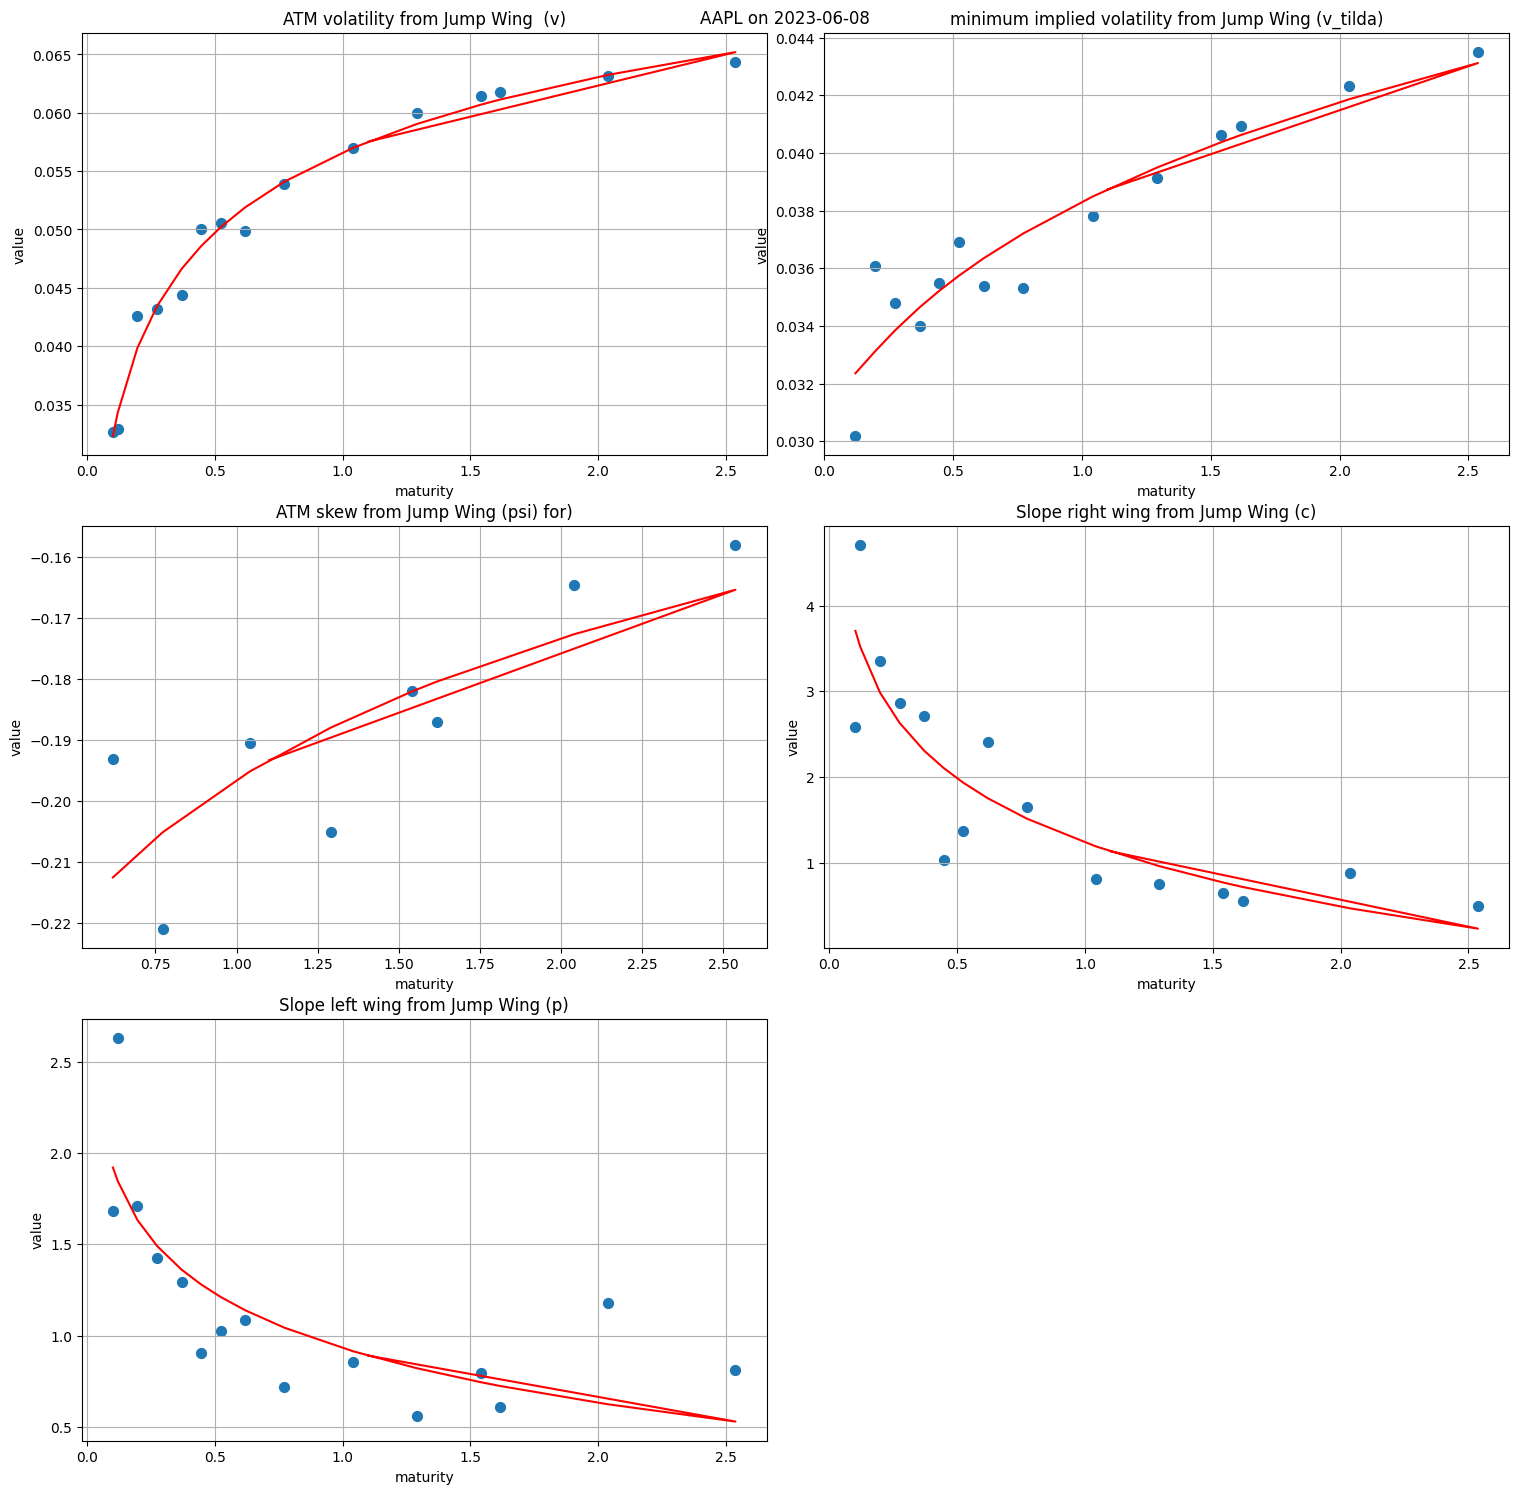

0.057527976793344246 0.038736703912986566 -0.1933042116850407 1.1327960498809901 0.8903272516944228
0.06328077447267867
b = 0.254465113046562
beta = 0.5020384294599406
a= -0.1759062182196196
b= 0.254465113046562
rho= 0.11984874970188719
m= 0.5021070932183573
sigma= 0.8649635977867003
SVI(a=-0.1759062182196196, b=0.254465113046562, rho=0.11984874970188719, m=0.5021070932183573, sigma=0.8649635977867003)


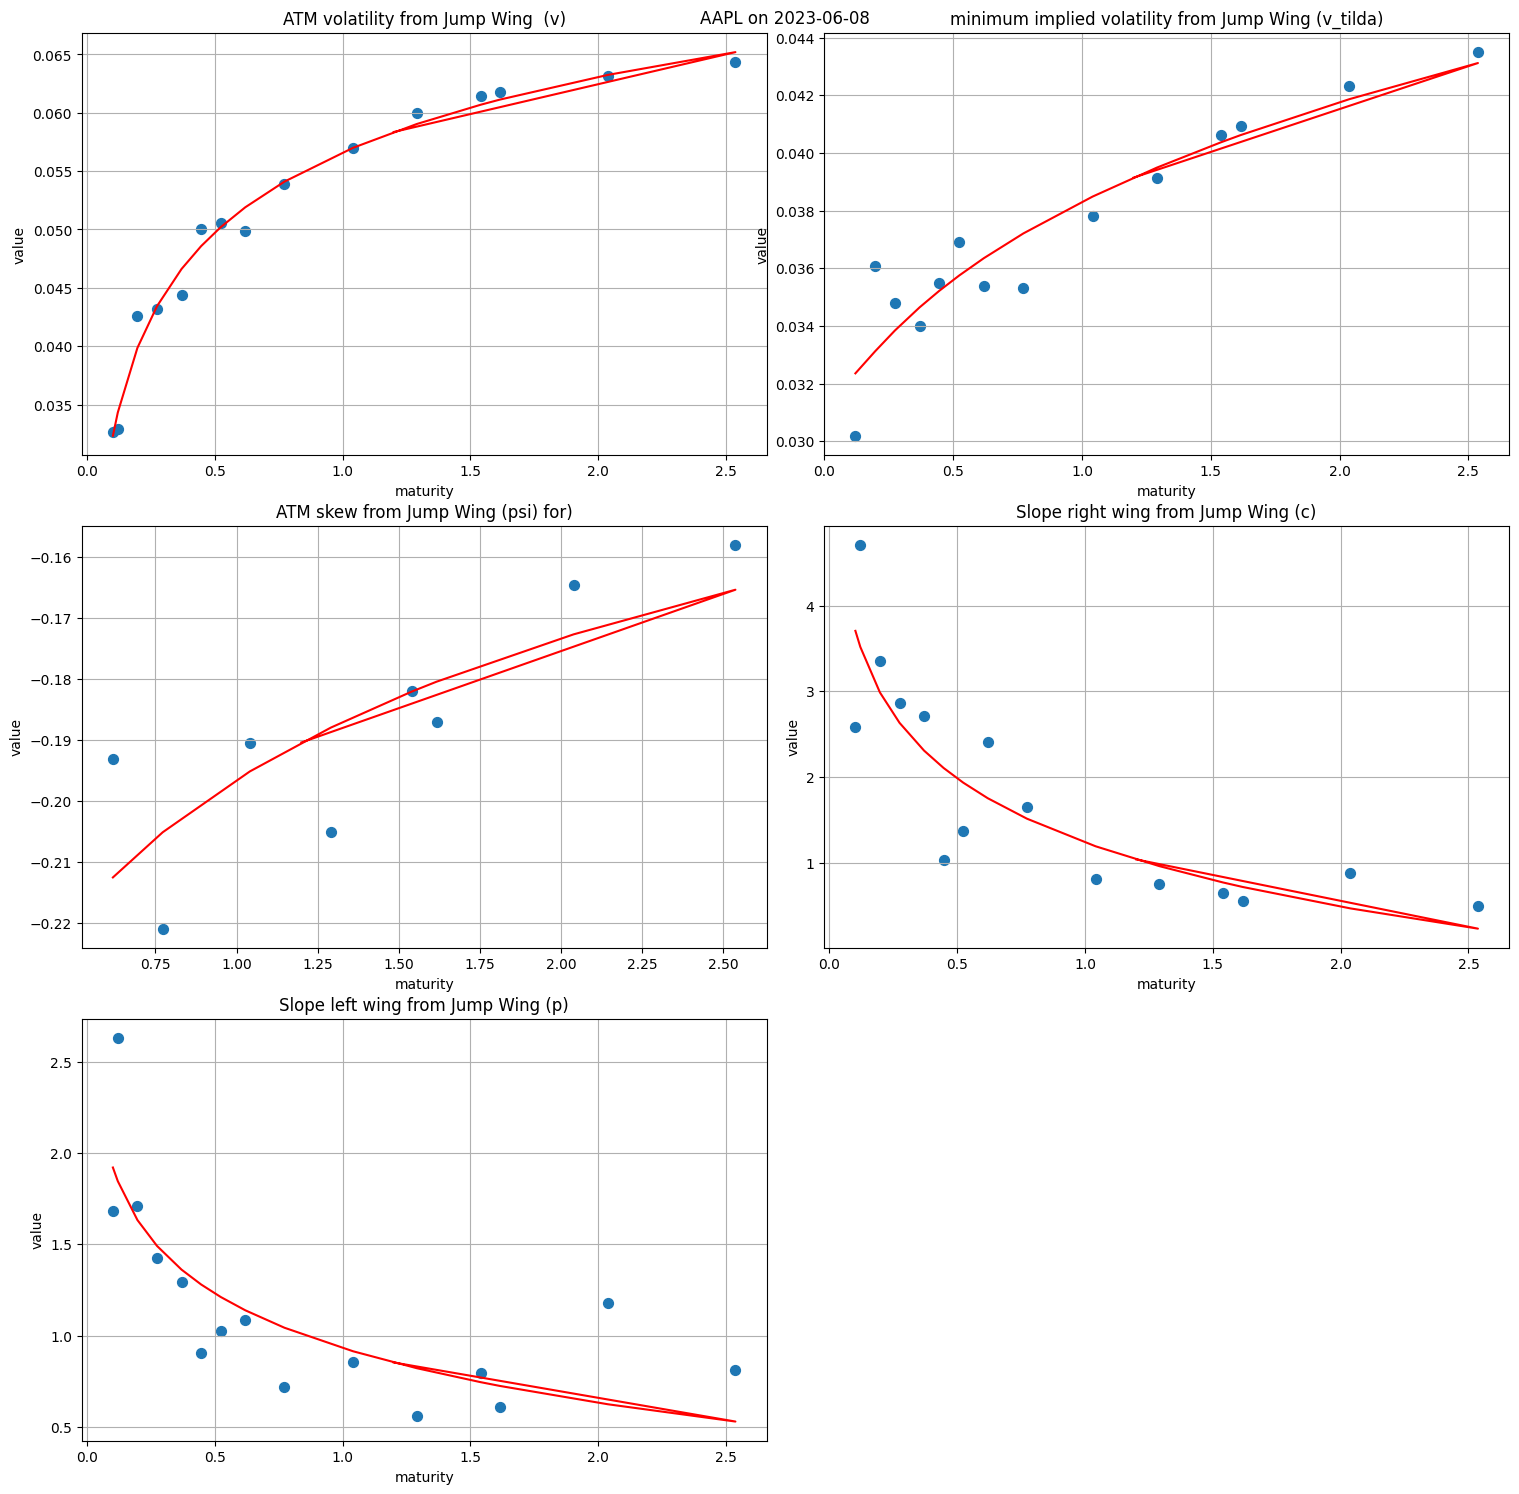

0.05835498354640575 0.03914275492409808 -0.19039914863152937 1.0389357724380333 0.8527345320539265
0.0700259802556869
b = 0.2502908937813439
beta = 0.5010375395012461
a= -0.17497645469417317
b= 0.2502908937813439
rho= 0.09843218447842272
m= 0.5158939639018313
sigma= 0.8910865607363924
SVI(a=-0.17497645469417317, b=0.2502908937813439, rho=0.09843218447842272, m=0.5158939639018313, sigma=0.8910865607363924)


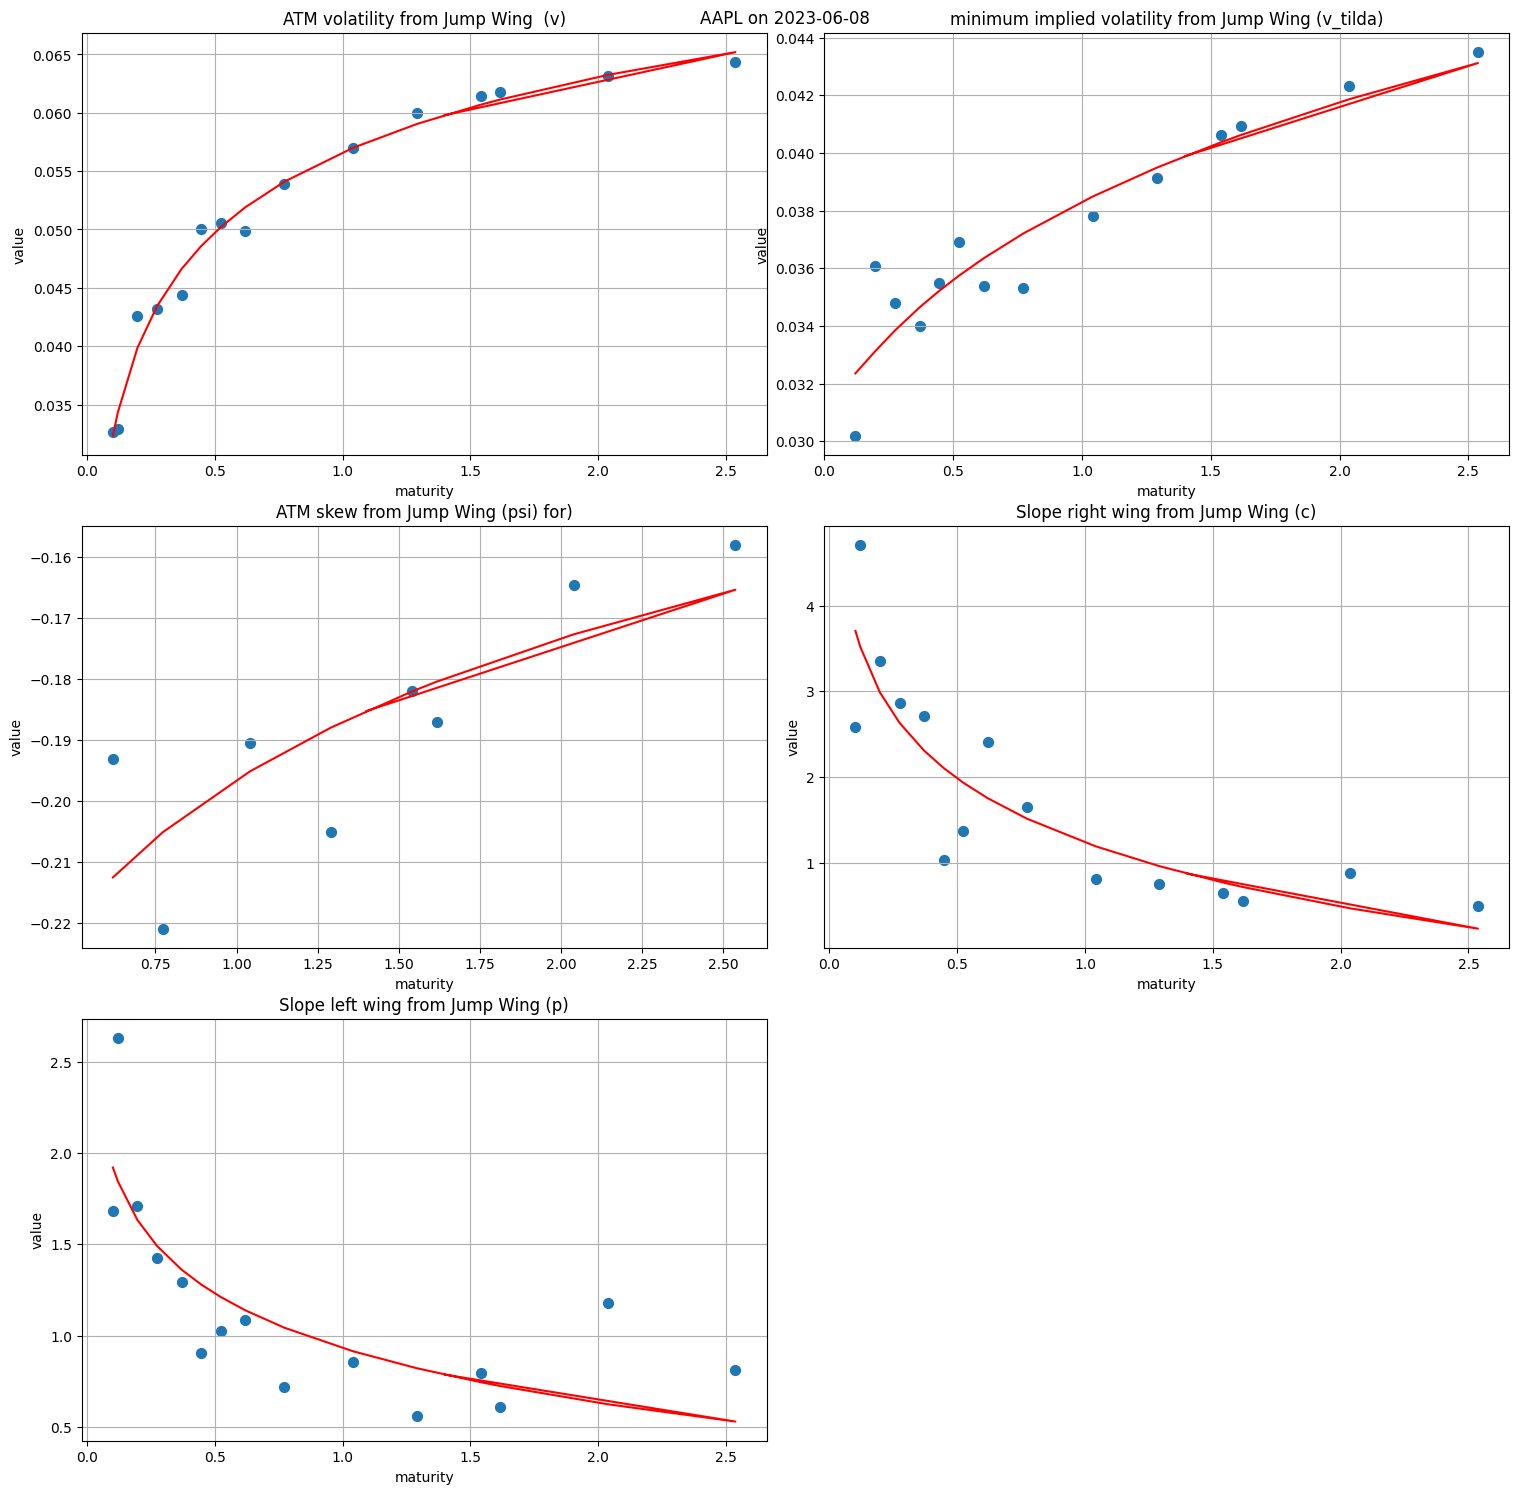

0.059804066155756085 0.0398909020884494 -0.18525249470955787 0.8726514763243045 0.7861346977606627
0.08372569261805851
b = 0.239988143247859
beta = 0.4988748823267472
a= -0.16656518966976677
b= 0.239988143247859
rho= 0.05215667933292656
m= 0.5341911515877609
sigma= 0.9280274626087298
SVI(a=-0.16656518966976677, b=0.239988143247859, rho=0.05215667933292656, m=0.5341911515877609, sigma=0.9280274626087298)


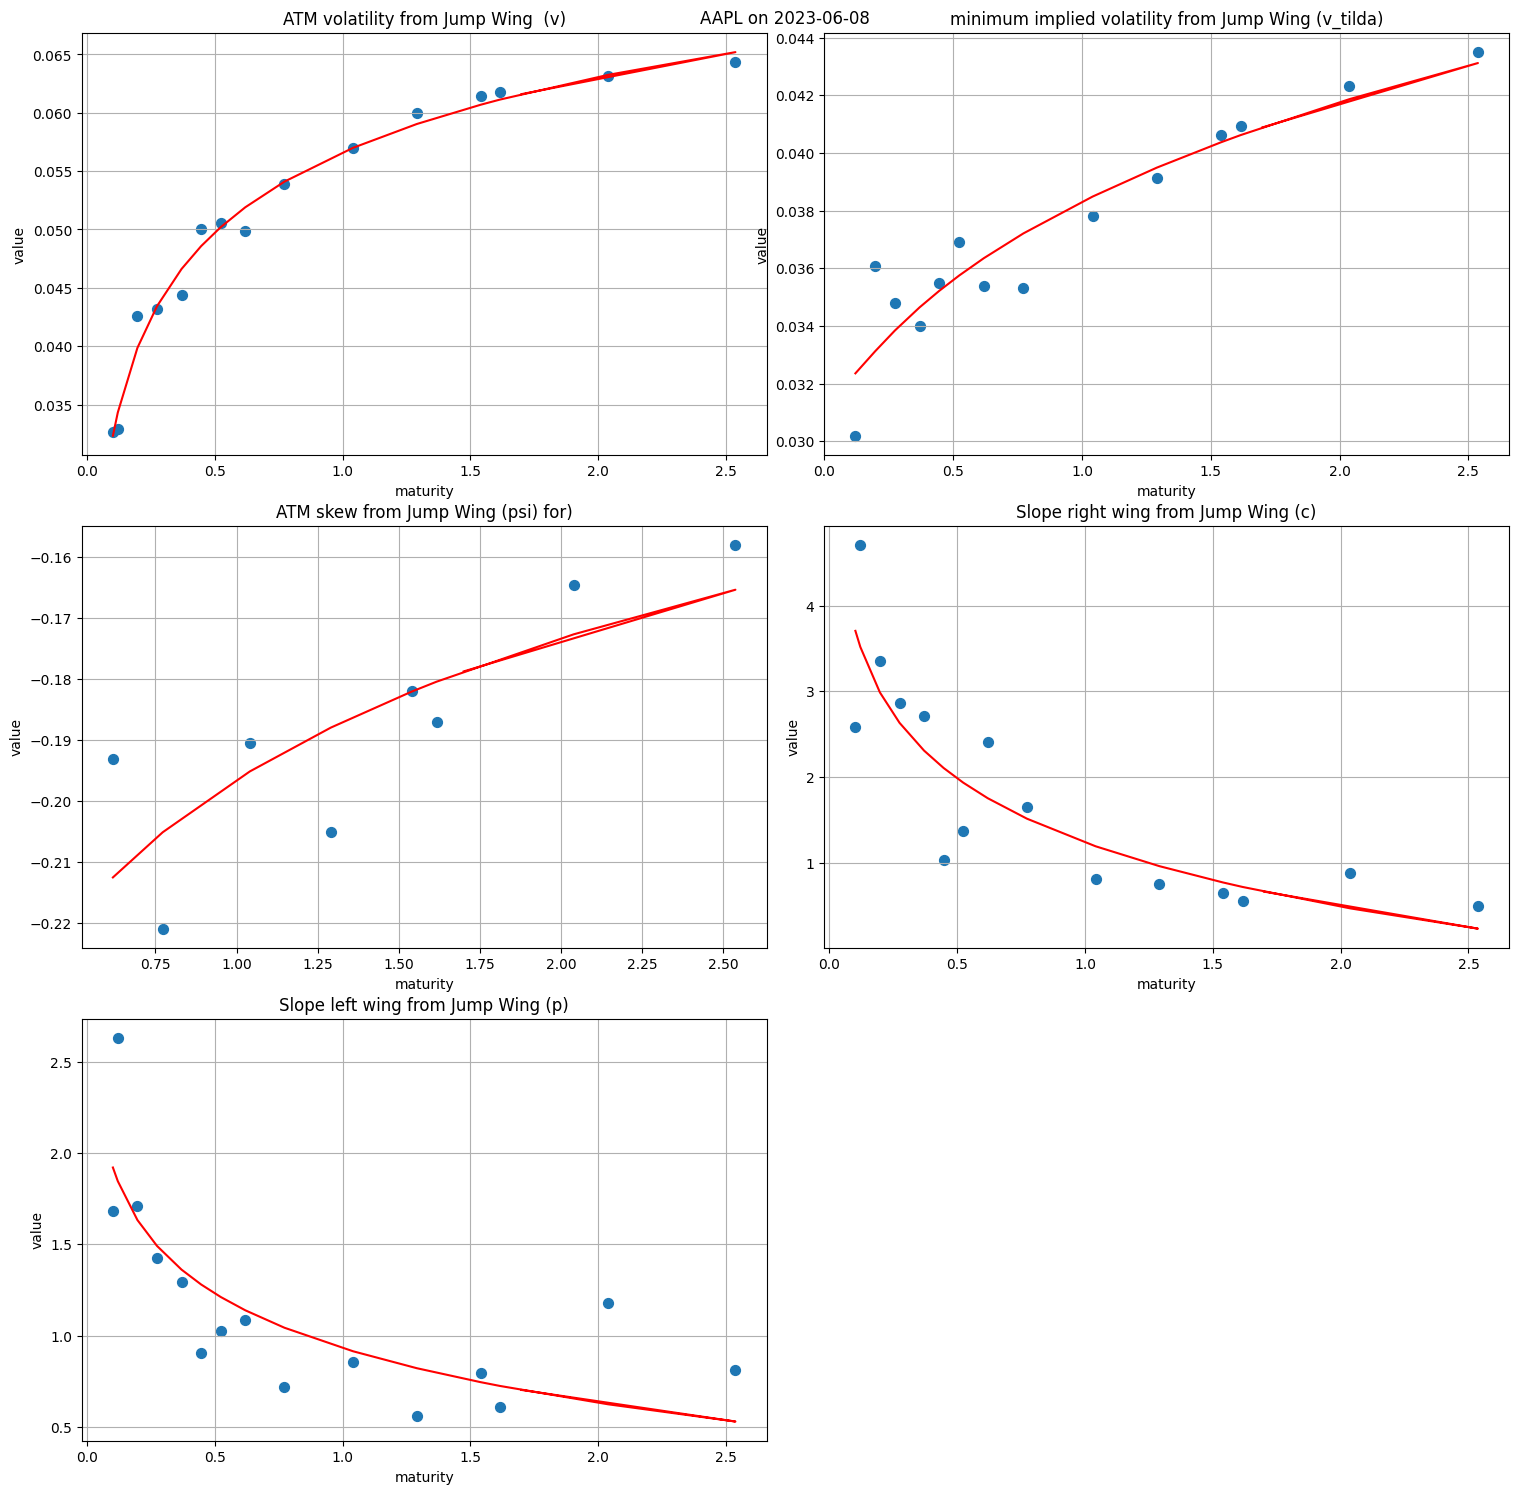

0.06160001007479135 0.04088556487576586 -0.17877017614750754 0.6632129176767503 0.7022508095851545
0.10472001712714529
b = 0.22093525601362138
beta = 0.4951012606078231
a= -0.14043609864890805
b= 0.22093525601362138
rho= -0.02858947559645908
m= 0.5417108547492048
sigma= 0.950628768254375
SVI(a=-0.14043609864890805, b=0.22093525601362138, rho=-0.02858947559645908, m=0.5417108547492048, sigma=0.950628768254375)


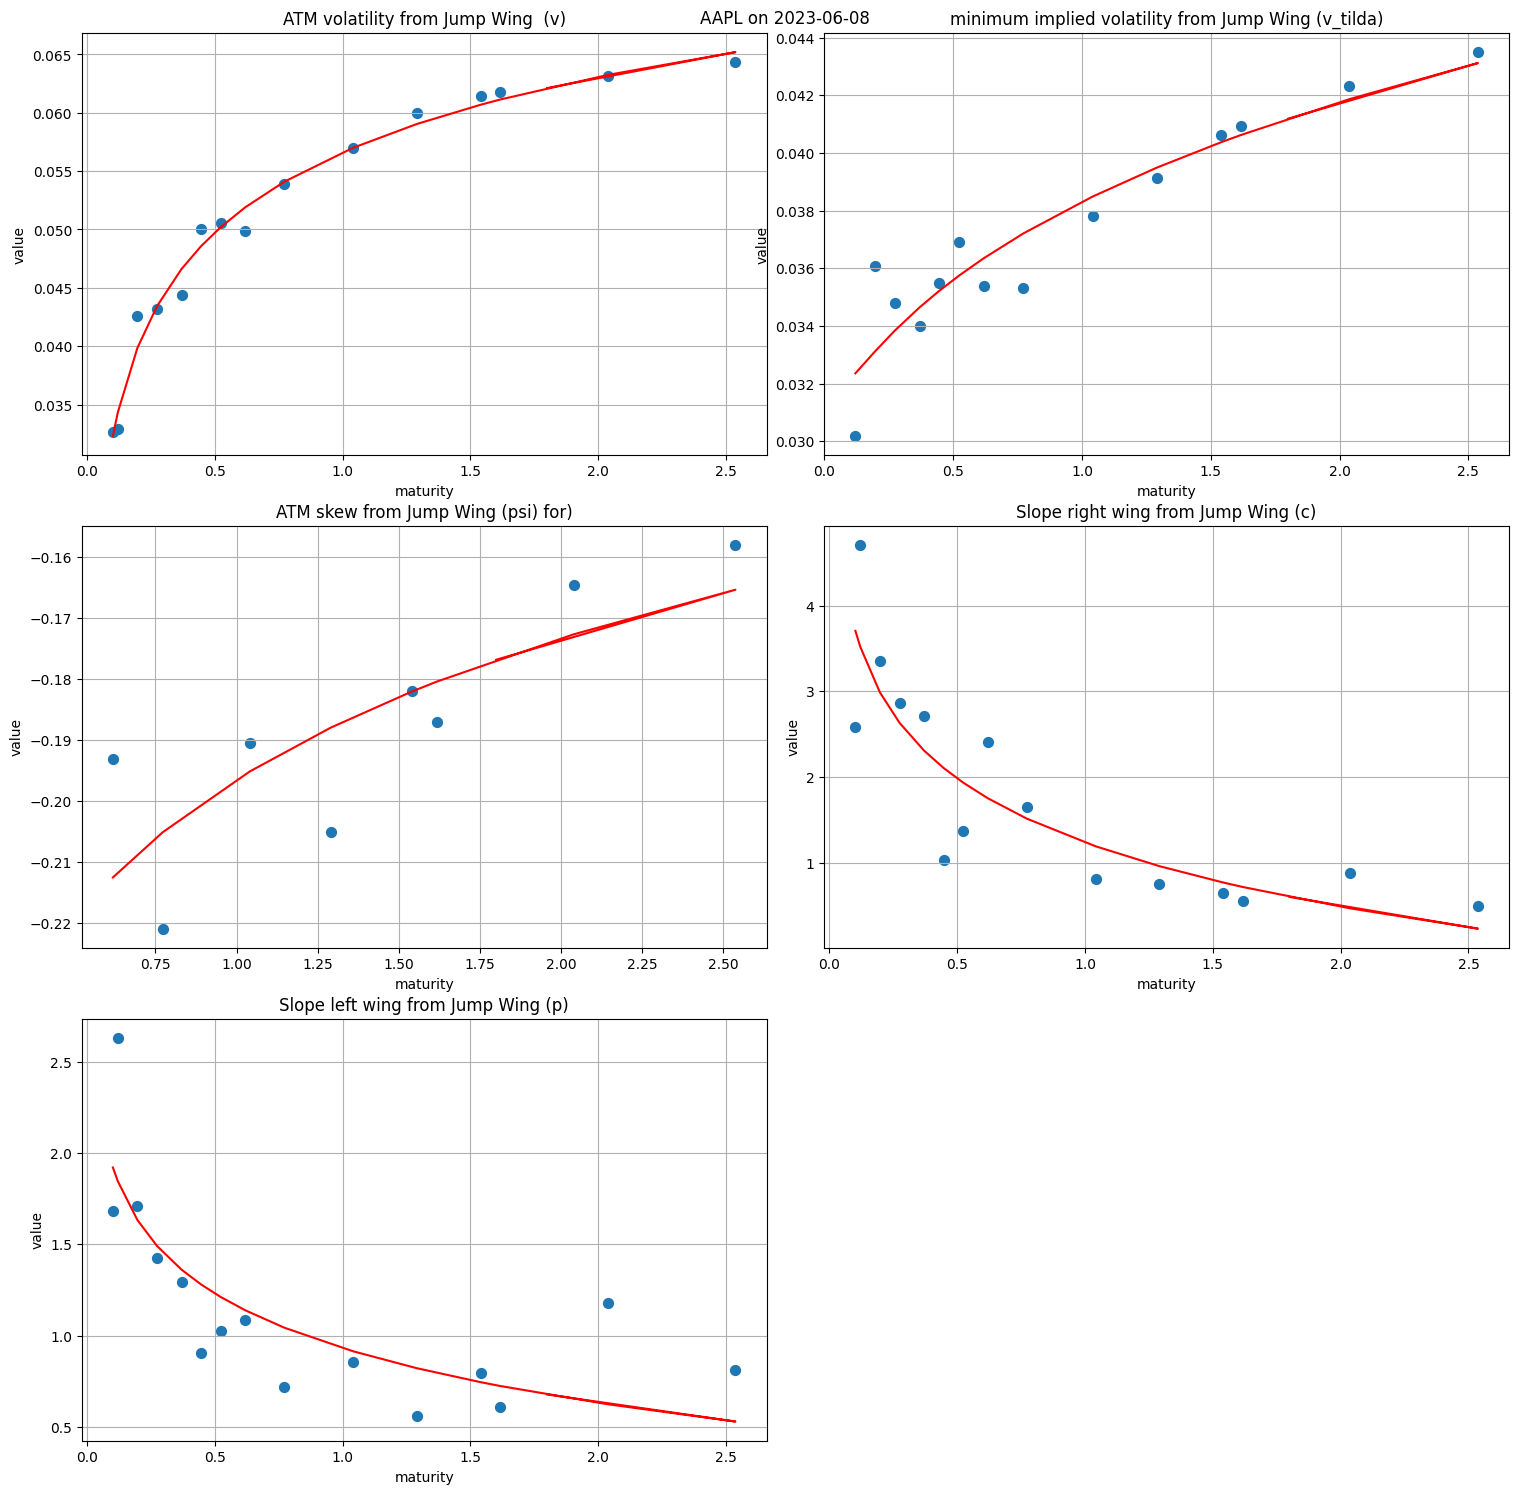

0.0621225218408366 0.041189509017179333 -0.17686181885000685 0.6015554107296263 0.6775558754176748
0.11182053931350588
b = 0.21386470967938356
beta = 0.49366057320462264
a= -0.12875883005048094
b= 0.21386470967938356
rho= -0.05941661645169516
m= 0.5395011513673804
sigma= 0.9504094902037006
SVI(a=-0.12875883005048094, b=0.21386470967938356, rho=-0.05941661645169516, m=0.5395011513673804, sigma=0.9504094902037006)


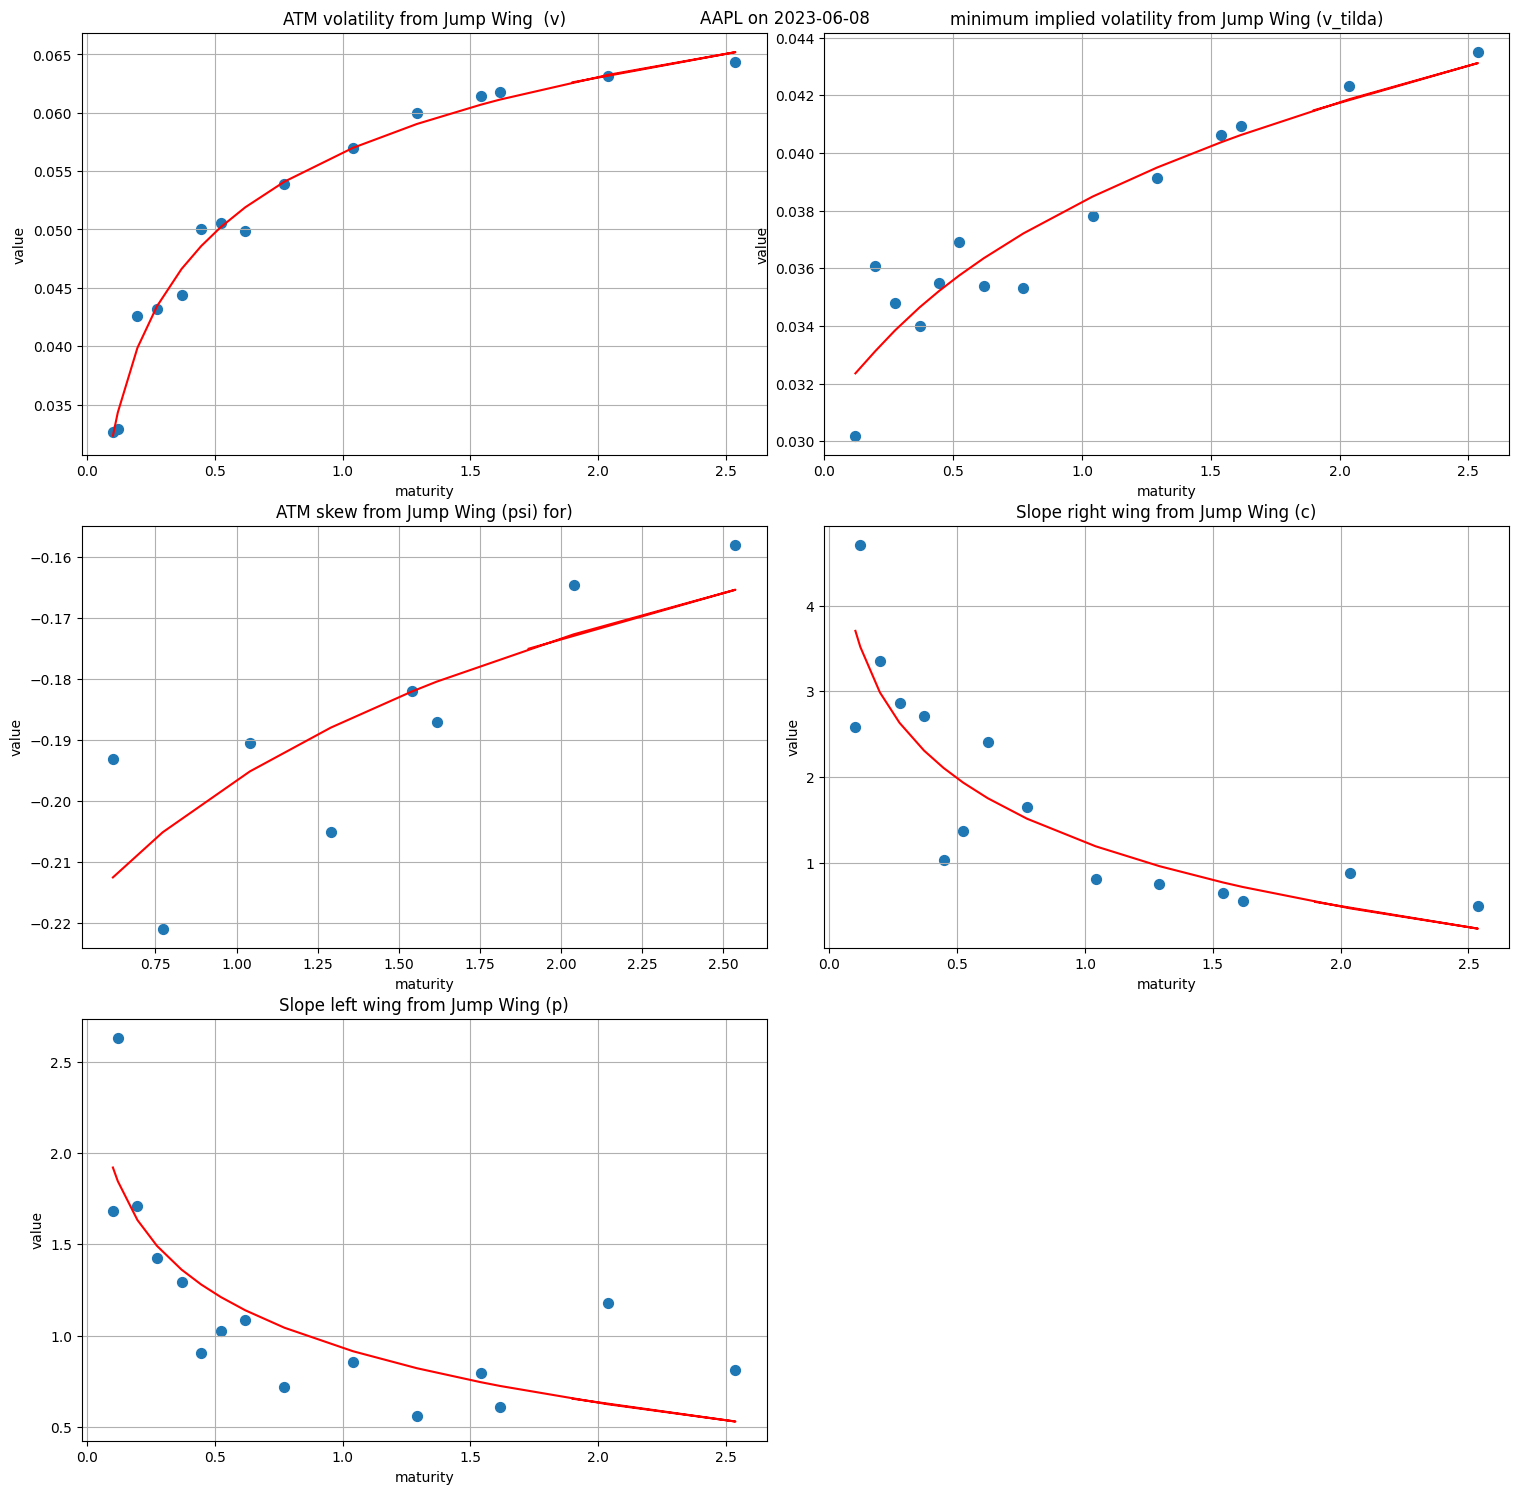

0.0626141784115938 0.04148167127095263 -0.1750566677036571 0.5432324124669664 0.6541964716100969
0.1189669389820282
b = 0.20650609669129172
beta = 0.4921065622412151
a= -0.11581810571144498
b= 0.20650609669129172
rho= -0.0926686007149875
m= 0.5350938502832089
sigma= 0.9465793465237103
SVI(a=-0.11581810571144498, b=0.20650609669129172, rho=-0.0926686007149875, m=0.5350938502832089, sigma=0.9465793465237103)


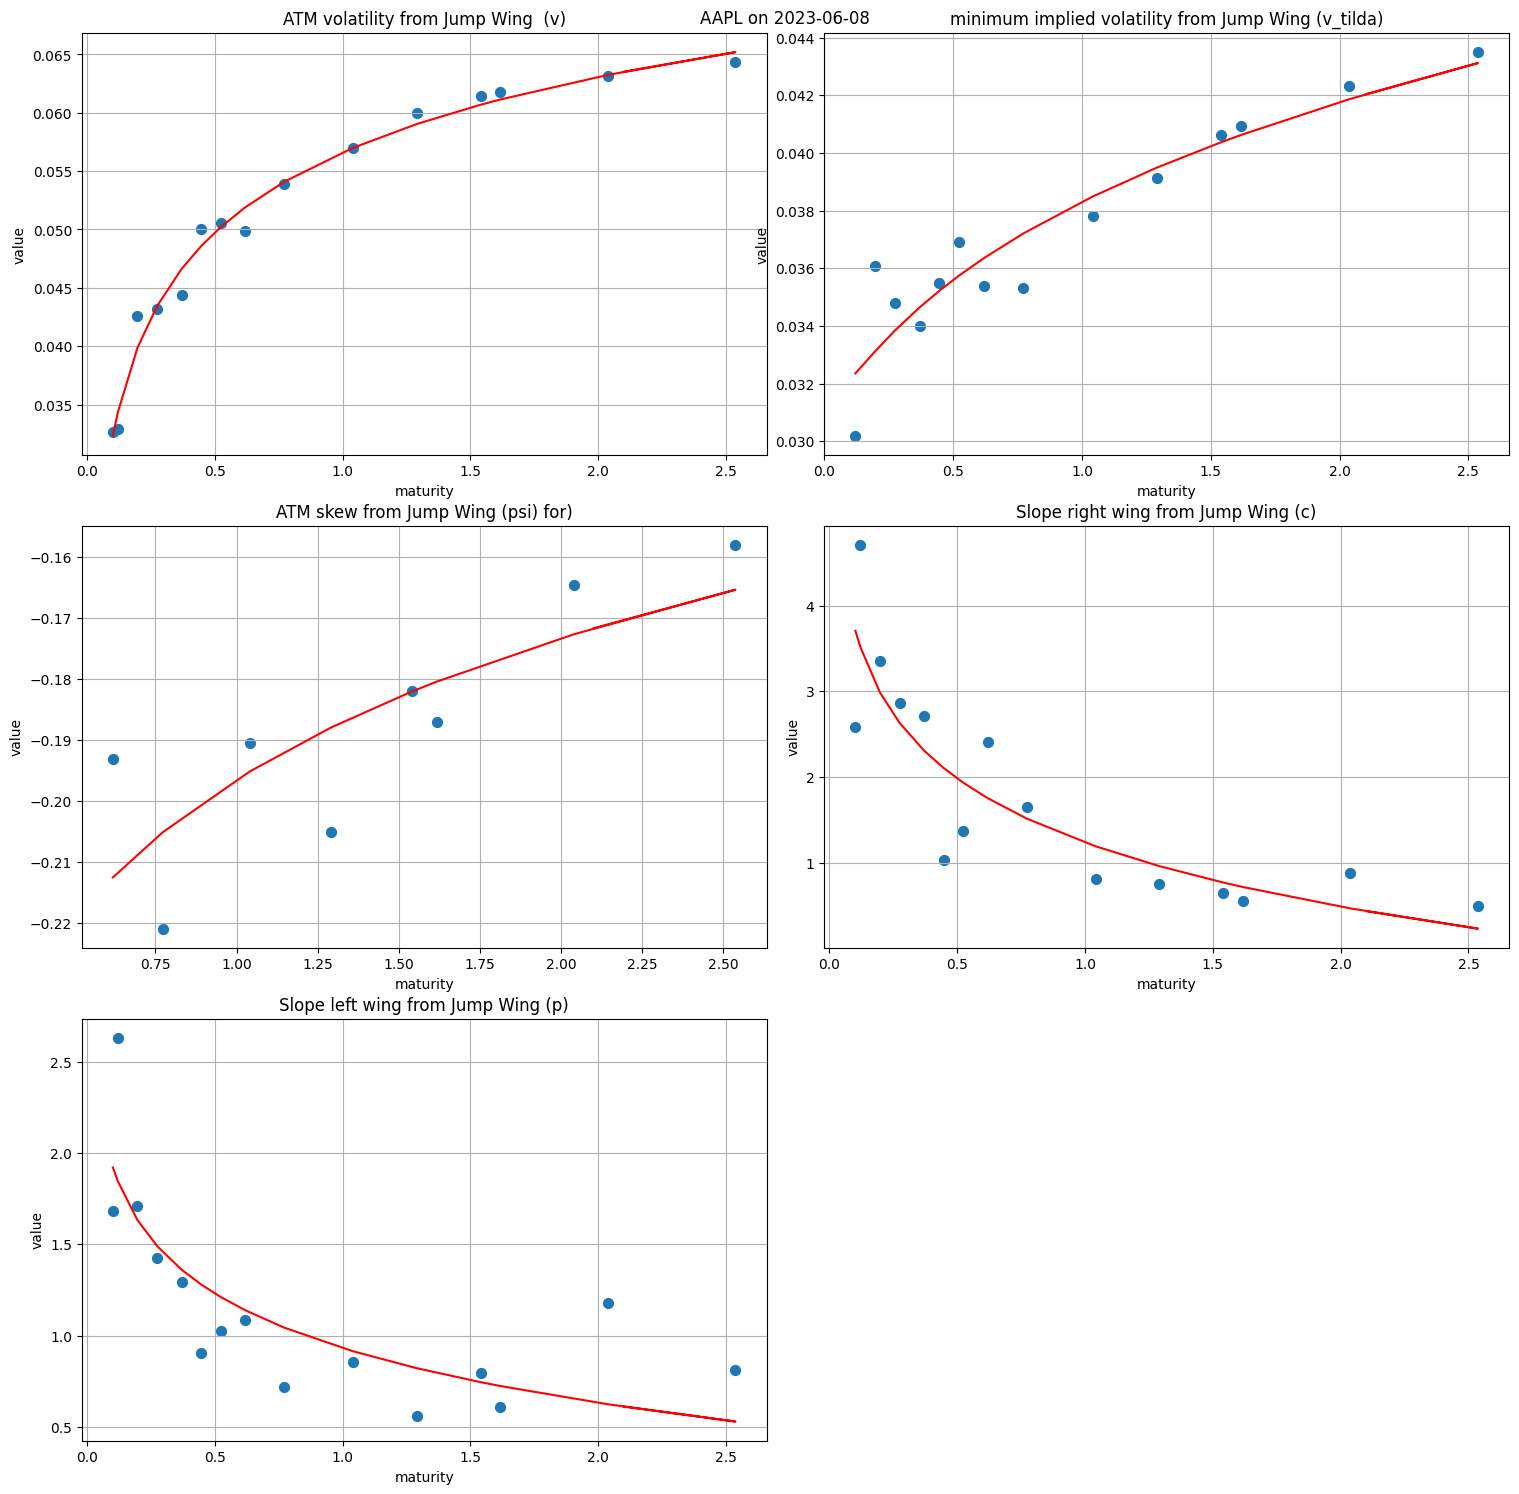

0.06351761751801951 0.04203443505806679 -0.17171516492803532 0.4352711146158974 0.610956041124411
0.133386996787841
b = 0.1910525065718116
beta = 0.48858962453705457
a= -0.08658381936569146
b= 0.1910525065718116
rho= -0.16792235371122555
m= 0.5198896791328179
sigma= 0.9284087326824908
SVI(a=-0.08658381936569146, b=0.1910525065718116, rho=-0.16792235371122555, m=0.5198896791328179, sigma=0.9284087326824908)


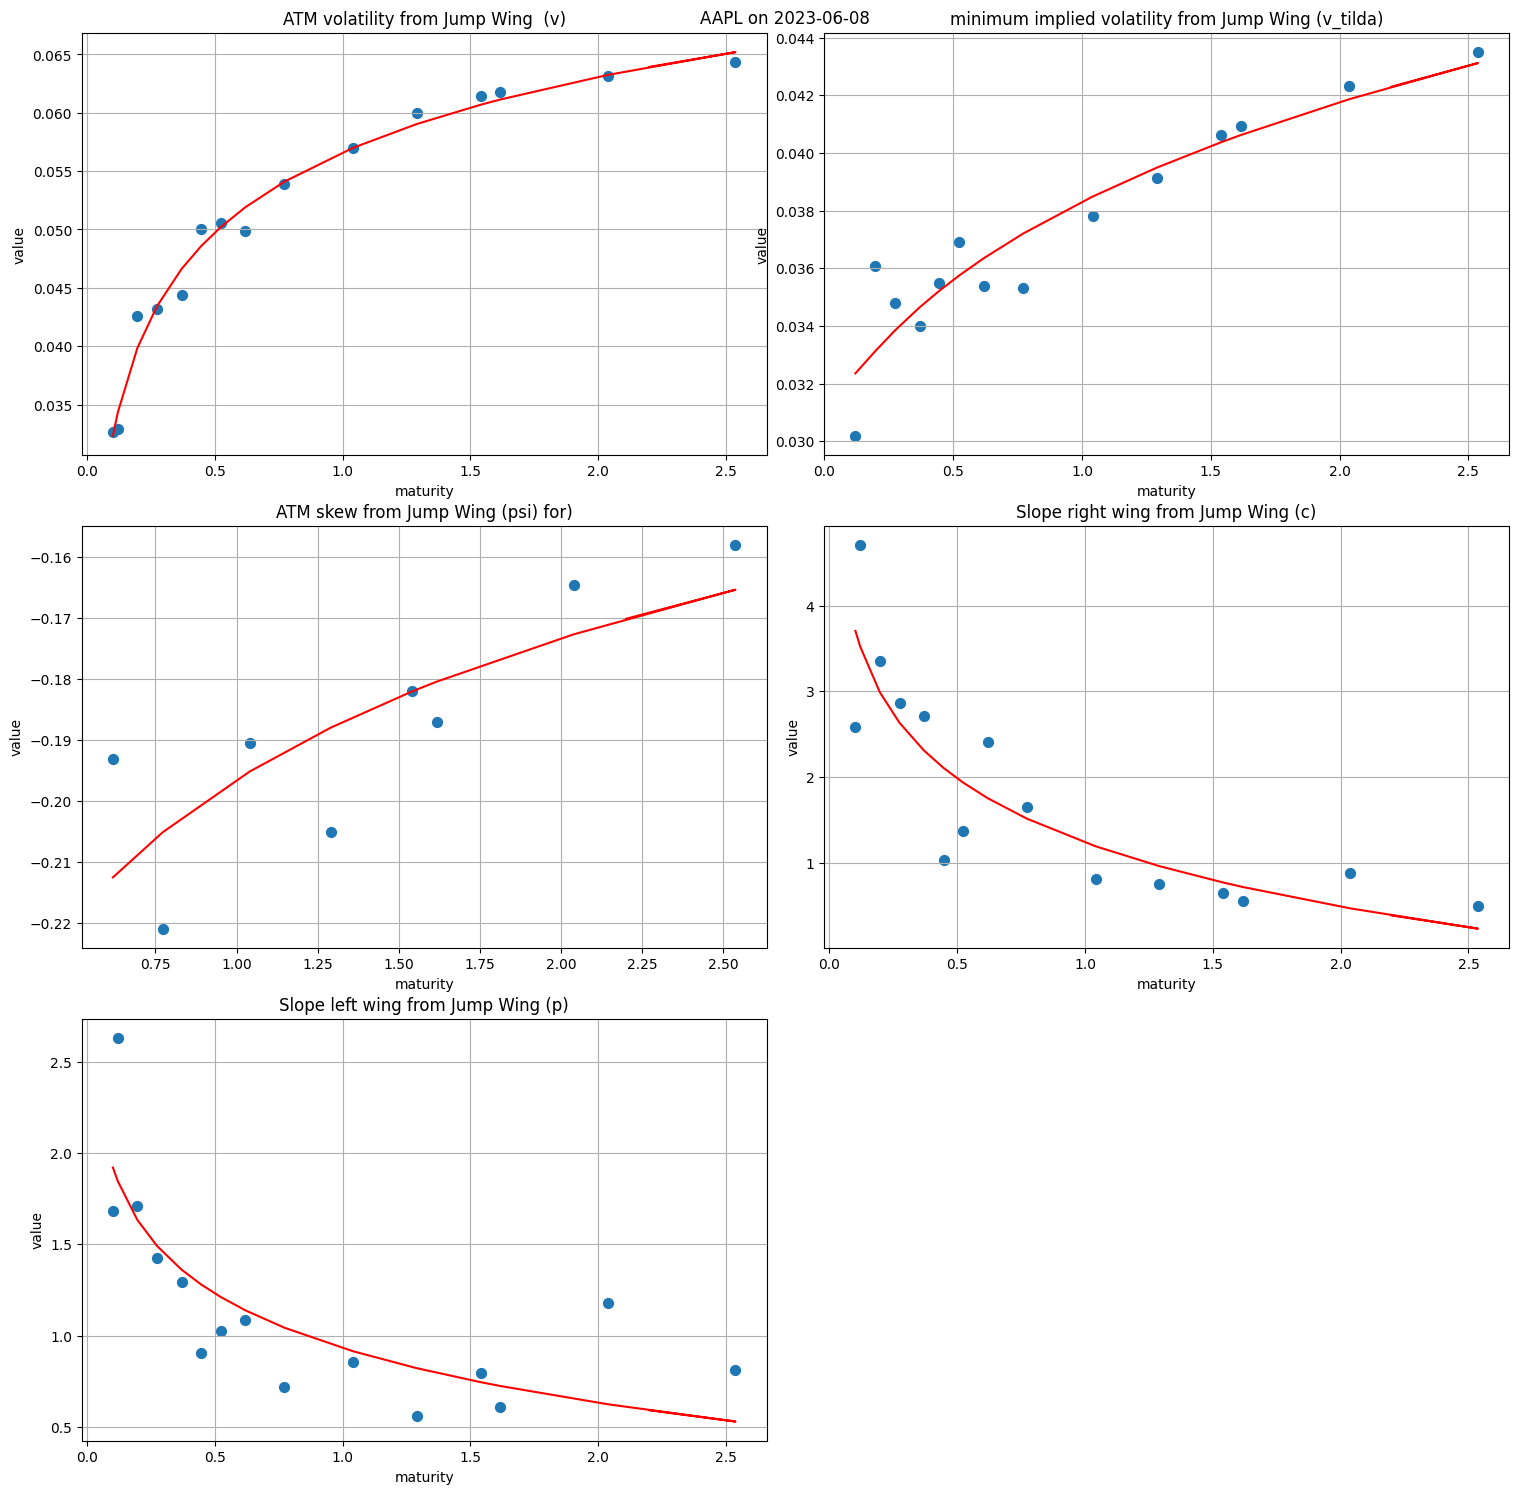

0.06393460166746824 0.042296646449421035 -0.1701619935687796 0.3850893829250849 0.5908573601709712
0.14065612366843014
b = 0.18301026323873926
beta = 0.4865839251870864
a= -0.0704785072491273
b= 0.18301026323873926
rho= -0.2108393503042143
m= 0.509128403960285
sigma= 0.9141111713946684
SVI(a=-0.0704785072491273, b=0.18301026323873926, rho=-0.2108393503042143, m=0.509128403960285, sigma=0.9141111713946684)


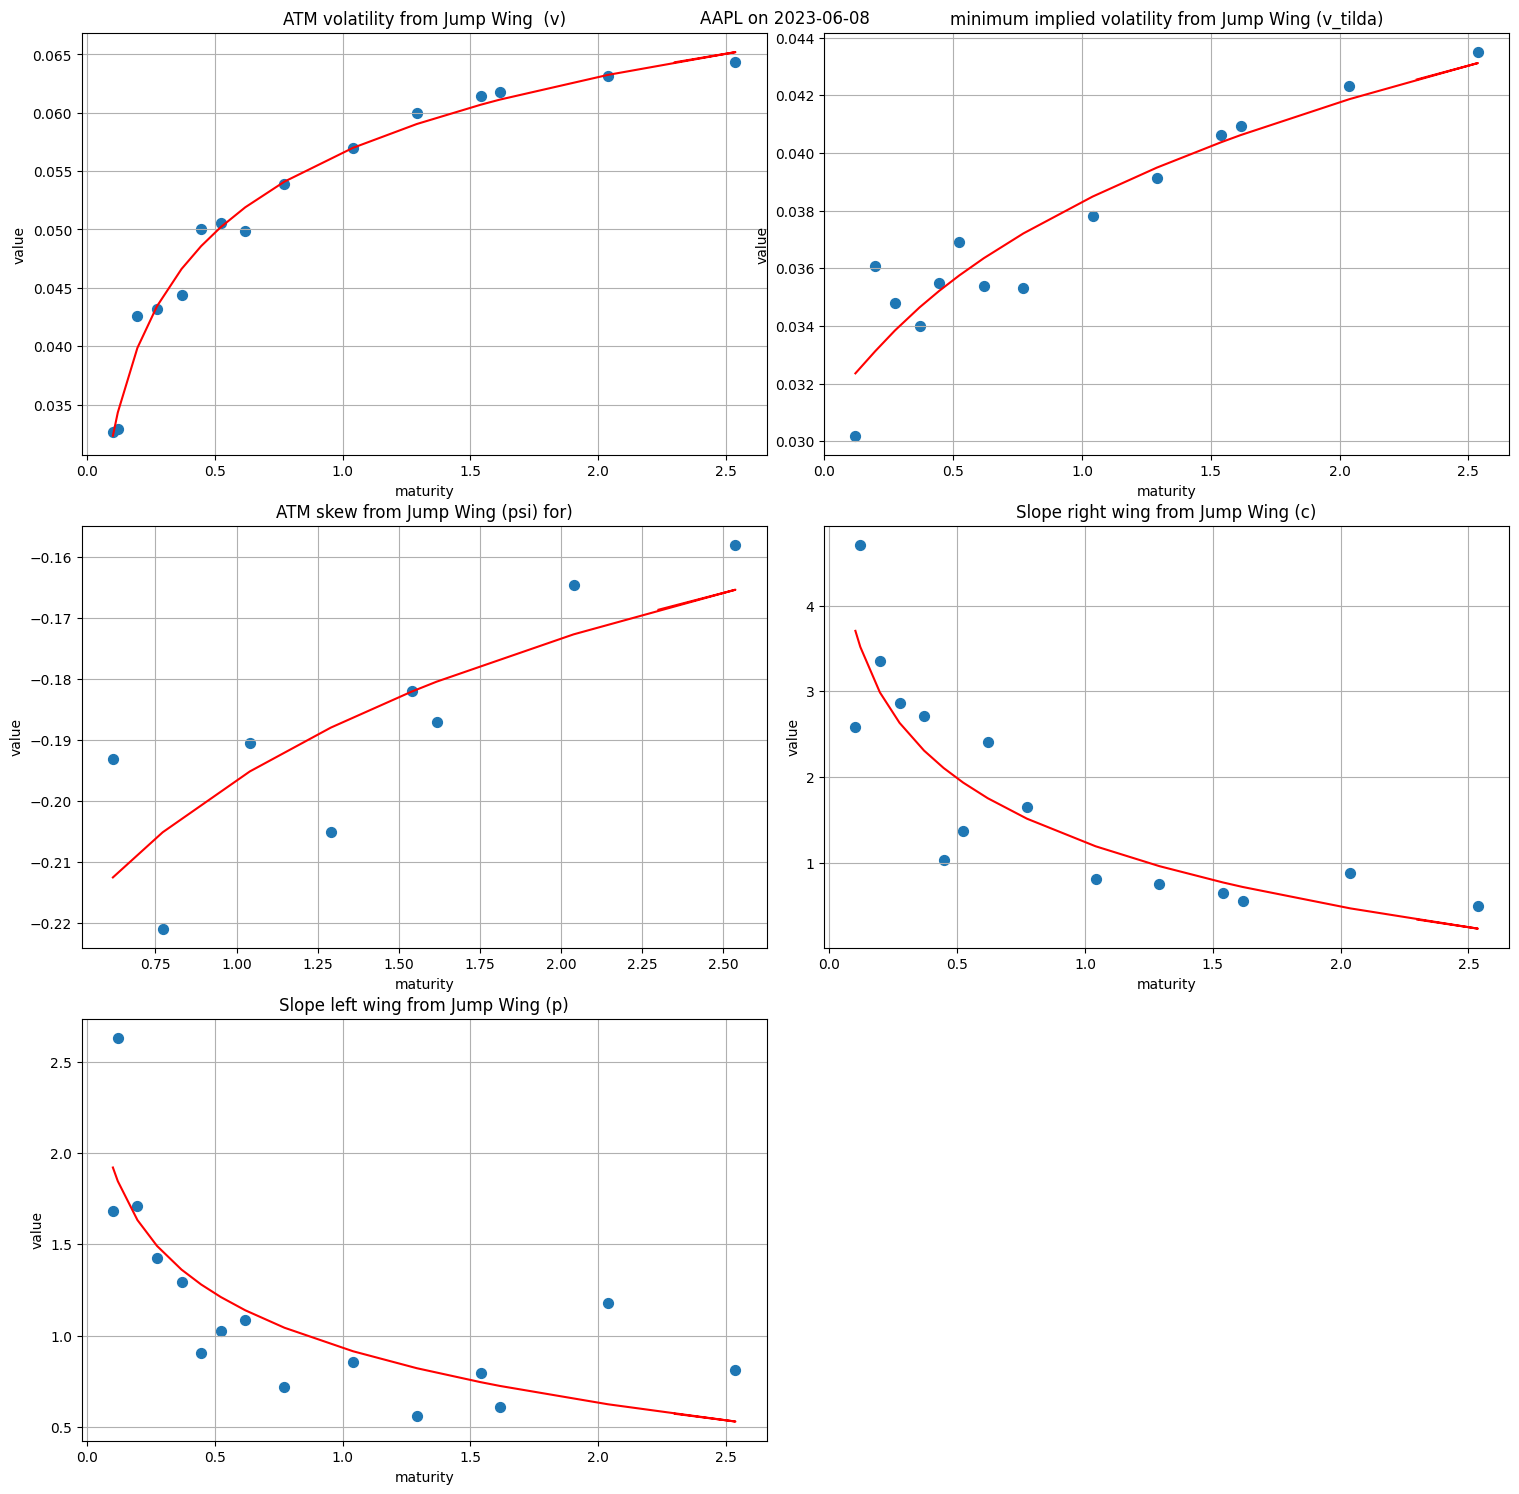

0.06433130049520983 0.04255033081583234 -0.1686778753123431 0.33713870208223196 0.5716522549805267
0.1479619911389826
b = 0.17478698248304791
beta = 0.48437756222158235
a= -0.05348564802560113
b= 0.17478698248304791
rho= -0.2580500510879311
m= 0.4962345992764798
sigma= 0.8962746617296876
SVI(a=-0.05348564802560113, b=0.17478698248304791, rho=-0.2580500510879311, m=0.4962345992764798, sigma=0.8962746617296876)


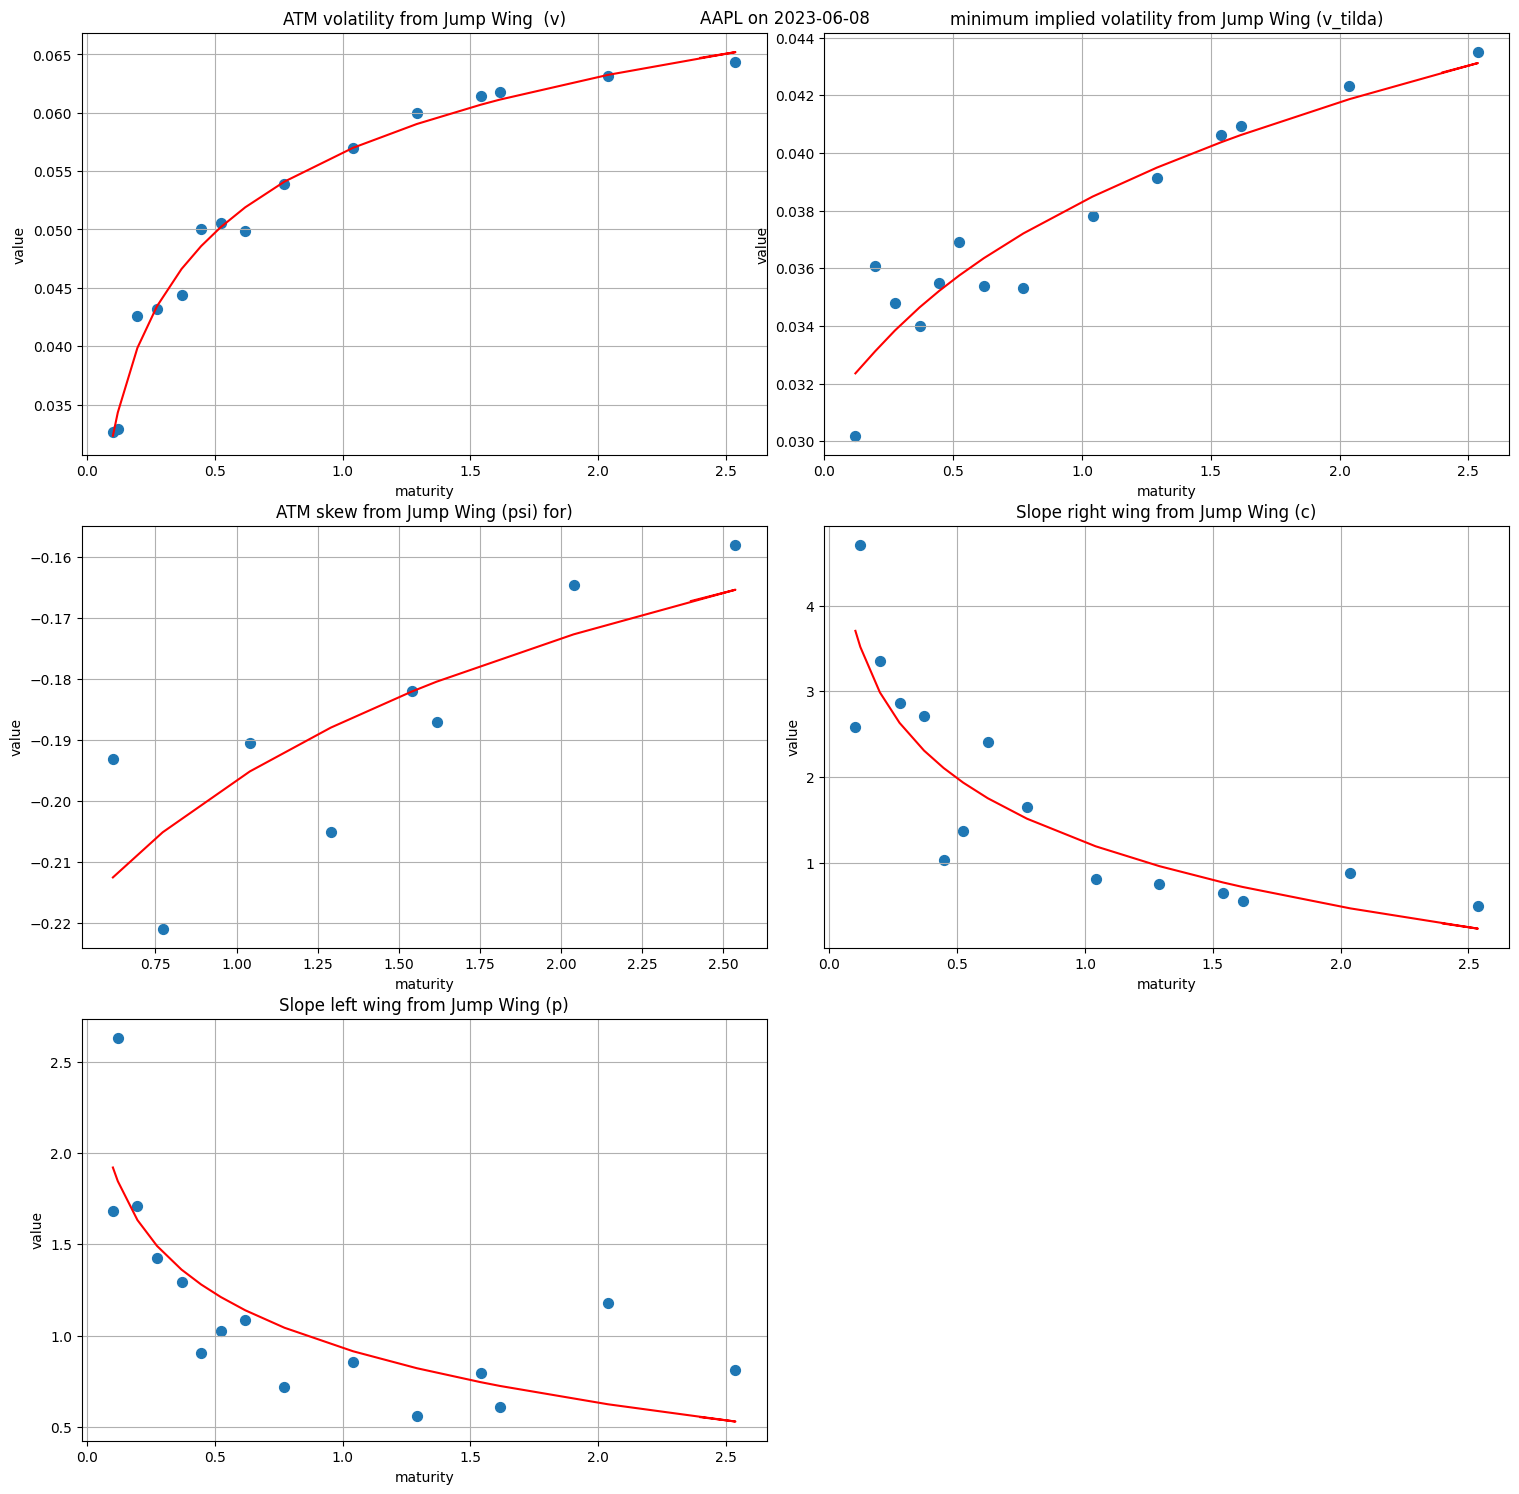

0.06470951399897577 0.042796083755870816 -0.16725693051526827 0.2912291054821282 0.5532646405304749
0.15530283359754185
b = 0.1664010766457209
beta = 0.481936294891937
a= -0.035666026041402635
b= 0.1664010766457209
rho= -0.3102871232446476
m= 0.4811411350413193
sigma= 0.8747605820039396
SVI(a=-0.035666026041402635, b=0.1664010766457209, rho=-0.3102871232446476, m=0.4811411350413193, sigma=0.8747605820039396)


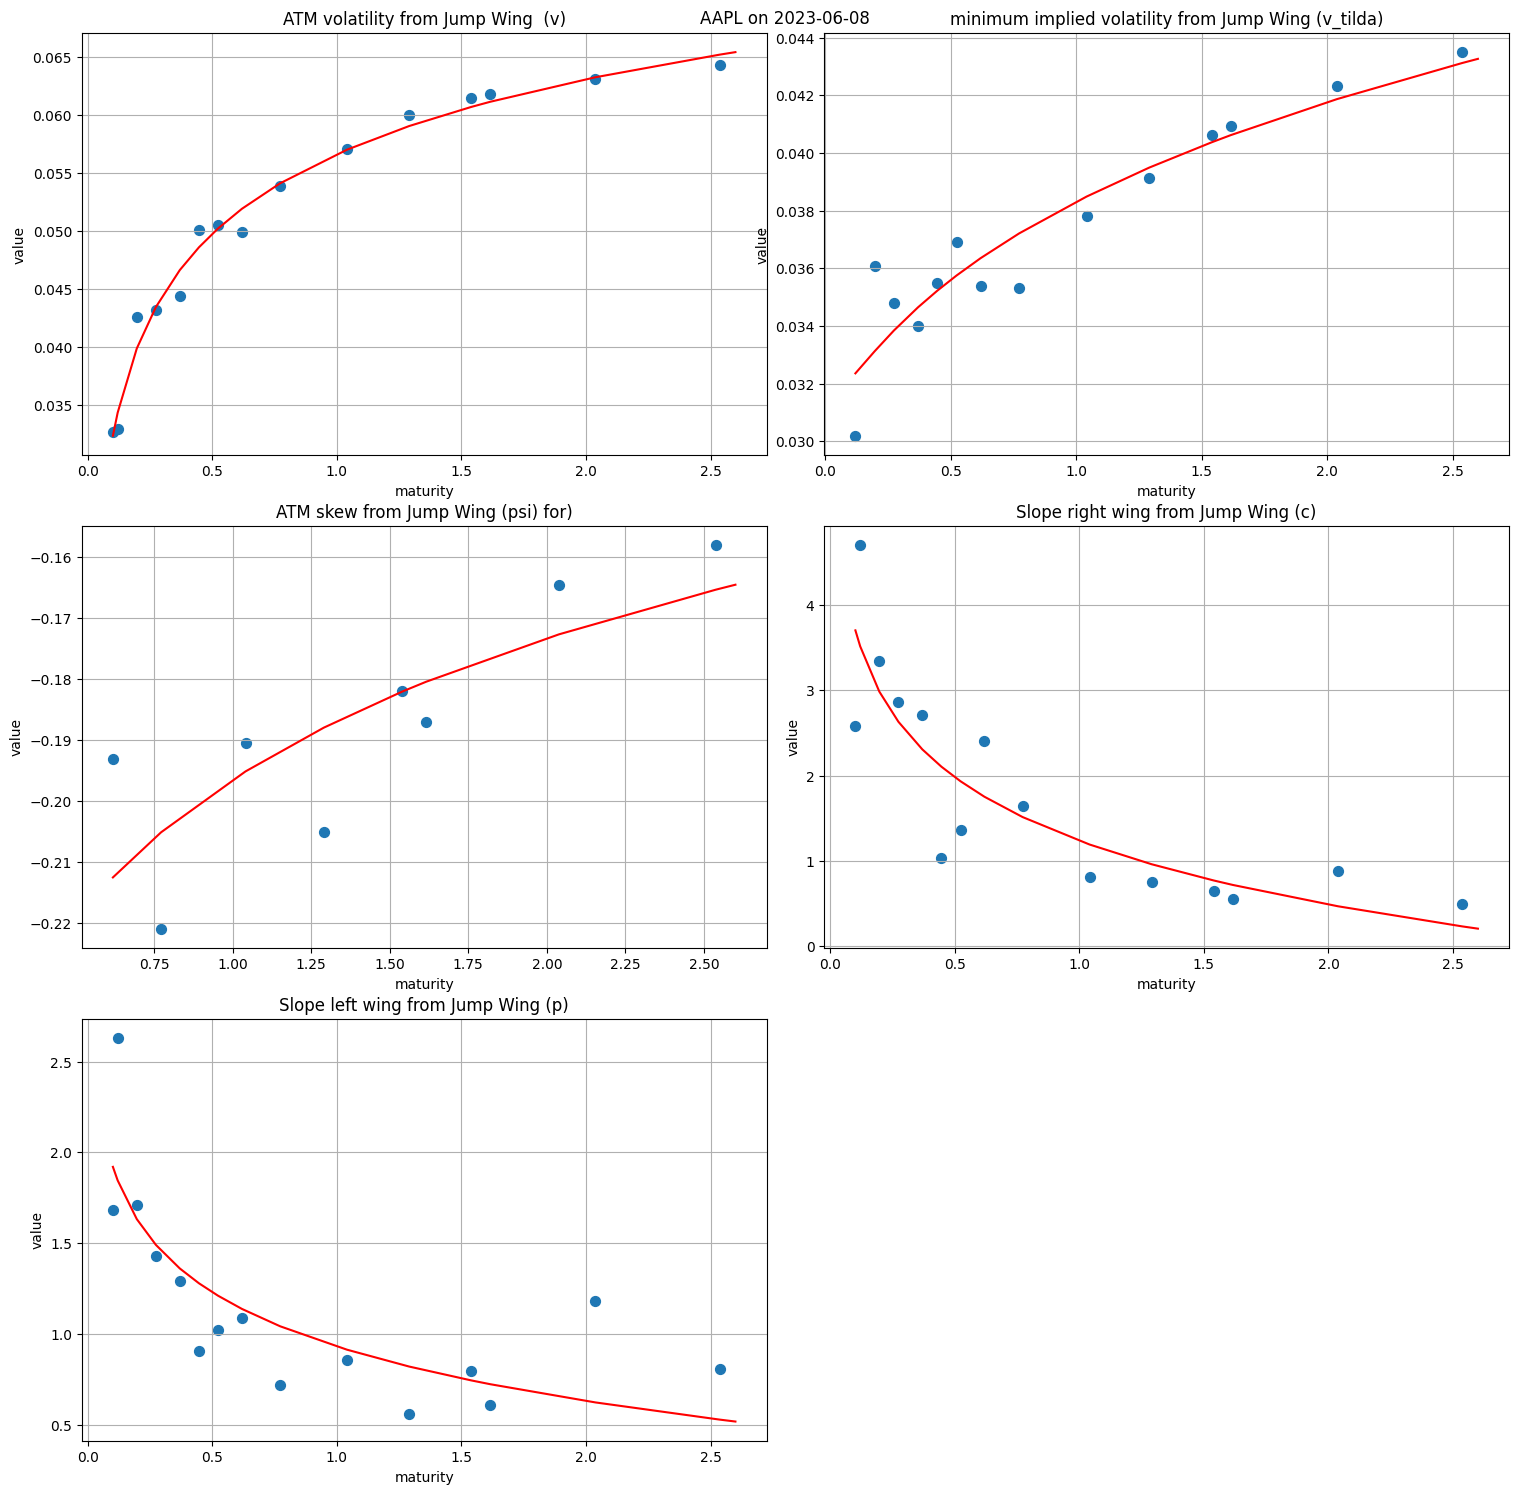

0.06541658942002396 0.043265873690080614 -0.1645845315622772 0.20488602013572543 0.5186826907562965
0.1700831324920623
b = 0.14920397921198403
beta = 0.47616964421220487
a= 0.002305354996844075
b= 0.14920397921198403
rho= -0.43367915983227046
m= 0.44379935280756483
sigma= 0.8195744765998855
SVI(a=0.002305354996844075, b=0.14920397921198403, rho=-0.43367915983227046, m=0.44379935280756483, sigma=0.8195744765998855)


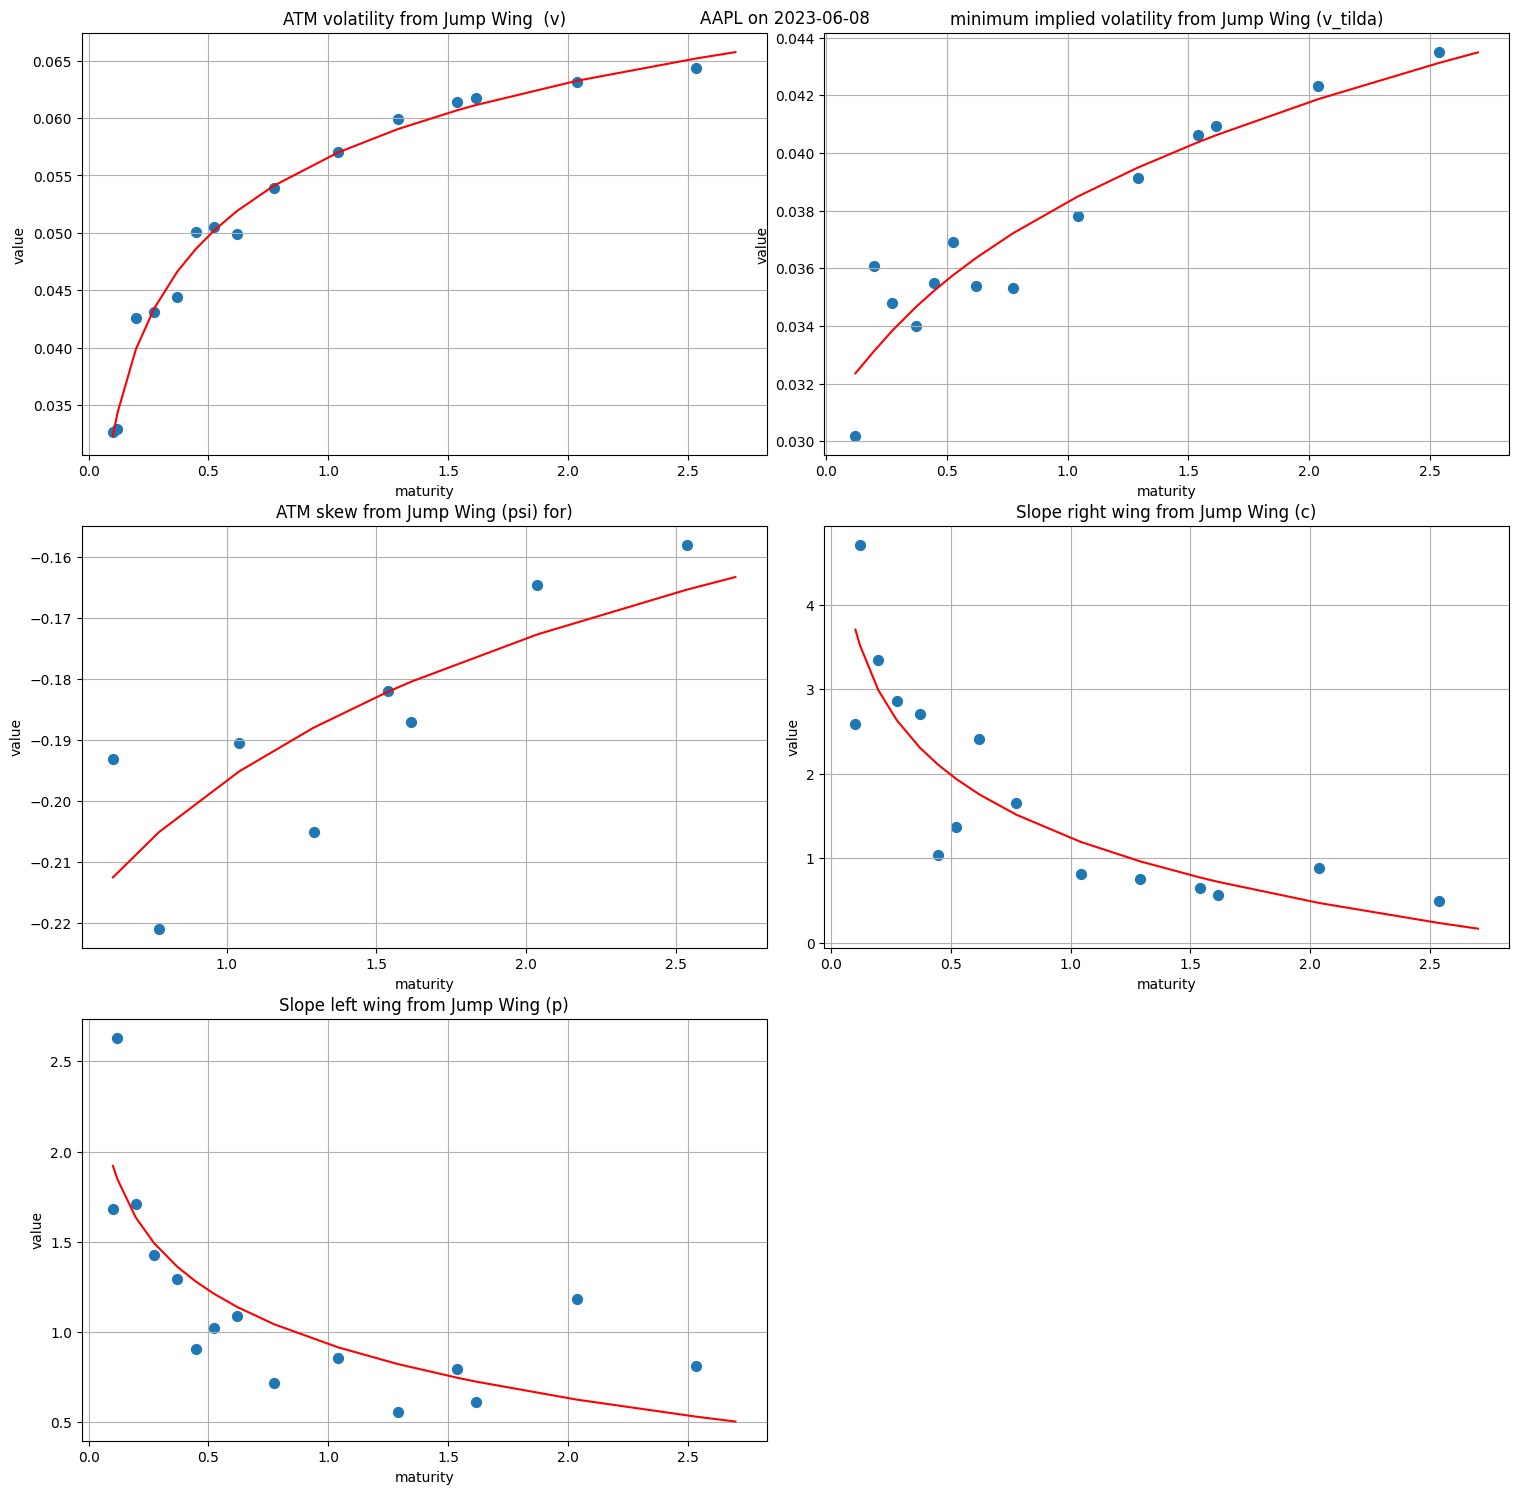

0.06574805740578081 0.043490822205823995 -0.1633244890684843 0.16417504902121927 0.5023772187814232
0.1775197549956082
b = 0.14041954440094095
beta = 0.4727247985405234
a= 0.0224560077590735
b= 0.14041954440094095
rho= -0.5073903219549787
m= 0.42103660674183396
sigma= 0.7848577382226567
SVI(a=0.0224560077590735, b=0.14041954440094095, rho=-0.5073903219549787, m=0.42103660674183396, sigma=0.7848577382226567)


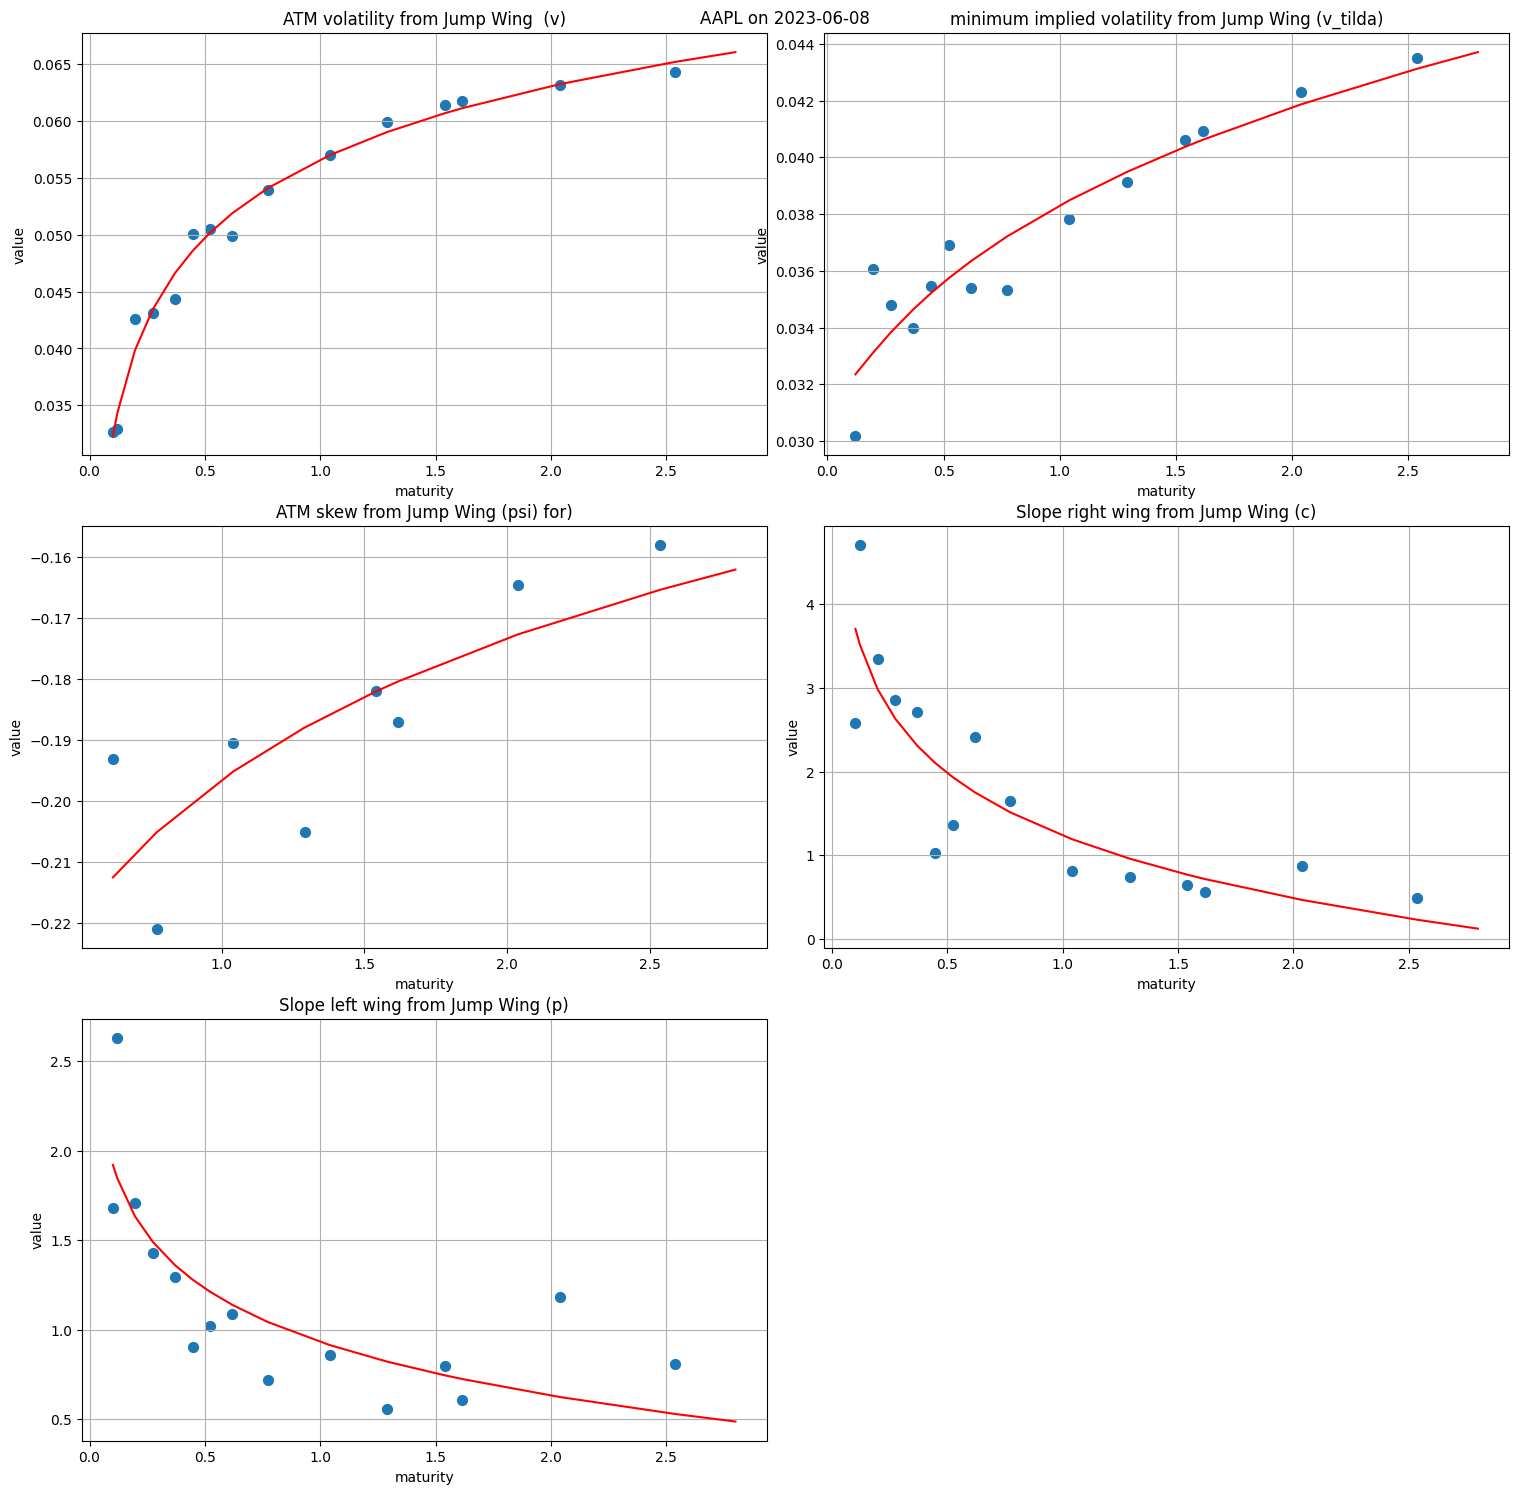

0.06606630533820047 0.043709675502424966 -0.16211027659329674 0.12494480936839936 0.48666480623721103
0.18498565494696131
b = 0.13152652161304026
beta = 0.46879758294916063
a= 0.04347178251656962
b= 0.13152652161304026
rho= -0.591423005196934
m= 0.3949049006432089
sigma= 0.7440774708663445
SVI(a=0.04347178251656962, b=0.13152652161304026, rho=-0.591423005196934, m=0.3949049006432089, sigma=0.7440774708663445)


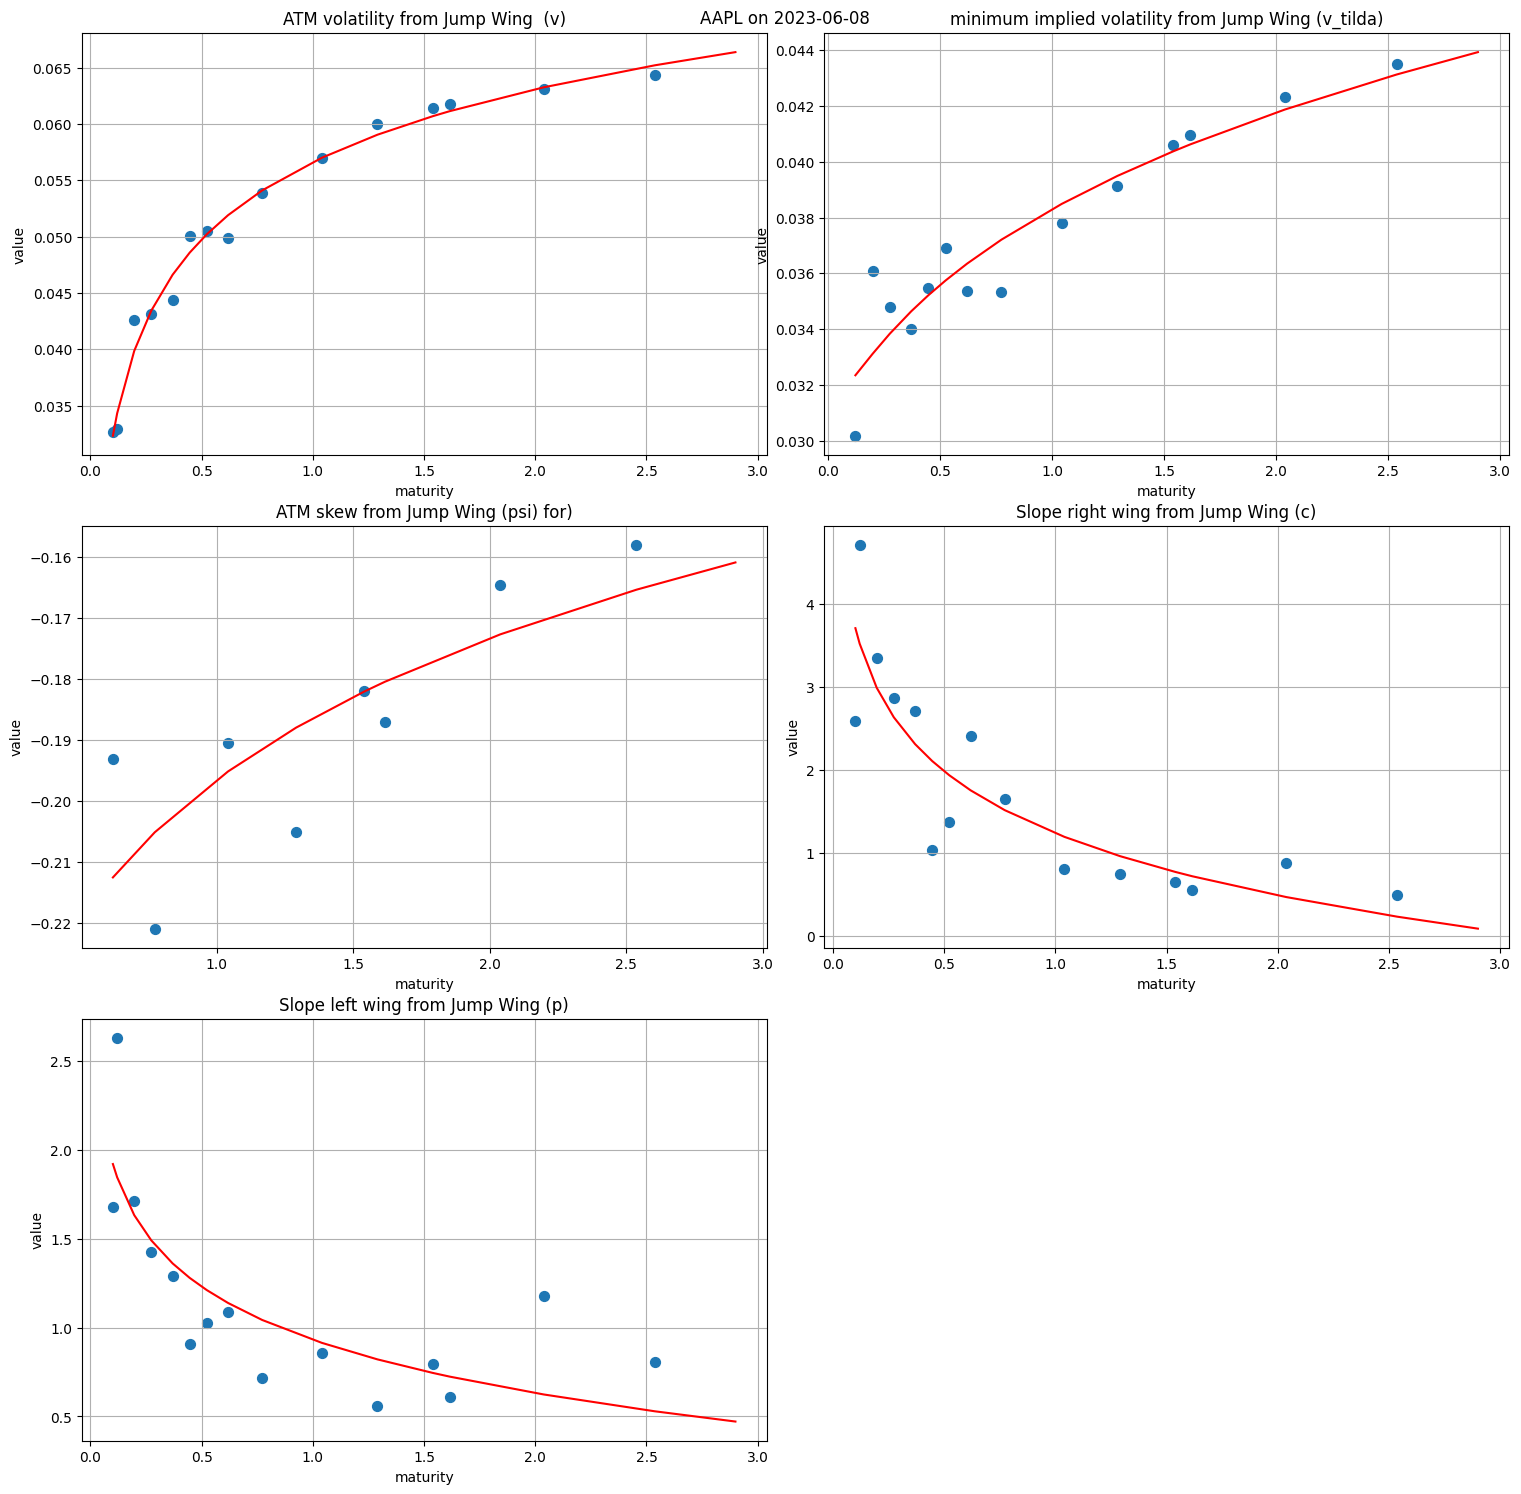

0.066372301373629 0.04392278950011859 -0.16093867696794179 0.0870913570121874 0.47150382162668936
0.19247967398352409
b = 0.12253485026697743
beta = 0.4642758354792851
a= 0.06557062357444549
b= 0.12253485026697743
rho= -0.688177197574809
m= 0.36441674524057754
sigma= 0.6951912713033657
SVI(a=0.06557062357444549, b=0.12253485026697743, rho=-0.688177197574809, m=0.36441674524057754, sigma=0.6951912713033657)


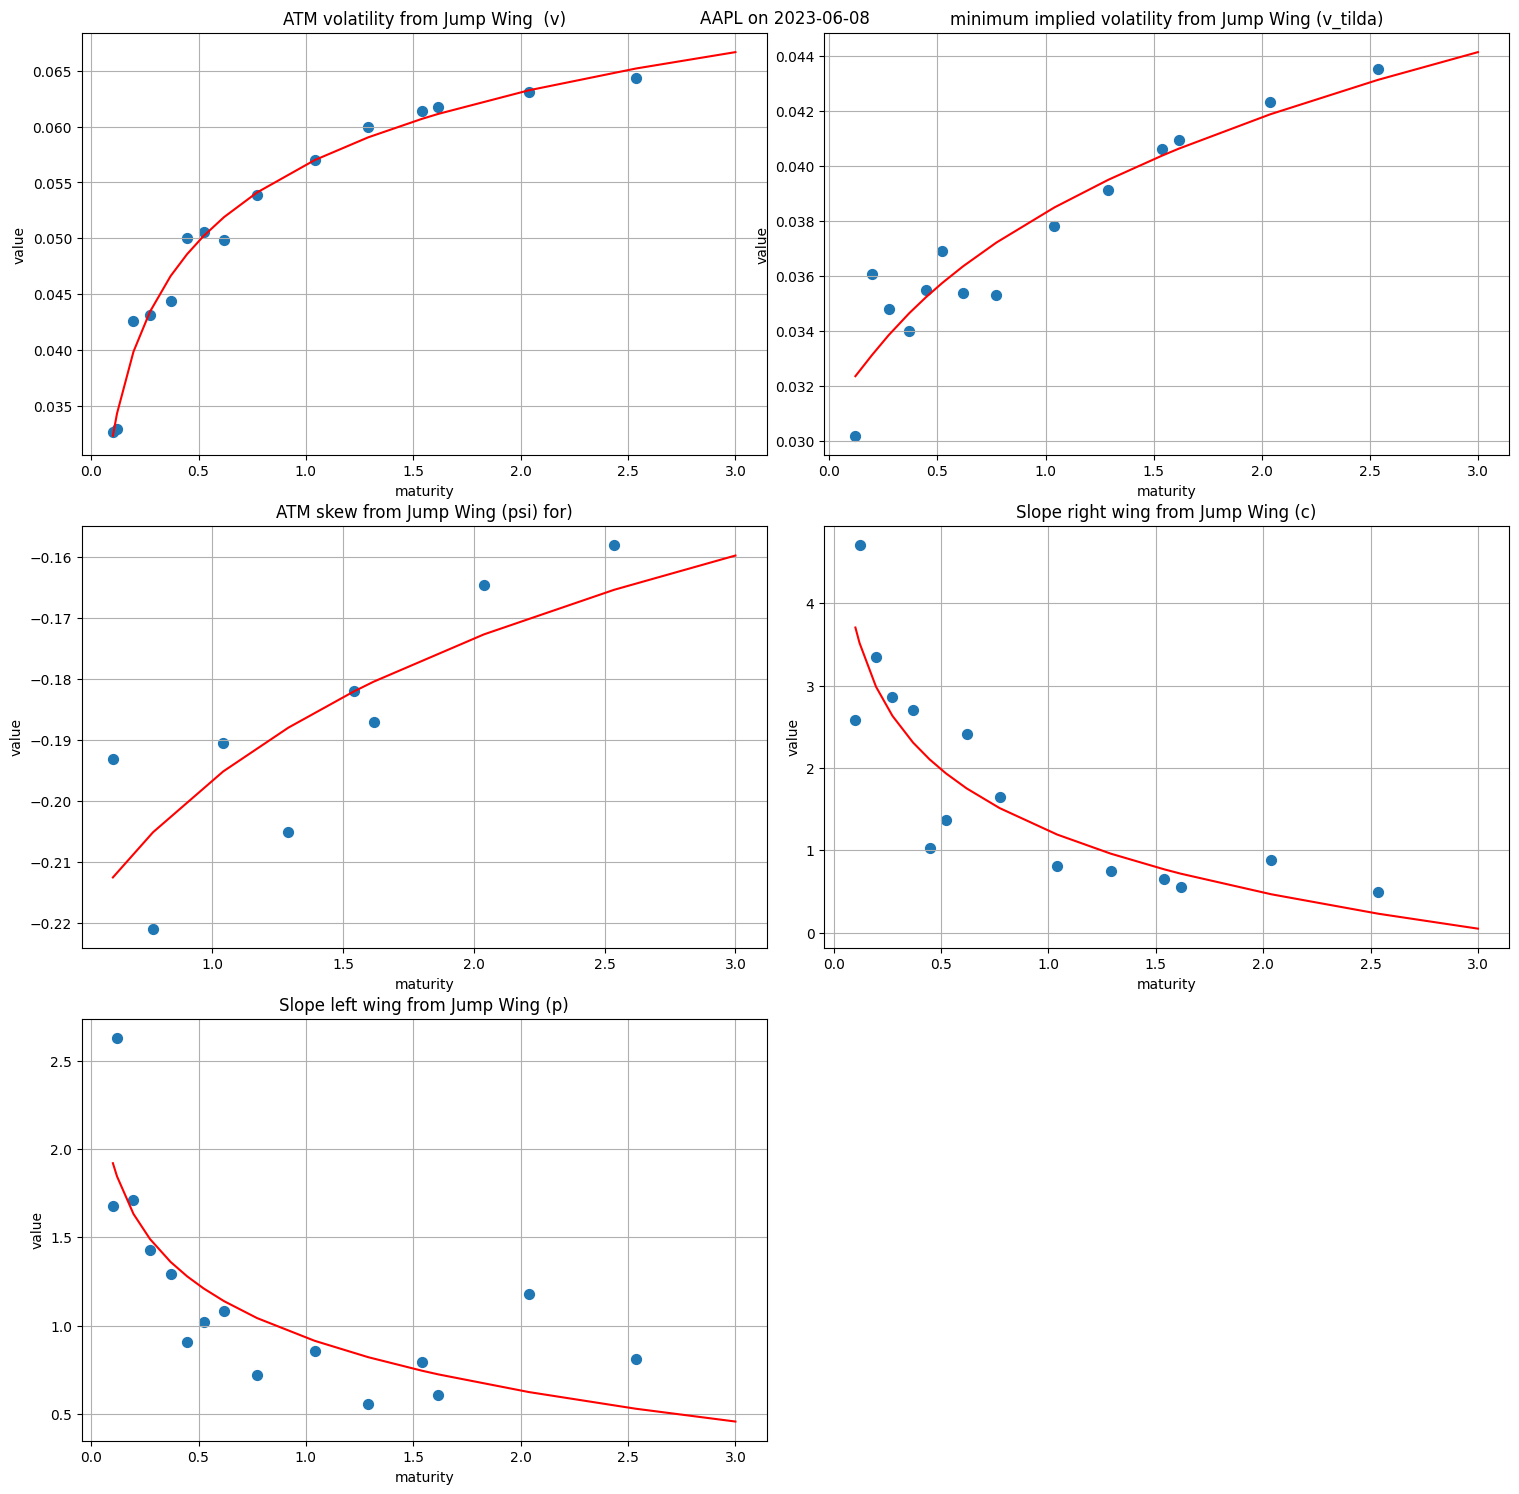

0.06666691249564682 0.04413048870700119 -0.15980680032563252 0.050521322654433876 0.4568568688762049
0.20000073748694047
b = 0.11345342183180554
beta = 0.45900998302307894
a= 0.08934064756891397
b= 0.11345342183180554
rho= -0.8008533930005028
m= 0.32736824732385095
sigma= 0.6336335717892225
SVI(a=0.08934064756891397, b=0.11345342183180554, rho=-0.8008533930005028, m=0.32736824732385095, sigma=0.6336335717892225)


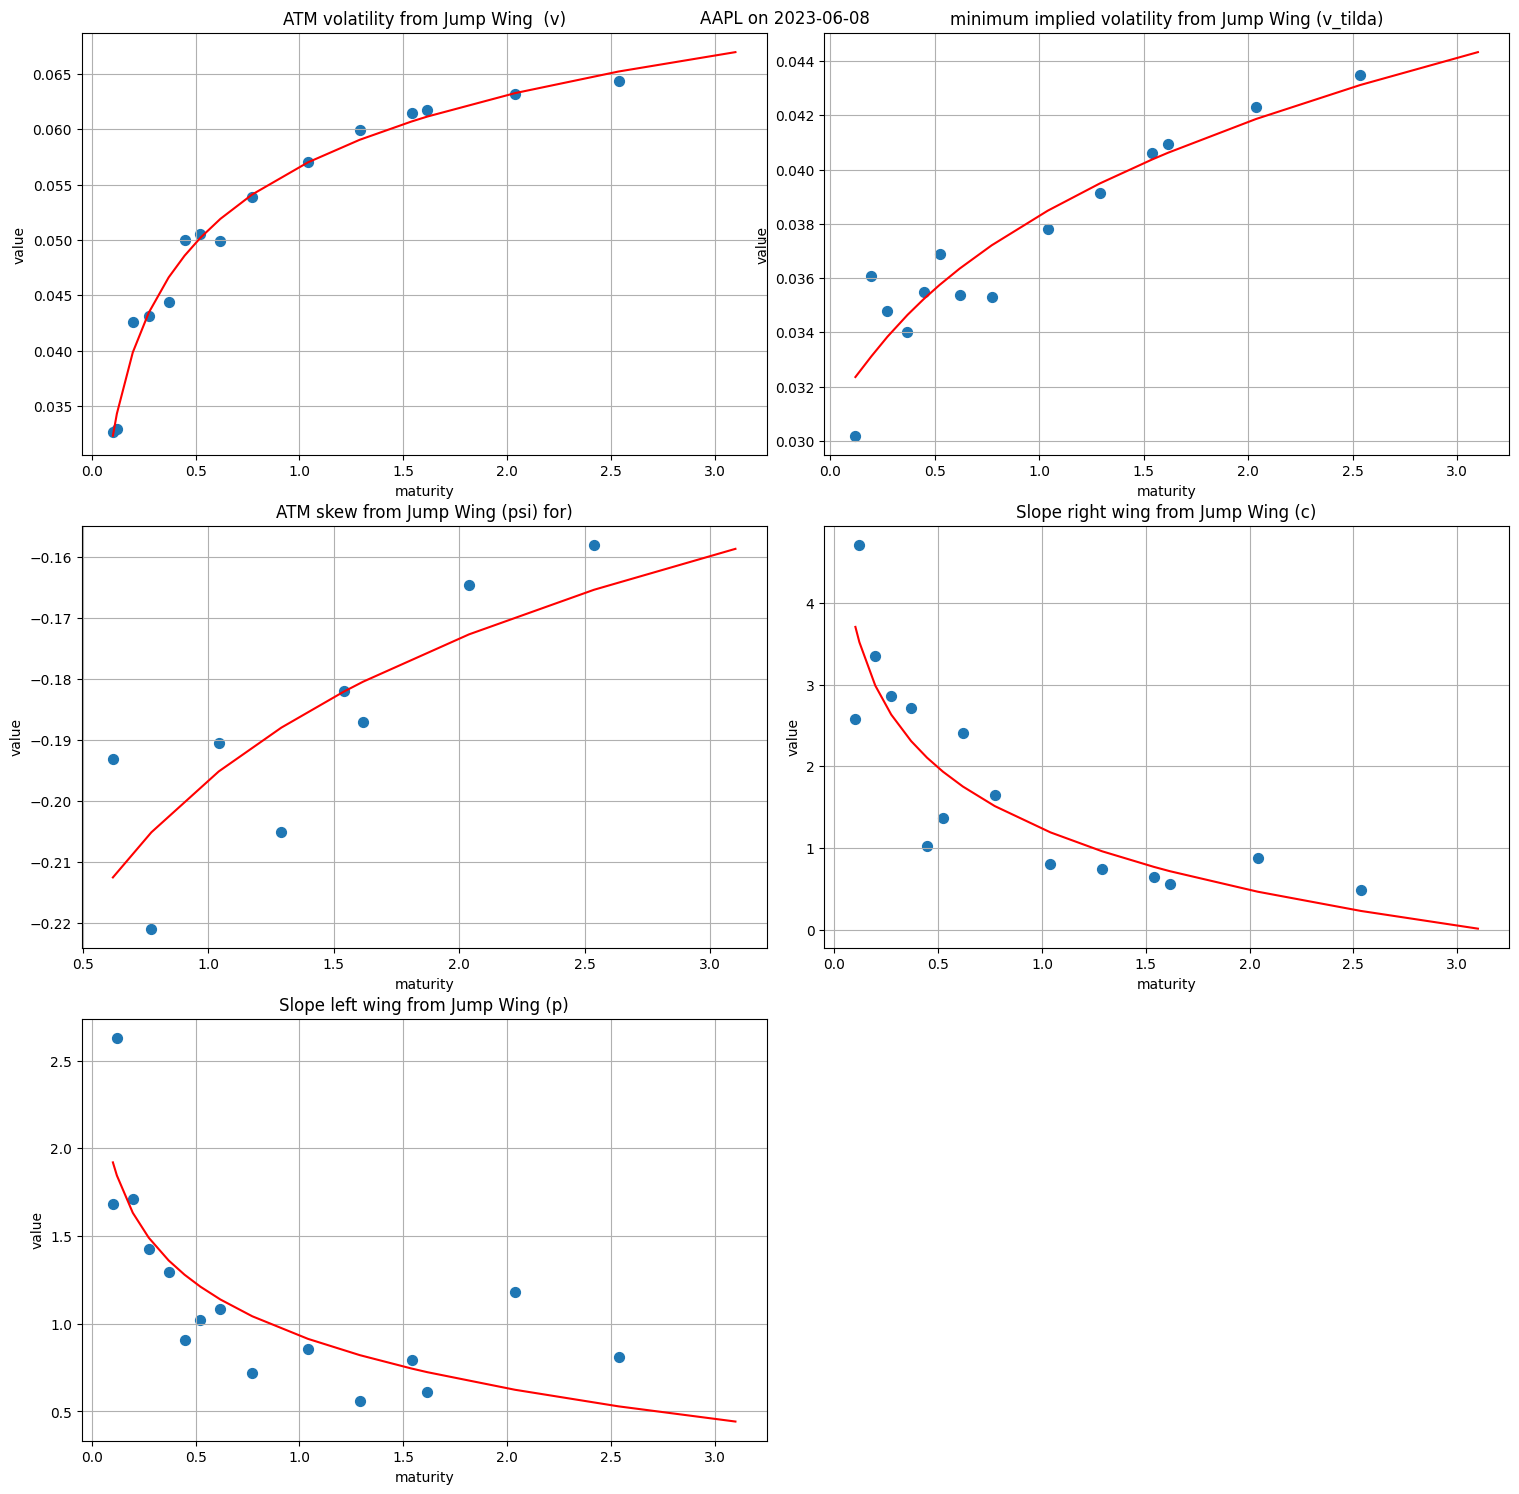

0.06695091804911477 0.04433306987614688 -0.15871204115608617 0.015150524329542225 0.4426902316030911
0.20754784595225578
b = 0.10429021661020027
beta = 0.45279598782878816
a= 0.11717166880158782
b= 0.10429021661020027
rho= -0.9338174938197443
m= 0.2757784432751802
sigma= 0.5430435980923369
SVI(a=0.11717166880158782, b=0.10429021661020027, rho=-0.9338174938197443, m=0.2757784432751802, sigma=0.5430435980923369)


In [293]:
lister_time = [0.7, 0.9, 1.1, 1.2, 1.4, 1.7,1.8,1.9,2.1,2.2,2.3,2.4,2.6,2.7,2.8,2.9,3,3.1] 
lister = [13,15,17,18,20,23,24,25,27,28,29,30,32,33,34,35,36,37]
T_ACT_365 = lister_time 
T_ACT_unique = []
for k in Implied_Volatility_without_extrapolation['implied_volatility_surface']:
    T_ACT_365.append(k['expiry_date_in_act365_year_fraction'])
    T_ACT_unique.append((k['expiry_date_in_act365_year_fraction']))
    T_ACT_365.sort()
    
number = len(T_ACT_365)


set_param = [0] * number
x_grid = [0] * number
for i in lister:
    a, b, rho, m, sigma, _ = get_SVI_extrapolation(Implied_Volatility_without_extrapolation, T_ACT_365[i], start_v, start_v_tilda, end_psi, start_c, start_p,0, 0, type_reggresion = 'polynomial')
    print(SVI(a, b, rho, m, sigma))
    set_param[i] = SVI(a, b, rho, m, sigma)
# for k in Implied_Volatility_without_extrapolation['implied_volatility_surface']:    
for ind, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,14,16,19,21,22,26,31]):
    set_param[i] = Implied_Volatility_without_extrapolation['implied_volatility_surface'][ind]['set_param_raw']
    x_grid[i] = (Implied_Volatility_without_extrapolation['implied_volatility_surface'][ind]['strikes'] / Implied_Volatility_without_extrapolation['implied_volatility_surface'][ind]['reference_forward'])

for i in lister:
    x_grid[i] = x_grid[i-1]

Implied_survace_w = [0] * number

def get_w_SVI_raw(a_new, b_new, rho_new, m_new, sigma_new, x):
    return a_new + b_new *(rho_new *(x-m_new) + np.sqrt((x-m_new)**2 + sigma_new**2))

for ind, n in enumerate(set_param):
#     x = np.log(np.linspace(x_grid[ind][0], x_grid[ind][-1], 100))
#     
    x = np.log(np.linspace(0.8 - ind / 100 * 1.3,1.2 + ind / 100 * 1.3,100))
    x_grid[ind] = np.exp(x)
    w_SVI_raw = np.linspace(0,0,100)
    for cnd, c in enumerate(x):
        w_SVI_raw[cnd] = get_w_SVI_raw(n.a,n.b,n.rho,n.m,n.sigma, c) # compute total varience for given parameters
    w_SVI_total_variance = w_SVI_raw
    w_SVI_raw = np.sqrt(w_SVI_total_variance / T_ACT_365[ind]) 
    Implied_survace_w[ind] = w_SVI_raw  
    
    
T_AC = []
for i in T_ACT_365:
    T_AC.append([i] * 100)
# set_param.append(k['set_param_raw'])

# start_v = 5
# start_v_tilda = 6
# end_psi = 8
# start_c = 5
# start_p =5
# expiry_list = [0.7, 0.9, 1.1, 1.2, 1.4, 1.7,1.8,1.9,2.1,2.2,2.3,2.4]    
# for k in expiry_list: 
#     a, b, rho, m, sigma = get_SVI_extrapolation(Implied_Volatility_without_extrapolation, expire_time, start_v, start_v_tilda, end_psi, start_c, start_p,0, 0, type_reggresion = 'polynomial')
#     T_ACT_365.append(k)
#     set_param.append(SVI(a, b, rho, m, sigma))
    
    

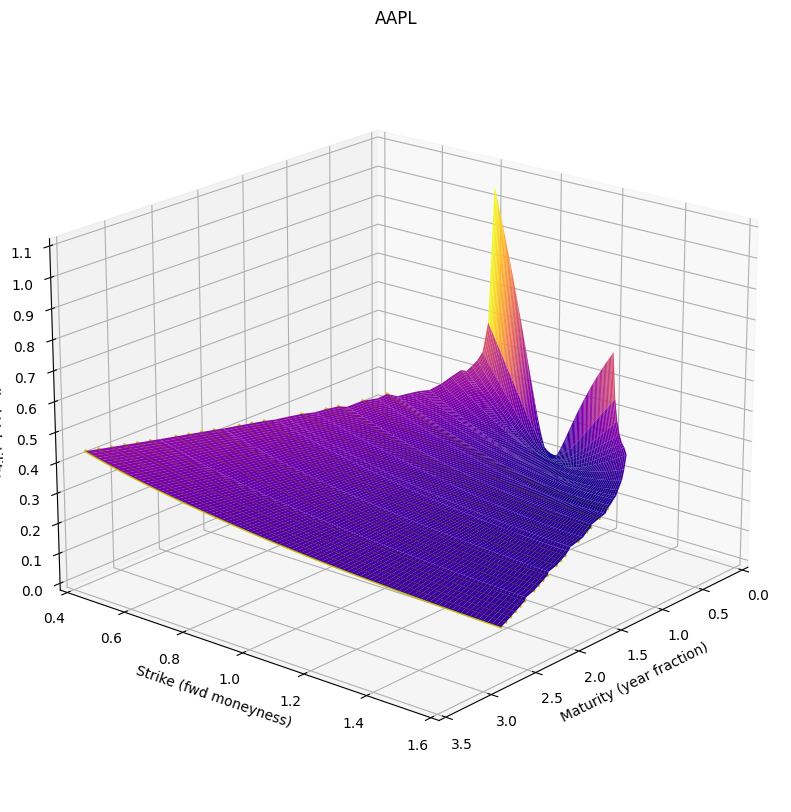

In [299]:
fig = plt.figure(figsize=(15, 10))
ax_3d = fig.add_subplot(projection='3d')
xval = np.array(x_grid)
yval = T_AC
x, y = np.meshgrid(xval, yval)
z = np.array(Implied_survace_w)
for i in lister:
    ax_3d.plot(x_grid[i], Implied_survace_w[i], zs=T_AC[i],zdir='x',color='y', linewidth=2)

ax_3d.plot_surface(T_AC, np.array(x_grid), z, rstride=1, cstride=1, cmap='plasma')


#     ax_3d.scatter( k['expiry_date_in_act365_year_fraction'], np.array(k['strikes'])/k['reference_forward'], k['mid_implied_volatilities'], s=10)

ax_3d.set_title(ticker)
ax_3d.set_xlabel(r'Maturity (year fraction)')
ax_3d.axes.set_xlim3d(left=0, right=3.5)
ax_3d.set_ylabel(r'Strike (fwd moneyness)')
ax_3d.axes.set_ylim3d(bottom=0.4, top=1.6)
ax_3d.set_zlabel(r'Implied Volatility')
ax_3d.axes.set_zlim3d(bottom=0.0, top=1.1) 
ax_3d.set_zticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1])
ax_3d.grid()
ax_3d.view_init(20, 40)



In [209]:
x = np.arange(-2*np.pi, 2*np.pi, 0.2)
y = np.arange(-2*np.pi, 2*np.pi, 0.2)
xgrid, ygrid = np.meshgrid(x, y)

In [207]:
len(xgrid[2])

63

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


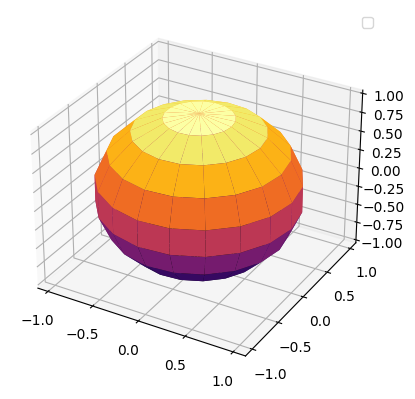

In [219]:
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='inferno')
ax.legend()

In [220]:
np.array(x_grid)

array([[0.92724669, 0.92836503, 0.92948337, ..., 1.03572602, 1.03684437,
        1.03796271],
       [0.77437091, 0.77828187, 0.78219284, ..., 1.15373444, 1.1576454 ,
        1.16155636],
       [0.71888252, 0.72446825, 0.73005397, ..., 1.26069763, 1.26628336,
        1.27186908],
       ...,
       [0.56793587, 0.57836628, 0.58879669, ..., 1.57968571, 1.59011612,
        1.60054653],
       [0.56793587, 0.57836628, 0.58879669, ..., 1.57968571, 1.59011612,
        1.60054653],
       [0.51028475, 0.52110897, 0.53193319, ..., 1.56023428, 1.5710585 ,
        1.58188273]])

In [236]:
u

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.33069396, 0.33069396, 0.33069396, 0.33069396, 0.33069396,
        0.33069396, 0.33069396, 0.33069396, 0.33069396, 0.33069396],
       [0.66138793, 0.66138793, 0.66138793, 0.66138793, 0.66138793,
        0.66138793, 0.66138793, 0.66138793, 0.66138793, 0.66138793],
       [0.99208189, 0.99208189, 0.99208189, 0.99208189, 0.99208189,
        0.99208189, 0.99208189, 0.99208189, 0.99208189, 0.99208189],
       [1.32277585, 1.32277585, 1.32277585, 1.32277585, 1.32277585,
        1.32277585, 1.32277585, 1.32277585, 1.32277585, 1.32277585],
       [1.65346982, 1.65346982, 1.65346982, 1.65346982, 1.65346982,
        1.65346982, 1.65346982, 1.65346982, 1.65346982, 1.65346982],
       [1.98416378, 1.98416378, 1.98416378, 1.98416378, 1.98416378,
        1.98416378, 1.98416378, 1.98416378, 1.98416378, 1.98416378],
       [2.31485774, 2.31485774, 2.3148577